# Financial Econometrics I: Project - Pavlína Křenková and Bernhard Brunner

June 2024

In [1]:
# Packages
shhh = suppressPackageStartupMessages #load quietly
shhh(library(zip))
shhh(library(ggplot2))
shhh(library(gridExtra))
shhh(library(forecast))
shhh(library(xts))
shhh(library(tseries))
shhh(library(highfrequency))
shhh(library(lmtest))
shhh(library(sandwich))
shhh(library(zoo))
shhh(library(rugarch))
shhh(library(DescTools))
shhh(library(car))

# 1) Introduction

This project estimates and compares several econometric models analyzing the volatility of the American Tower Corp stock returns. 3 main sections are included: **data description**, focusing on exploration of the data using summary statistics and simple plots, **in-sample fit** section in which 6 different models are fitted and evaluated, and lastly the **forecasts** section where we compare the out-of-sample forecasting performance of all the models using both the rolling and expanding window forecasting schemes.

# 2) Data description

### Load the data into R

In [2]:
unzip("data_project_2024.zip", files = "30.RData", exdir = "temp_data")

# Load the .RData file
load("temp_data/30.RData")

# Return all variables and functions defined in current working directory
ls()

[1] "amt"  "shhh"

### Descriptive statistics

In [3]:
head(amt)
summary(amt)
nrow(amt) # Get number of observations
typeof(amt) # Get data type of time series object

                     ret          RV        RV_p        RV_n           RS
2010-01-05  0.0002304634 0.011009479 0.009259483 0.005955720  1.350981427
2010-01-06  0.0168678327 0.011202805 0.008230314 0.007600314 -0.216028901
2010-01-07  0.0042856864 0.011699048 0.008224708 0.008319971 -0.006426756
2010-01-08 -0.0011261662 0.009363287 0.007205883 0.005978829  0.753857266
2010-01-11  0.0109791088 0.011245783 0.006254063 0.009346354 -0.759894442
2010-01-12 -0.0252775180 0.011362306 0.006760609 0.009132151 -0.795626739
                 RK
2010-01-05 5.926201
2010-01-06 6.845365
2010-01-07 4.509419
2010-01-08 6.858052
2010-01-11 5.162329
2010-01-12 4.448177

     Index                 ret                   RV          
 Min.   :2010-01-05   Min.   :-0.1035571   Min.   :0.003823  
 1st Qu.:2011-07-04   1st Qu.:-0.0071153   1st Qu.:0.007748  
 Median :2013-01-10   Median : 0.0006953   Median :0.009442  
 Mean   :2013-01-08   Mean   : 0.0005369   Mean   :0.010519  
 3rd Qu.:2014-07-14   3rd Qu.: 0.0079566   3rd Qu.:0.011820  
 Max.   :2016-01-22   Max.   : 0.0701801   Max.   :0.055211  
      RV_p               RV_n                RS                 RK        
 Min.   :0.002432   Min.   :0.002027   Min.   :-5.71549   Min.   : 2.054  
 1st Qu.:0.005315   1st Qu.:0.005263   1st Qu.:-0.59881   1st Qu.: 3.720  
 Median :0.006521   Median :0.006564   Median : 0.01357   Median : 4.956  
 Mean   :0.007430   Mean   :0.007262   Mean   : 0.04922   Mean   : 6.633  
 3rd Qu.:0.008385   3rd Qu.:0.008277   3rd Qu.: 0.67202   3rd Qu.: 7.302  
 Max.   :0.054001   Max.   :0.039343   Max.   : 7.61326   Max.   :64.104  

[1] 1500

[1] "double"

By calling the head() function we display the first five rows of the American Tower Cooperation (AMT) time series object . The displayed variables are Returns, Realized Volatility, Positive Realized Semi-Volatility, Negative Realized Semi-Volatility, Realized Skewness, Realized Kurtosis. 

By calling the summary() function we obtain the minimum, maximumum, mean, median, first-, and third quantile of each variable in the times series object. 

Our data spans from Jan 2010 to Jan 2016. Overall, the values seem reasonable, with the mean of the returns being slightly positive, but around zero. 

### Plot the data

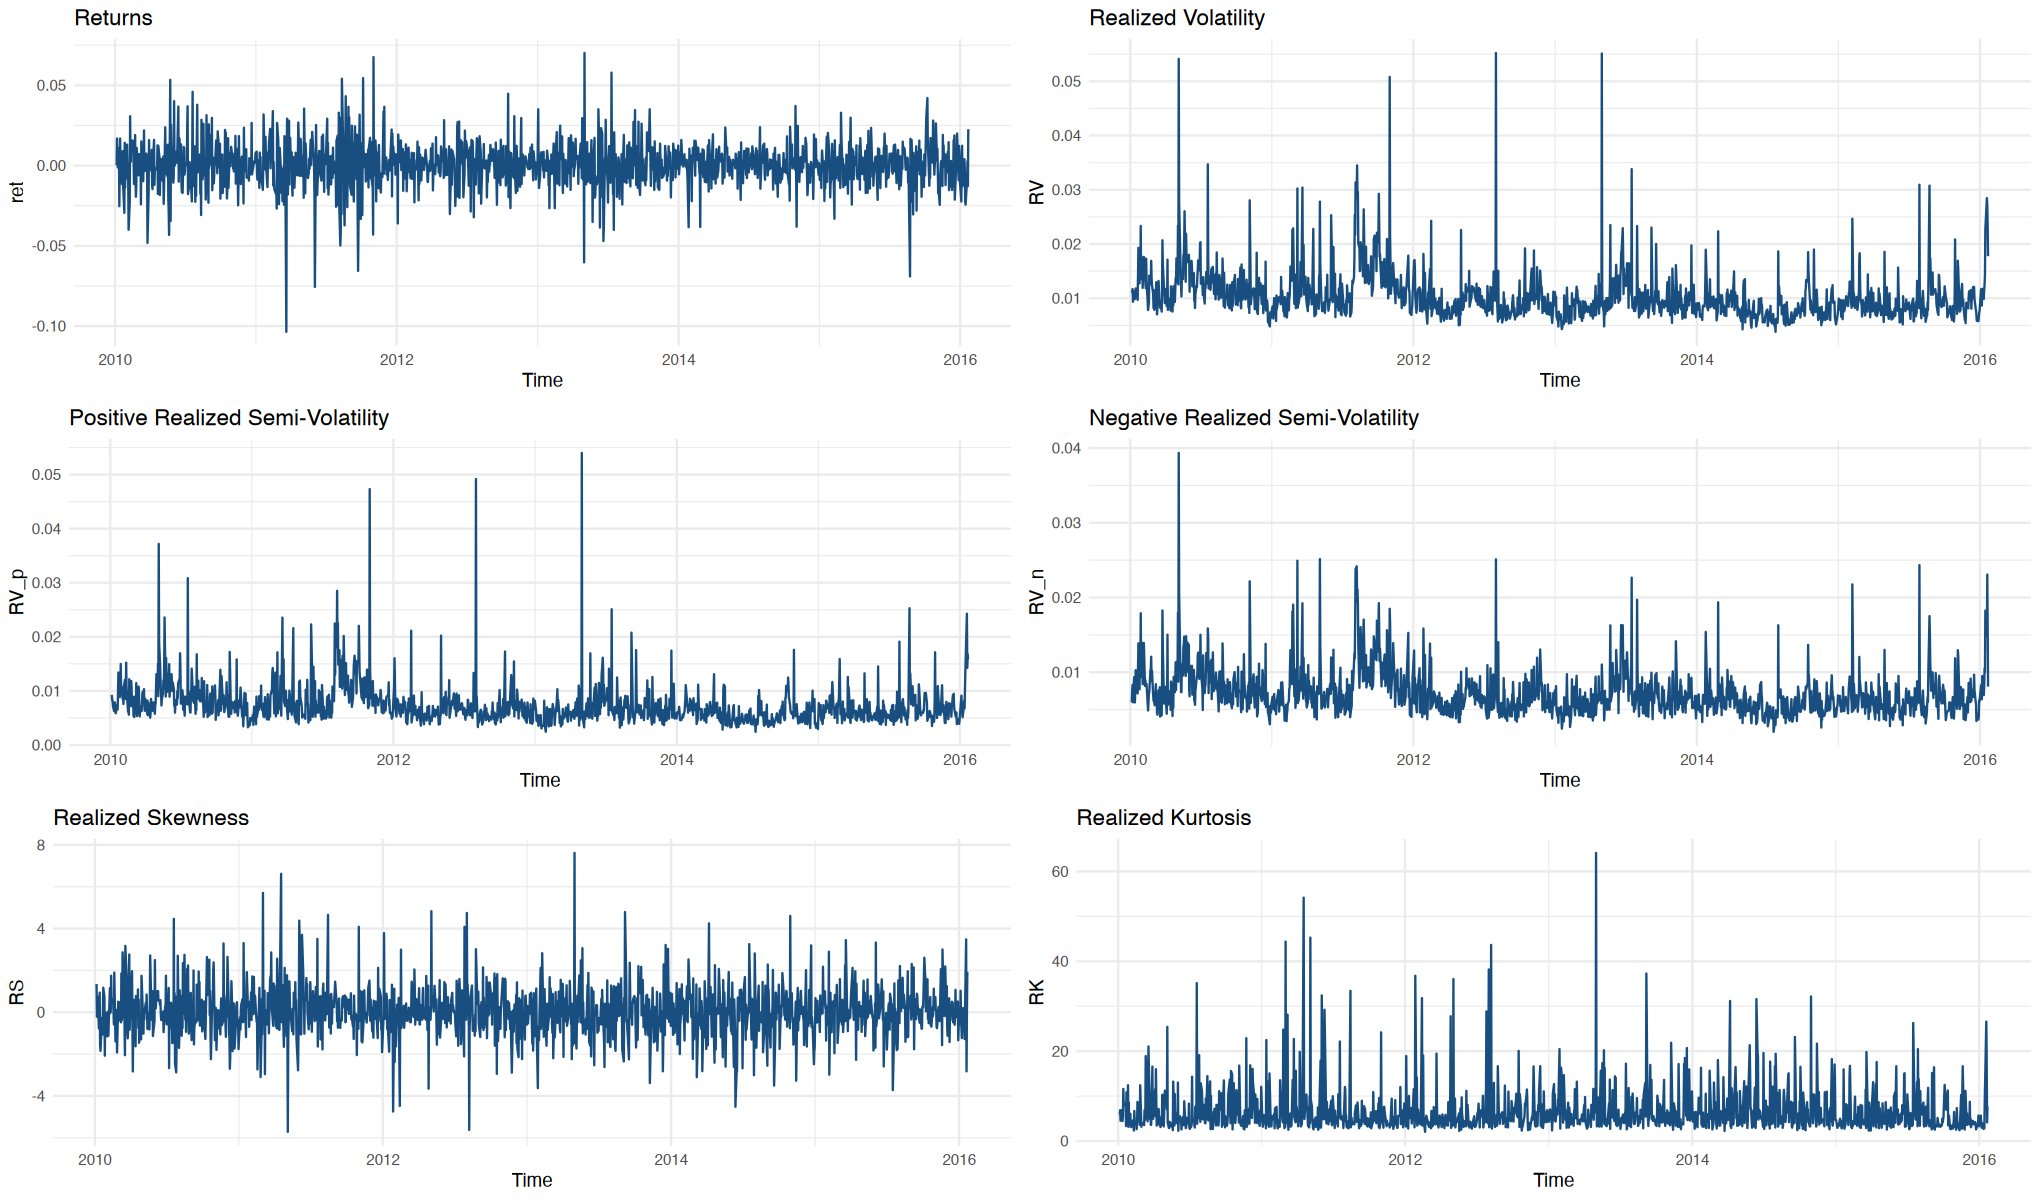

In [4]:
plot_dta = function(column, title) {
  ggplot(amt, aes(x = index(amt), y = get(column))) +
    geom_line(color =  "#194f80") +
    labs(title = title, x = "Time", y = column) +
    theme_minimal()
}

# Assign variables and column names
plots = list()
titles = c("Returns", "Realized Volatility", "Positive Realized Semi-Volatility",
            "Negative Realized Semi-Volatility", "Realized Skewness", "Realized Kurtosis")

# Loop over each variables to create time series plots iteratively
for (i in seq_along(names(amt))) {
  plots[[i]] = plot_dta(names(amt)[i], titles[i])
}
options(repr.plot.width = 17, repr.plot.height = 10)
grid.arrange(grobs = plots, ncol = 2, nrow = 3)

We plotted the Returns, Realized Volatility, Positive Realized Semi-Volatility, Negative Realized Semi-Volatility, Realized Skewness, and Realized Kurtosis above. Plotting the Returns indicates a mean around zero and changes in volatility over time with high-volatility clusters around mid-2010, mid-2011, mid-2013, and mid-2015. These high-volatility clusters are also shown by the Realized Volatility plot, where the Realized Volatility peaks roughly coincide with the high-volatility clusters in the Returns plot, the RV plot also shows several jumps. Positive and Negative Semi-Realized Volatility seem to be closely related to the Realized Volatility plot, due to their mathematical definition of either only considering positive or negative returns. Realized Skewness and Kurtosis also vary over time.

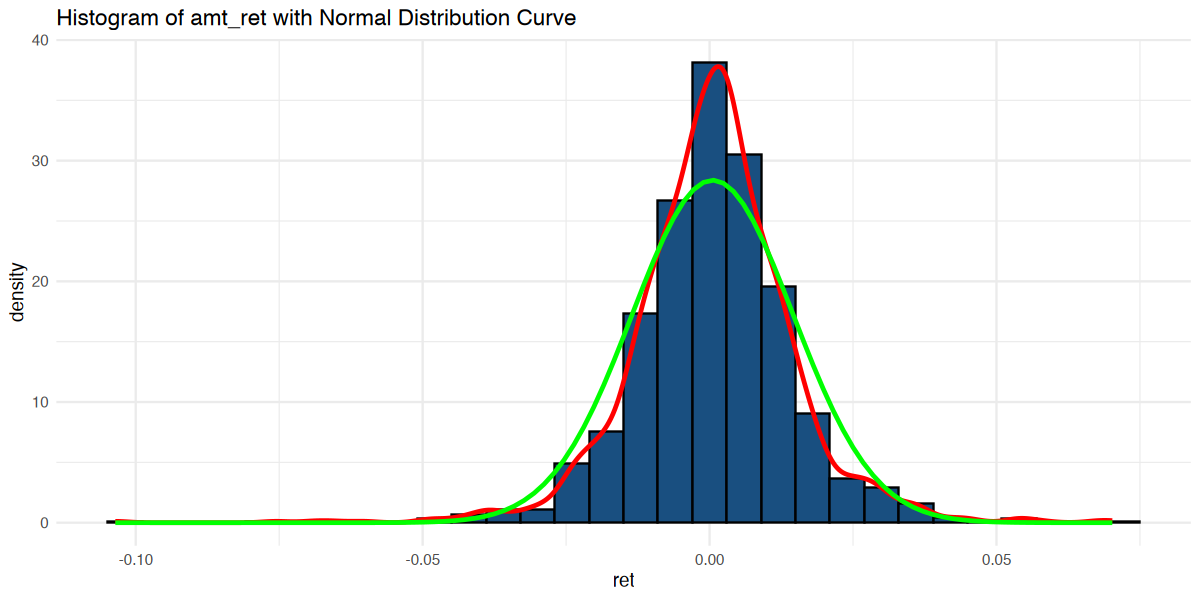

In [5]:
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(amt, aes(x = ret)) +
    geom_histogram(aes(y = after_stat(density)), fill = "#194f80", bins = 30, color = "black") +
    geom_density(color = "red", linewidth = 1) +
    stat_function(fun = dnorm, args = list(mean = mean(amt$ret, na.rm = TRUE), sd = sd(amt$ret, na.rm = TRUE)), color = "green", linewidth = 1) +
    ggtitle("Histogram of amt_ret with Normal Distribution Curve") +
    theme_minimal()

The green curve is a normal distribution pdf that would correspond to the sample mean and sd of the of the returns. Clearly, the red line, which estimates the return density, exerts a much higher kurtosis, commonly observed with stock returns.

### Plot the autocorrelation (ACF) and partial-autocorrelation (PACF) functions 

Warning message in adf.test(amt$ret):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  amt$ret
Dickey-Fuller = -12.231, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary


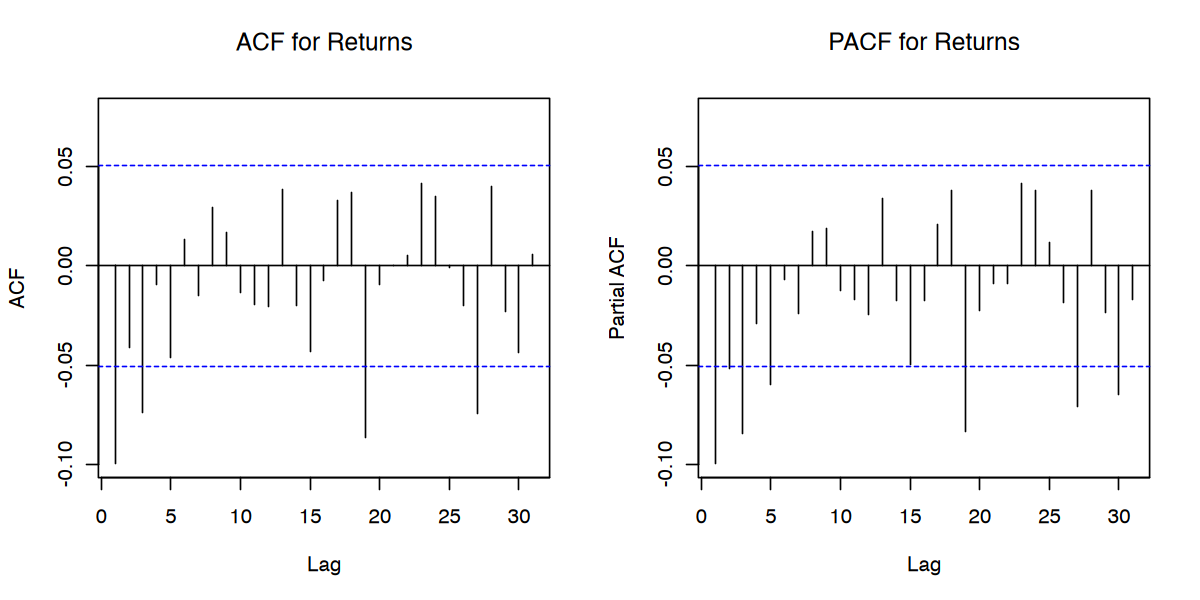

In [6]:
# Plot ACF and PACF functions for Returns
options(repr.plot.width = 10, repr.plot.height = 5)
par(mfrow = c(1, 2))
Acf(amt$ret, main="ACF for Returns")
Pacf(amt$ret, main="PACF for Returns")
adf.test(amt$ret)

The ACF show four statistically significant autocorrelations at lag 1, 3, 18, and 27. The PACF shows seven statistically significant partial autocorrelations at lag 1, 2, 3, 5, 18,  27, and 30. This suggests that the return series is not white noise and there are some significant (partial) autocorrelations, indicating that the series has some predictability based on past values. The $H_0$ of the adf test is rejected, suggesting the series is stationary. 

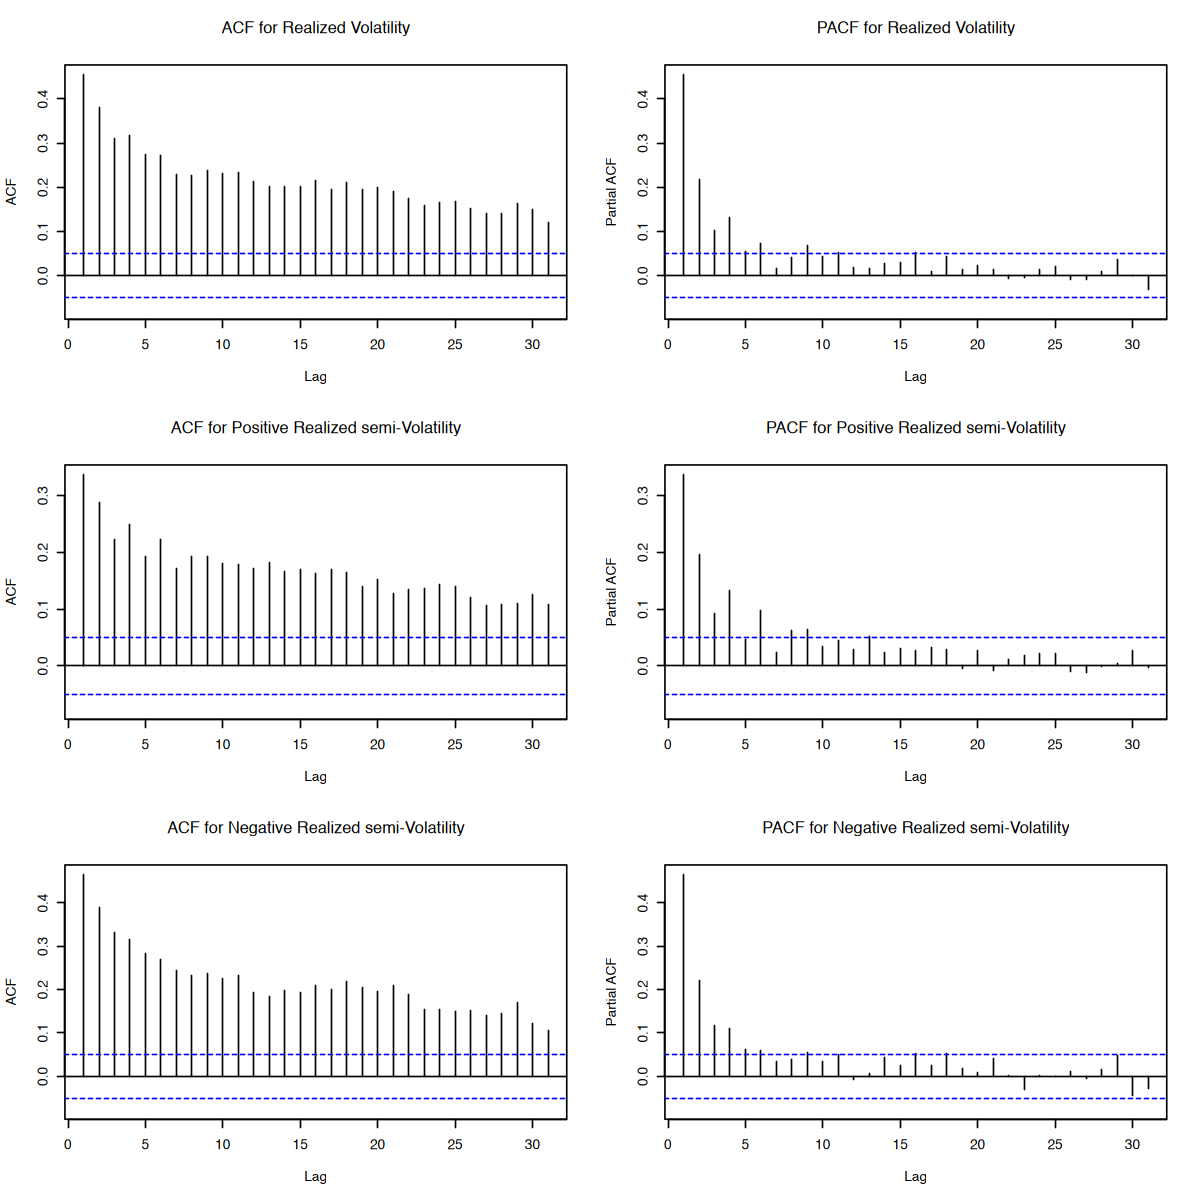

In [7]:
# Plot ACF, and PACF of Realized Volatility variables
par(mfrow = c(3, 2))
options(repr.plot.width = 10, repr.plot.height = 10)
Acf(amt$RV, main="ACF for Realized Volatility")
Pacf(amt$RV, main="PACF for Realized Volatility")
Acf(amt$RV_p, main="ACF for Positive Realized semi-Volatility")
Pacf(amt$RV_p, main="PACF for Positive Realized semi-Volatility")
Acf(amt$RV_n, main="ACF for Negative Realized semi-Volatility")
Pacf(amt$RV_n, main="PACF for Negative Realized semi-Volatility")

Realized Volatility, Positive Realized Semi-Volatility, and Negative Realized Semi-Volatility have similar ACF and PACF functions. The ACF for all three variables is slowly decaying, which could possibly indicate non-stationarity; however we do reject the H_0 of the `adf.test` below. Furthermore, the PACFs show statistically significant partial autocorrelations, but the decay is much faster, indicating that the series could possibly follow some AR process.

In [8]:
adf.test(amt$RV)
adf.test(amt$RV_n)
adf.test(amt$RV_p)

Warning message in adf.test(amt$RV):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  amt$RV
Dickey-Fuller = -6.5222, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary


Warning message in adf.test(amt$RV_n):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  amt$RV_n
Dickey-Fuller = -6.7825, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary


Warning message in adf.test(amt$RV_p):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  amt$RV_p
Dickey-Fuller = -6.8486, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary


# 3) In-sample fit

## (a) AR(1)-RV

$$RV_t = \phi_0 + \phi_1 RV_{t-1} + \epsilon_t$$

where:
- $RV_t$ is the realized volatility at time \( t \),
- $\phi_0$ is the intercept,
- $ \phi_1 $ is the coefficient of lag 1 of realized volatility,
- $ \epsilon_t $ is the error term, assumed to be normally distributed white noise.

In [9]:
# Fit the AR(1)-RV model
rv_ar1_fit = Arima(amt$RV, order=c(1,0,0))
rv_ar1_fit

Series: amt$RV 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
        ar1    mean
      0.456  0.0105
s.e.  0.023  0.0002

sigma^2 = 1.759e-05:  log likelihood = 6083.53
AIC=-12161.07   AICc=-12161.05   BIC=-12145.13

Our estimated coefficient for lag 1 Realized Volatility is 0.456 with a standard error of 0.023, indicating a positive relationship between the lagged and current values. The estimated intercept is 0.015 with a standard error of 0.0002. Both estimates are statistically significant.

           rv_ar1_fit_val
2010-01-05    0.010573280
2010-01-06    0.010742866
2010-01-07    0.010831030
2010-01-08    0.011057337
2010-01-11    0.009992136
2010-01-12    0.010850630

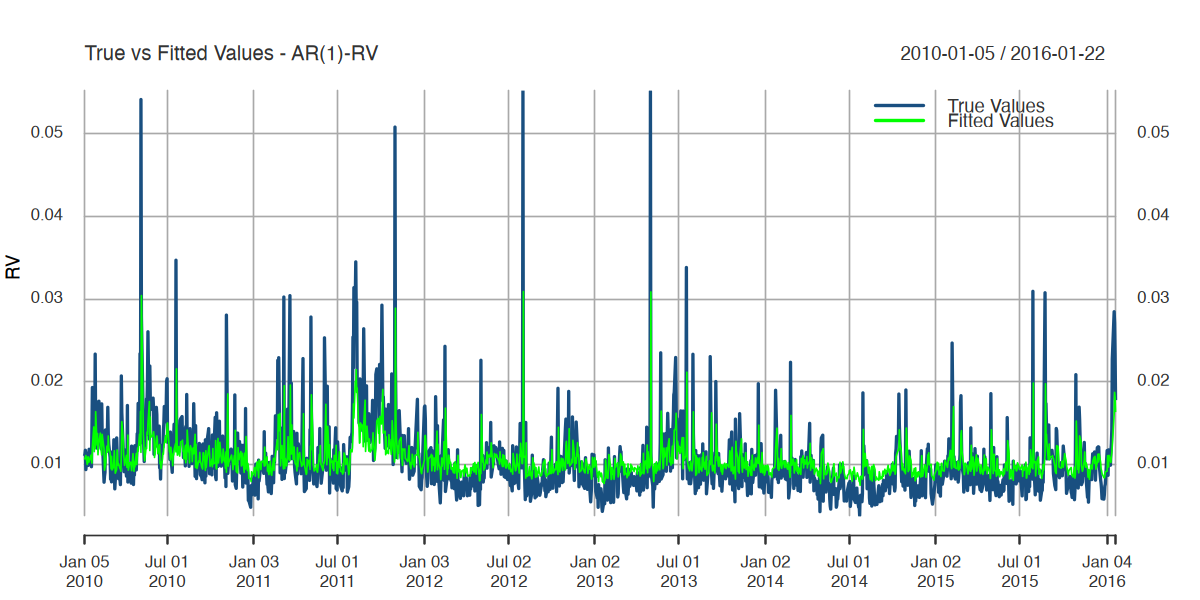

In [10]:
# Plot the true versus AR(1)-RV fitted values
options(repr.plot.width = 10, repr.plot.height = 5)
amt$rv_ar1_fit_val = xts(fitted(rv_ar1_fit), order.by = index(amt))
head(amt$rv_ar1_fit_val)

plot_rv_ar = plot(amt$RV, type = 'l', col = "#194f80", lwd = 2, xlab = "Time", ylab = "RV", main = "True vs Fitted Values - AR(1)-RV")
plot_rv_ar = lines(amt$rv_ar1_fit_val, col = "green", lwd = 1)
plot_rv_ar = addLegend("topright", legend.names = c("True Values", "Fitted Values"), col = c("#194f80", "green"), lty = 1, lwd = 2)
plot_rv_ar

Here, we plot the true values against the AR(1)-RV fitted values. The graph indicates a discrepancy between the true and fitted values. Specifically, it seems that the AR(1)-RV model overestimates the volatility, while not capturing the jumps and the more detailed structure of the realized volatility; however it is able to capture the general pattern and approximate magnitude.

## (b) Heterogeneous Autoregressive Model

$$RV_t = \alpha + \beta_1 RV_{t-1} + \beta_2 RV_{t-1}^{(5)} + \beta_3 RV_{t-1}^{(22)} + u_t.$$

where:
- $RV_t$ is the daily realized volatility at time \( t \),
- $RV_{t}^{(5)}$ is the weekly realized volatility at time \( t \),
- $RV_{t}^{(22)}$ is the monthly realized volatility at time \( t \),
- $\alpha$ is the intercept,
- $ \beta_1 $ is the coefficient of lag 1 of daily realized volatility,
- $ \beta_2 $ is the coefficient of lag 1 of weekly realized volatility,
- $ \beta_3 $ is the coefficient of lag 1 of monthly realized volatility,
- $ u_t $ is the error term, assumed to be normally distributed white noise.

In [11]:
# Fit the HAR model and print estimates
HAR_fit = HARmodel(data = amt$RV , periods = c(1,5,22))

summary(HAR_fit)


Call:
"RV1 = beta0  +  beta1 * RV1 +  beta2 * RV5 +  beta3 * RV22"

Residuals:
      Min        1Q    Median        3Q       Max 
-0.012629 -0.002062 -0.000618  0.001081  0.045830 

Coefficients:
       Estimate Std. Error t value Pr(>|t|)    
beta0 0.0018621  0.0003657   5.092 4.01e-07 ***
beta1 0.2298062  0.0474828   4.840 1.44e-06 ***
beta2 0.2777390  0.0796523   3.487 0.000503 ***
beta3 0.3155588  0.0893409   3.532 0.000425 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.004013 on 1474 degrees of freedom
Multiple R-squared:  0.2775,	Adjusted R-squared:  0.276 
F-statistic: 188.7 on 3 and 1474 DF,  p-value: < 2.2e-16


In [12]:
# Show the estimated coefficient and significance levels manually
amt$RV_1 = lag(amt$RV)
amt$RV_5 =  lag(rollapply(amt$RV, width = 5, FUN = mean, fill = NA, align = "right"))
amt$RV_22 =  lag(rollapply(amt$RV, width = 22, FUN = mean, fill = NA, align = "right"))
har_manual = lm(RV ~ RV_1 + RV_5 + RV_22, data = amt)
coeftest(har_manual, vcov = NeweyWest(har_manual, lag = 22))


t test of coefficients:

              Estimate Std. Error t value  Pr(>|t|)    
(Intercept) 0.00186209 0.00036572  5.0916 4.008e-07 ***
RV_1        0.22980621 0.04748279  4.8398 1.436e-06 ***
RV_5        0.27773900 0.07965227  3.4869  0.000503 ***
RV_22       0.31555884 0.08934093  3.5321  0.000425 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


All coefficients for the HAR model are statistically significant and positive, indicating that the lagged average monthly and weekly realized volatility are also useful for the modelling.

In [13]:
head(xts(fitted(HAR_fit), order.by = as.Date(names(fitted(HAR_fit)))))

                 [,1]
2010-02-05 0.01361216
2010-02-08 0.01442904
2010-02-09 0.01360447
2010-02-10 0.01328010
2010-02-11 0.01295733
2010-02-12 0.01441048

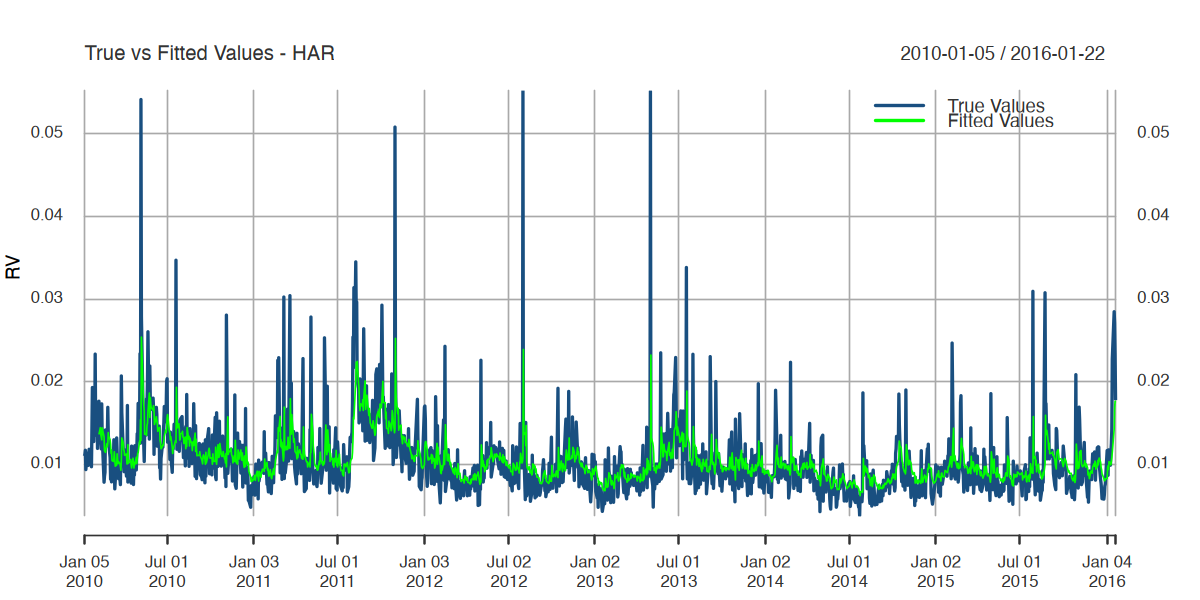

In [14]:
amt$HAR_fit_val = xts(fitted(HAR_fit),  order.by = as.Date(names(fitted(HAR_fit))))

plot_HAR = plot(amt$RV, type = 'l', col = "#194f80", lwd = 2, xlab = "Time", ylab = "RV", main = "True vs Fitted Values - HAR")
plot_HAR = lines(amt$HAR_fit_val, col = "green", lwd = 1)
plot_HAR = addLegend("topright", legend.names = c("True Values", "Fitted Values"), col = c("#194f80", "green"), lty = 1, lwd = 2)
plot_HAR

Here, we plot the true versus fitted HAR values. The fit appears quite similar to before, but it seems that the HAR estimates better fits the data than the AR(1)-RV model. Specifically, it seems from the figure that the HAR model does not overestimate mean volatility as strongly as the AR(1)-RV model.

## (c) Heterogeneous Autoregressive Model with Realized Semi-volatility

$$RV_t = \alpha  + \beta_1 RS^+_{t-1} + \beta_2 RS^-_{t-1} +\beta_3 RV_{t-1}^{(5)} + \beta_4 RV_{t-1}^{(22)} +u_t.$$

where:
- $RV_t$ is the daily realized volatility at time \( t \),
- $RS^+_{t} $ is the daily positive realized semi-volatility at time \( t \),
- $RS^-_{t}$ is the daily negative realized semi-volatility at time \( t \),
- $RV_{t}^{(5)}$ is the weekly realized volatility at time \( t \),
- $RV_{t}^{(22)}$ is the monthly realized volatility at time \( t \),
- $\alpha$ is the intercept,
- $ \beta_1 $ is the coefficient of lag 1 of daily positive realized semi-volatility,
- $ \beta_2 $ is the coefficient of lag 1 of daily positive realized semi-volatility,
- $ \beta_3 $ is the coefficient of lag 1 of weekly realized volatility,
- $ \beta_4 $ is the coefficient of lag 1 of monthly realized volatility,
- $ u_t $ is the error term, assumed to be normally distributed white noise.

In [15]:
amt$RV_p_l = lag(amt$RV_p)
amt$RV_n_l = lag(amt$RV_n)
har_rs_fit = lm(RV ~ RV_p_l + RV_n_l + RV_5 + RV_22, data = amt)
coeftest(har_rs_fit, vcov = NeweyWest(har_rs_fit, lag = 22))


t test of coefficients:

              Estimate Std. Error t value  Pr(>|t|)    
(Intercept) 0.00172761 0.00036179  4.7752 1.974e-06 ***
RV_p_l      0.03473701 0.03482037  0.9976 0.3186342    
RV_n_l      0.37126020 0.07133673  5.2043 2.222e-07 ***
RV_5        0.24759172 0.07752767  3.1936 0.0014349 ** 
RV_22       0.30761444 0.08464799  3.6340 0.0002886 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [16]:
linearHypothesis(har_rs_fit, "RV_p_l = RV_n_l") # 

Res.Df RSS        Df Sum of Sq    F        Pr(>F)      
1 1474   0.02365038 NA           NA       NA           NA
2 1473   0.02331648  1 0.0003339057 21.09423 4.745098e-06

Previously we estimated a positive coefficient for the $RV_{t-1}$, while only the coefficient on the negative realized semivolatility is statistically significant here. It seems that $\hat{\beta_1} \neq \hat{\beta_2}$, hence we were able to get new information from using semi-volatilities. We can see that all estimates except the one of $\beta_1$ are statistically significant and postive. The fact that the negative semi-volatility appears to have a larger impact than the positive one is in line with the theory that the reaction to "bad news" is stronger.

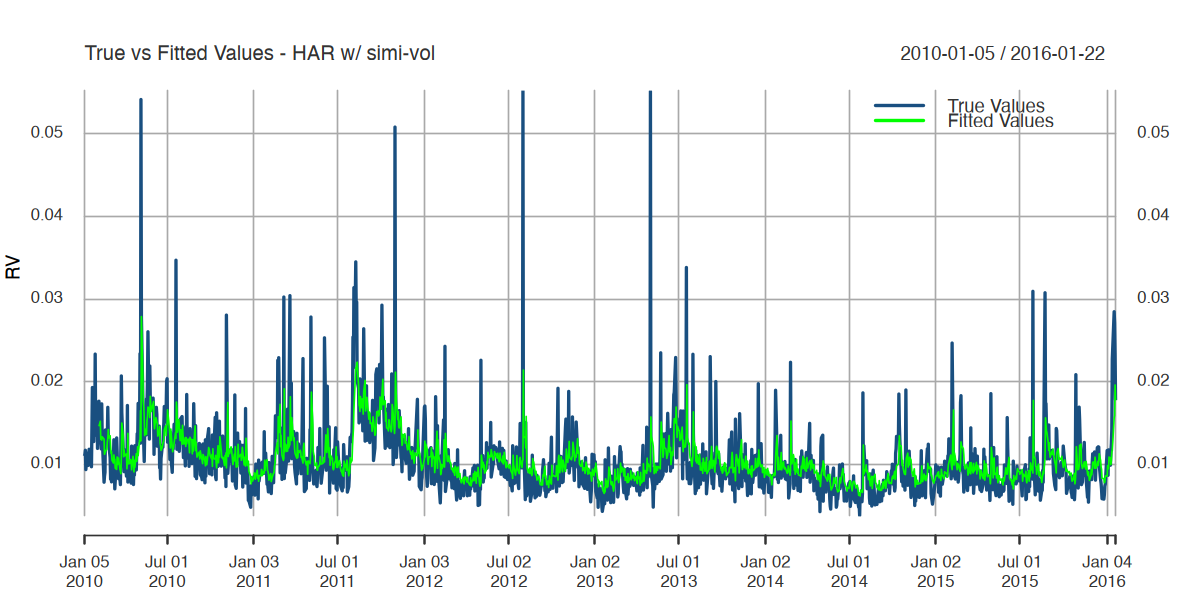

In [17]:
# Plot the true versus fitted values of HAR with semi-realized volatility 
amt$HAR_semi_fit_val = xts(fitted(har_rs_fit),  order.by = as.Date(names(fitted(har_rs_fit))))

plot_HAR_semi = plot(amt$RV, type = 'l', col = "#194f80", lwd = 2, xlab = "Time", ylab = "RV", main = "True vs Fitted Values - HAR w/ simi-vol")
plot_HAR_semi = lines(amt$HAR_semi_fit_val, col = "green", lwd = 1)
plot_HAR_semi = addLegend("topright", legend.names = c("True Values", "Fitted Values"), col = c("#194f80", "green"), lty = 1, lwd = 2)
plot_HAR_semi

The plot appears similar to before. We will also observe the differences when we plot the fitted values of all the models in one graph.

## (d) Heterogeneous Autoregressive Model with Realized Skewness and Kurtosis

$$RV_t = \alpha  + \beta_1 RV{t-1} + \beta_2 RV_{t-1}^{(5)} + \beta_3 RV_{t-1}^{(22)} + \beta_4 RKurt_{t-1} + \beta_5 RSkew_{t-1} + u_t.$$

where:
- $RV_t$ is the daily realized volatility at time \( t \),
- $RV_{t}^{(5)}$ is the weekly realized volatility at time \( t \),
- $RV_{t}^{(22)}$ is the monthly realized volatility at time \( t \),
- $RKurt_{t} $ is the daily realized kurtosis at time \( t \),
- $RSkew_{t}$ is the daily realized skewness at time \( t \),
- $\alpha$ is the intercept,
- $ \beta_1 $ is the coefficient of lag 1 of daily realized volatility,
- $ \beta_2 $ is the coefficient of lag 1 of weekly realized volatility,
- $ \beta_3 $ is the coefficient of lag 1 of monthly realized volatility,
- $ \beta_4 $ is the coefficient of lag 1 of dailty realized kurtosis,
- $ \beta_5 $ is the coefficient of lag 1 of dailty realized skewness,
- $ u_t $ is the error term, assumed to be normally distributed white noise.

In [18]:
# Estimate the HAR with Realized Skewness and Kurtosis 
amt$RS_l = lag(amt$RS)
amt$RK_l = lag(amt$RK)
har_rsk_rkurt_fit = lm(RV ~ RV_1 + RV_5 + RV_22 + RS_l + RK_l, data = amt)
coeftest(har_rsk_rkurt_fit, vcov = NeweyWest(har_rsk_rkurt_fit, lag = 22))


t test of coefficients:

               Estimate  Std. Error t value  Pr(>|t|)    
(Intercept)  2.5702e-03  3.6358e-04  7.0693 2.396e-12 ***
RV_1         3.1487e-01  5.2423e-02  6.0064 2.387e-09 ***
RV_5         2.4407e-01  7.3900e-02  3.3027 0.0009804 ***
RV_22        2.6958e-01  8.6922e-02  3.1014 0.0019626 ** 
RS_l        -1.2198e-04  8.4773e-05 -1.4389 0.1503777    
RK_l        -1.1444e-04  2.7186e-05 -4.2096 2.713e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [26]:
# Create new variables based on the condition
amt$RS_l_neg <- ifelse(amt$RS_l <= 0,1, 0)
amt$RS_l_pos <- ifelse(amt$RS_l > 0, 1, 0)

# Fit the regression model with the new variables
har_rsk_rkurt_fit2 <- lm(RV ~ RV_1 + RV_5 + RV_22 + RS_l_neg + RK_l, data = amt)
summary(har_rsk_rkurt_fit2)


Call:
lm(formula = RV ~ RV_1 + RV_5 + RV_22 + RS_l_neg + RK_l, data = amt)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.012104 -0.001977 -0.000636  0.001022  0.045986 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.475e-03  4.641e-04   5.333 1.12e-07 ***
RV_1         3.110e-01  3.399e-02   9.149  < 2e-16 ***
RV_5         2.489e-01  5.712e-02   4.357 1.41e-05 ***
RV_22        2.668e-01  6.137e-02   4.346 1.48e-05 ***
RS_l_neg     2.533e-04  2.072e-04   1.222    0.222    
RK_l        -1.168e-04  2.202e-05  -5.305 1.30e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003976 on 1472 degrees of freedom
  (22 observations deleted due to missingness)
Multiple R-squared:  0.2919,	Adjusted R-squared:  0.2895 
F-statistic: 121.4 on 5 and 1472 DF,  p-value: < 2.2e-16


In our case, we do not have a statistically significant estimate for realized skewness. The results indicate that larger kurtosis in previous period should on average lead to lower values of $RV$. This might be a bit of an unexpected result since fatter tails mean higher risk which we would associate with higher volatility.

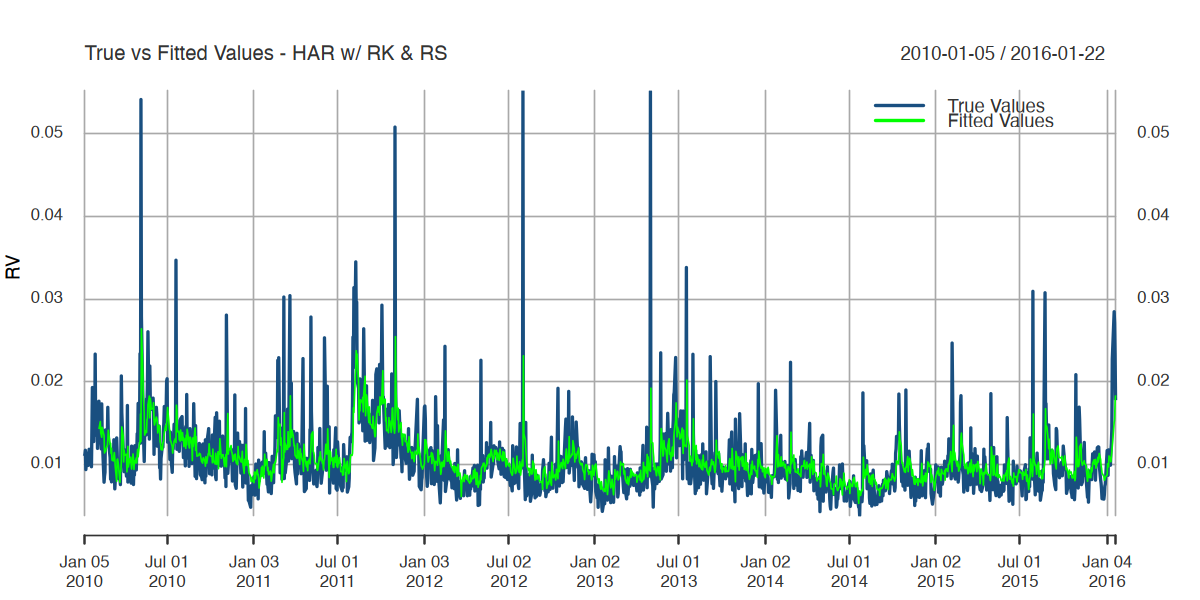

In [19]:
# Plot the true versus fitted values of the HAR with Realized Skewness and Kurtosis
amt$HAR_rs_rk_fit_val = xts(fitted(har_rsk_rkurt_fit),  order.by = as.Date(names(fitted(har_rsk_rkurt_fit))))

plot_HAR_rk_rs = plot(amt$RV, type = 'l', col = "#194f80", lwd = 2, xlab = "Time", ylab = "RV", main = "True vs Fitted Values - HAR w/ RK & RS")
plot_HAR_rk_rs = lines(amt$HAR_rs_rk_fit_val, col = "green", lwd = 1)
plot_HAR_rk_rs = addLegend("topright", legend.names = c("True Values", "Fitted Values"), col = c("#194f80", "green"), lty = 1, lwd = 2)
plot_HAR_rk_rs

## (e) Realized GARCH

$
\begin{align}
r_t= & \mu_t + \sqrt{h_t}z_t \\
ln(h_t)= & \omega + \beta ln(h_{t-1})+\gamma ln(RV_{t-1})\\
ln(RV_t)= & \xi+ \delta ln(h_t) + u_t
\end{align}
$

where: 
- $z_t$ is a normally distributed iid N(0,1)
- $h_t$ is conditional variance at time ( t )
- $RV_t$ is realized variance at time ( t )
- $ u_t $ is the error term, assumed to be normally distributed.

Series: amt$ret 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
         ar1      ma1   mean
      0.6467  -0.7596  5e-04
s.e.  0.0950   0.0813  2e-04

sigma^2 = 0.0001936:  log likelihood = 4285.44
AIC=-8562.88   AICc=-8562.85   BIC=-8541.62

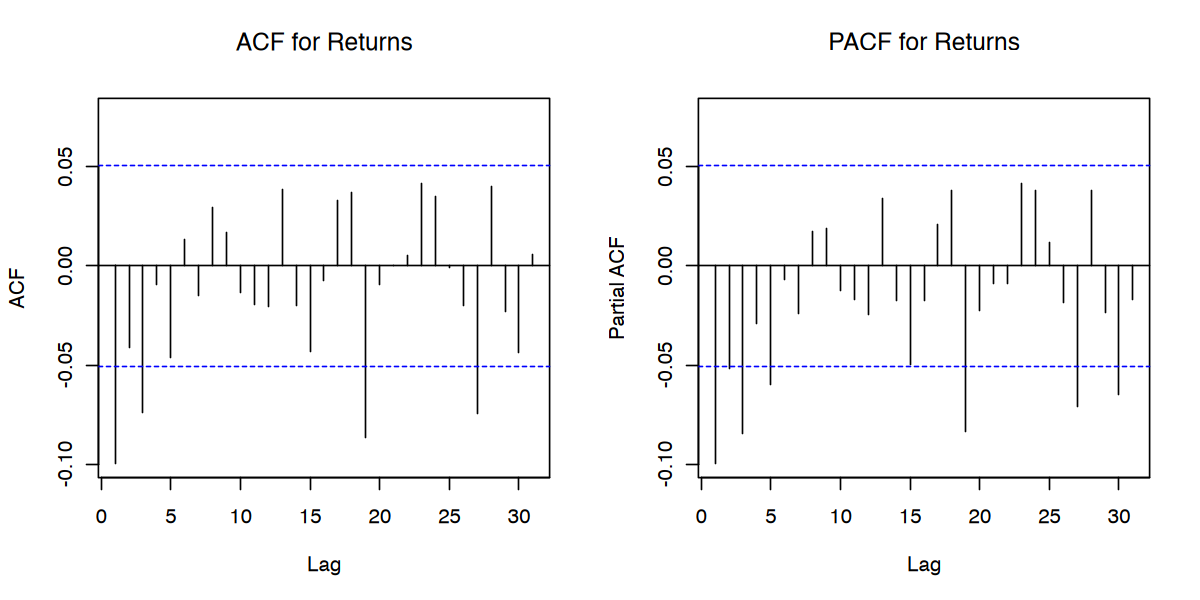

In [20]:
# Plot the ACF and PACF for the returns
options(repr.plot.width = 10, repr.plot.height = 5)
par(mfrow = c(1, 2))
Acf(amt$ret, main="ACF for Returns")
Pacf(amt$ret, main="PACF for Returns")
auto.arima(amt$ret)

In [21]:
# Estimate the Realized GARCH model with GARCH order 1,1 and ARMA order 0,0. 
real_garchspec= ugarchspec(variance.model = list(model = 'realGARCH', garchOrder = c(1, 1)),
    mean.model = list(armaOrder=c(0, 0), include.mean=TRUE), distribution.model = "std")
real_garch_fit= ugarchfit(real_garchspec, amt$ret, solver = 'hybrid', realizedVol = amt$RV)  
real_garch_fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: realGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000546    0.000277   1.9698 0.048858
omega   0.774265    0.337744   2.2925 0.021879
alpha1  1.000000    0.154426   6.4756 0.000000
beta1   0.562152    0.056547   9.9413 0.000000
eta11  -0.036534    0.007148  -5.1111 0.000000
eta21   0.026999    0.003208   8.4169 0.000000
delta   0.337887    0.026777  12.6187 0.000000
lambda  0.264883    0.004880  54.2758 0.000000
shape   7.711485    1.321290   5.8363 0.000000
xi     -1.653348    0.233836  -7.0705 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000546    0.000237   2.2993 0.021488
omega   0.774265    0.487580   1.5880 0.112292
alpha1

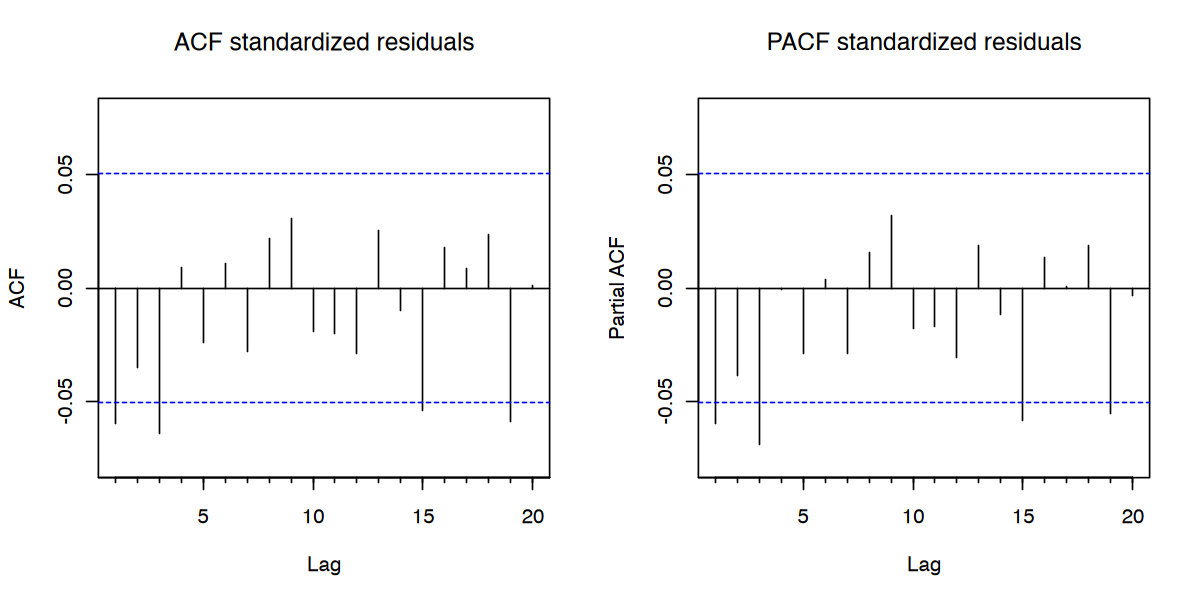

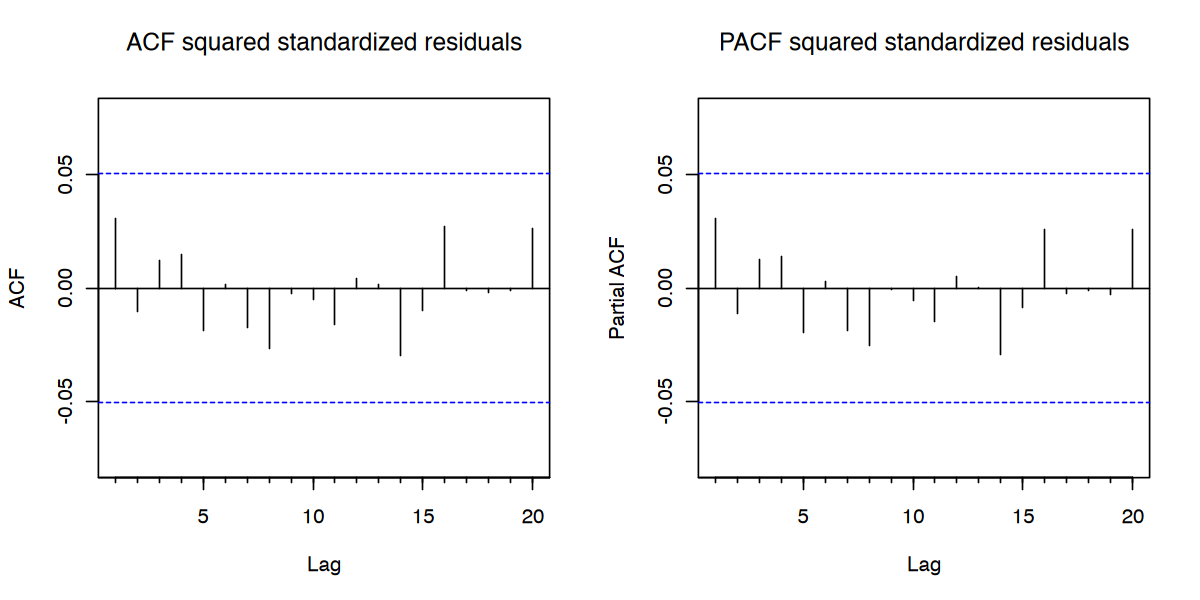

In [22]:
# Plot acf and pacf of the residuals
res = residuals(real_garch_fit, standardize = TRUE)
sqr_res = residuals(real_garch_fit, standardize = TRUE)^2
options(repr.plot.width = 10, repr.plot.height = 5)
par(mfrow = c(1,2))
Acf(res, lag.max = 20, main="ACF standardized residuals")
Pacf(res, lag.max = 20, main="PACF standardized residuals")

par(mfrow = c(1,2))
Acf(sqr_res, lag.max = 20, main="ACF squared standardized residuals")
Pacf(sqr_res, lag.max = 20, main="PACF squared standardized residuals")

After plotting the residuals we can see that the ACF and PACF still exhibit statistically significant autocorrelation for the standardized residuals, the Weighted Ljung-Box Test on Standardized Residuals in the GARCH output also supports this. Therefore, we decide to reestimate the Realized GARCH model by adding ARMA of order (1,1) as the mean model. 

In [23]:
# Re-estimate Realized GARCH with order (1,1) and ARMA order (1,1).
real_garchspec= ugarchspec(variance.model = list(model = 'realGARCH', garchOrder = c(1, 1)),
    mean.model = list(armaOrder=c(1, 1), include.mean=TRUE), distribution.model = "std")
real_garch_fit= ugarchfit(real_garchspec, amt$ret, solver = 'hybrid', realizedVol = amt$RV)  
real_garch_fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: realGARCH(1,1)
Mean Model	: ARFIMA(1,0,1)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000614    0.000222   2.7705 0.005597
ar1     0.564222    0.135101   4.1763 0.000030
ma1    -0.650770    0.123916  -5.2517 0.000000
omega   0.733709    0.346462   2.1177 0.034199
alpha1  1.000000    0.156955   6.3712 0.000000
beta1   0.558088    0.056818   9.8224 0.000000
eta11  -0.038538    0.007165  -5.3787 0.000000
eta21   0.026184    0.003154   8.3020 0.000000
delta   0.339895    0.027810  12.2219 0.000000
lambda  0.264784    0.004885  54.2045 0.000000
shape   7.635044    1.283187   5.9501 0.000000
xi     -1.632150    0.243184  -6.7116 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu    

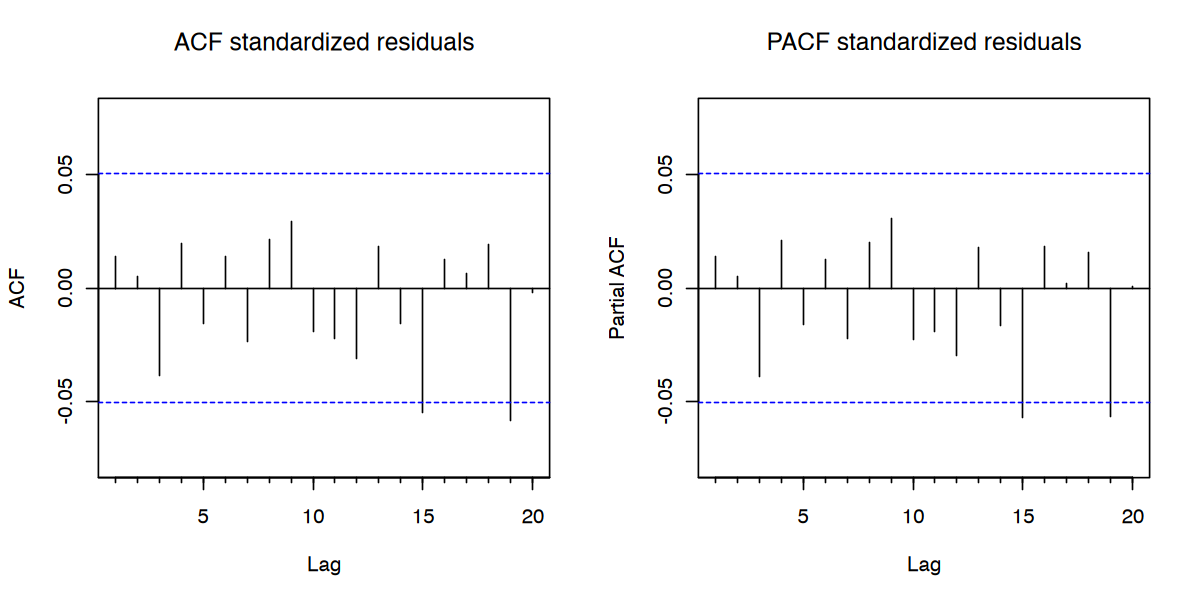

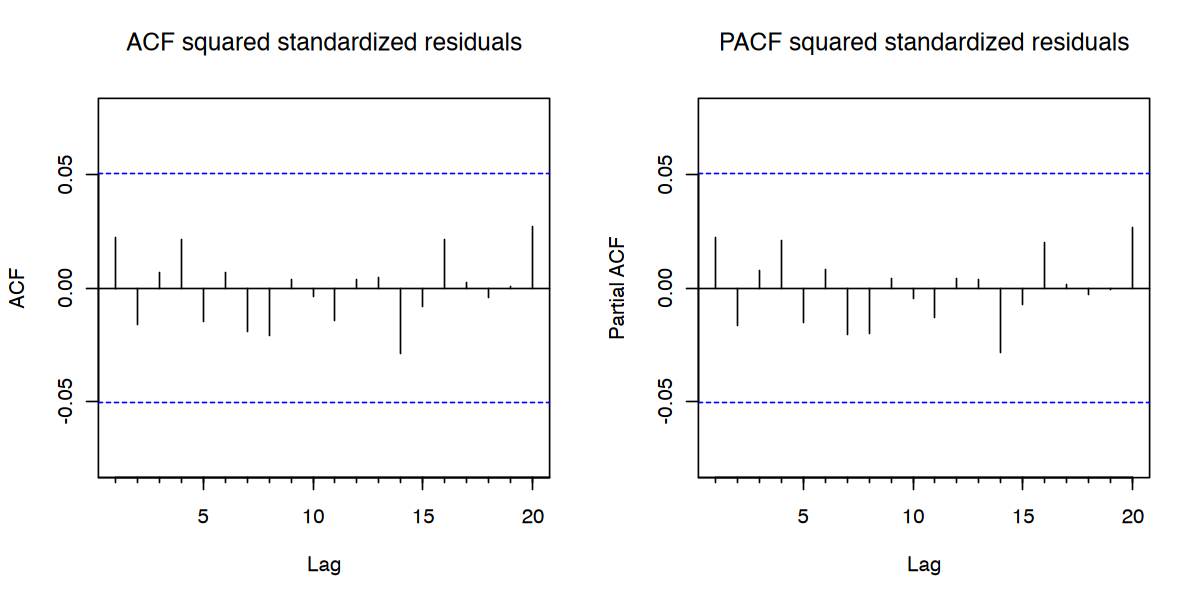

In [24]:
# Plot acf and pacf of the residuals
res = residuals(real_garch_fit, standardize = TRUE)
sqr_res = residuals(real_garch_fit, standardize = TRUE)^2
options(repr.plot.width = 10, repr.plot.height = 5)
par(mfrow = c(1,2))
Acf(res, lag.max = 20, main="ACF standardized residuals")
Pacf(res, lag.max = 20, main="PACF standardized residuals")

par(mfrow = c(1,2))
Acf(sqr_res, lag.max = 20, main="ACF squared standardized residuals")
Pacf(sqr_res, lag.max = 20, main="PACF squared standardized residuals")

After re-estimating the model and examining the autocorrelations, we can see that the ACF and PACF plots exhibit only minimal autocorrelation in the standarized residuals. Since the autocorrelations at lags 15 and 19 are at the borderline of being statistically significant, we conclude that the model is reasonably well specified, and we would probably not be able to find a parsimonous model that would get rid of these dependencies. 

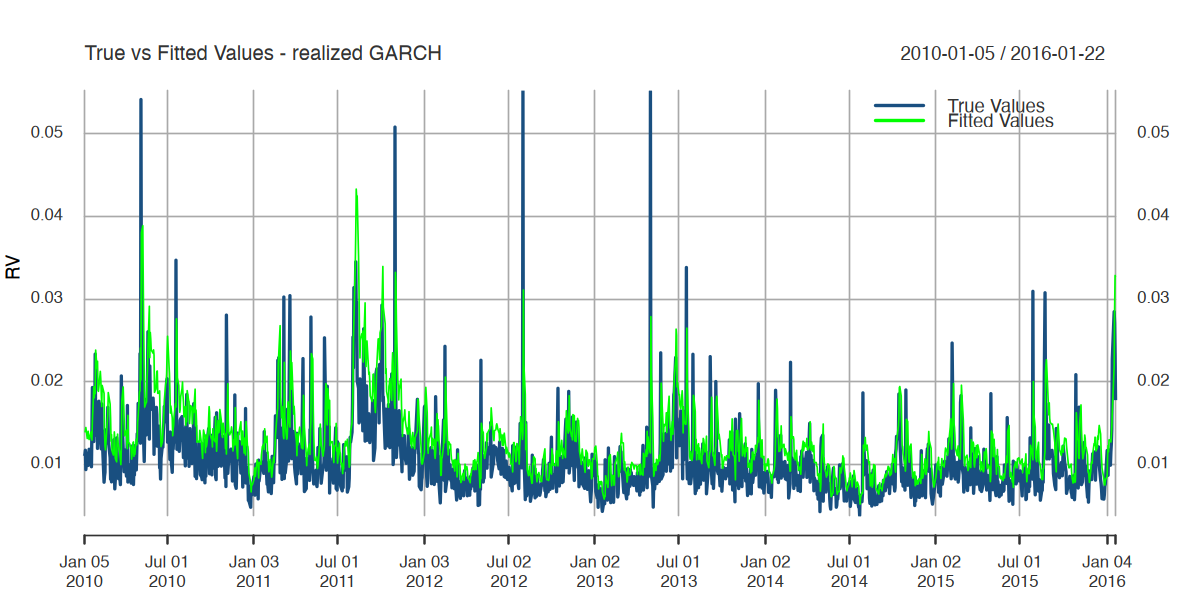

In [25]:
# Plot the true versus fitted values.
amt$real_garch_fit_val = sigma(real_garch_fit)

options(repr.plot.width = 10, repr.plot.height = 5)
plot_real_garch = plot(amt$RV, type = 'l', col = "#194f80", lwd = 2, xlab = "Time", ylab = "RV", main = "True vs Fitted Values - realized GARCH")
plot_real_garch = lines(amt$real_garch_fit_val, col = "green", lwd = 1)
plot_real_garch = addLegend("topright", legend.names = c("True Values", "Fitted Values"), col = c("#194f80", "green"), lty = 1, lwd = 2)
plot_real_garch

We can see that the volatility is consistantly overestimated by the realGARCH model.

## (f) ARMA-GARCH

$
\begin{align}
r_t = & \phi_0 + \sum_{i=1}^p \phi_i r_{t-i} + \sum_{j=1}^q \theta_j \epsilon_{t-j} + \epsilon_t, \\
\epsilon_t = & \sigma_t z_t, \quad z_t \sim N(0,1), \\
\sigma_t^2 = & \alpha_0 + \sum_{k=1}^r \alpha_k \epsilon_{t-k}^2 + \sum_{l=1}^s \beta_l \sigma_{t-l}^2,
\end{align}
$

where:
- $r_t$ are the returns at time ( t )
- $\epsilon_t$ are the residuals at time ( t )
- $\sigma_t^2$ is the conditional variance at time ( t )
- $z_t$ is a iid normally distributed random variable

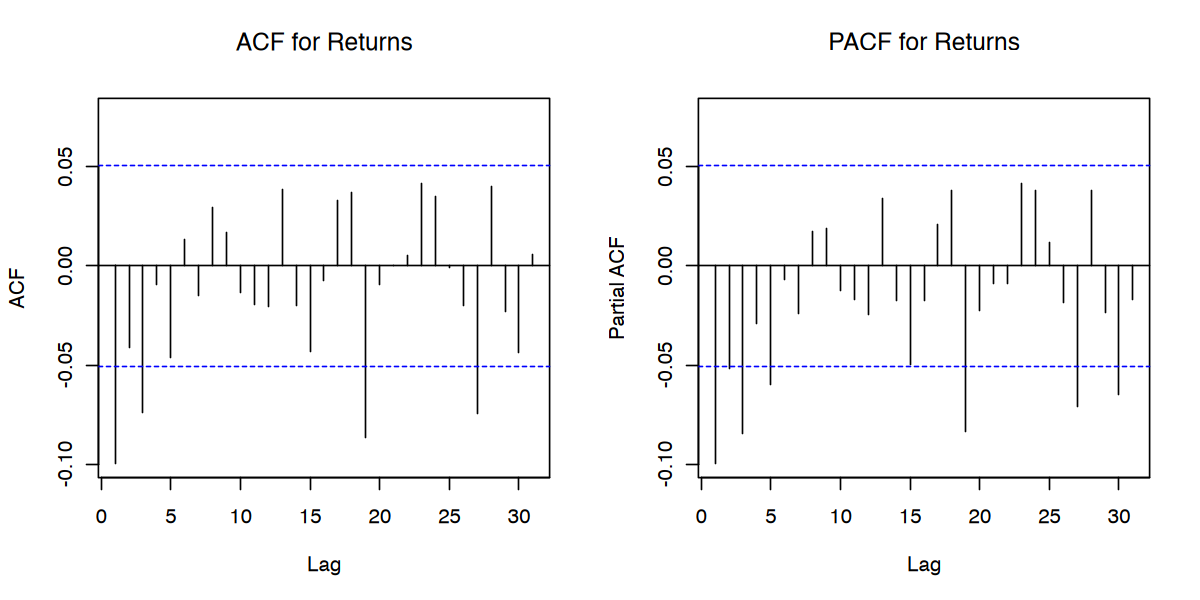

In [26]:
# Plot the acf and pacf
options(repr.plot.width = 10, repr.plot.height = 5)
par(mfrow = c(1, 2))
Acf(amt$ret, main="ACF for Returns")
Pacf(amt$ret, main="PACF for Returns")

The ACF and PACF plots for the ARMA-GARCH model exhibit autocorrelations at multiple lags. Specifically, we observe significant autocorrelation at lags 1, 3, and 5. Therefore, we will start our analysis with the ARMA(1,1) model specification.

In [27]:
# Let R estimate the model and choose the model specification
auto.arima(amt$ret)

Series: amt$ret 
ARIMA(1,0,1) with non-zero mean 

Coefficients:
         ar1      ma1   mean
      0.6467  -0.7596  5e-04
s.e.  0.0950   0.0813  2e-04

sigma^2 = 0.0001936:  log likelihood = 4285.44
AIC=-8562.88   AICc=-8562.85   BIC=-8541.62

We let R automatically choose the ARIMA model specification by calling ```auto.arima```. R selected an ARMA(1,1) model, confirming our decision to start with the ARMA(1,1) model specification when estimating the ARMA-GARCH model. The estimated ARMA(1,1) coefficients for the autoregression, moving average, and intercept are statistically significant.

In [28]:
# Estimate the ARMA-GARCH model manually
model_specification = ugarchspec(mean.model = list(armaOrder = c(1, 1)), 
                     variance.model = list(garchOrder = c(1, 1)))

# fit the model
garch_fit = ugarchfit(spec = model_specification, data = amt$ret)

garch_fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,1)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000530    0.000226   2.3437 0.019093
ar1     0.682446    0.107281   6.3613 0.000000
ma1    -0.780022    0.092408  -8.4410 0.000000
omega   0.000005    0.000001   5.3955 0.000000
alpha1  0.054719    0.006214   8.8054 0.000000
beta1   0.920648    0.008867 103.8286 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000530    0.000254   2.0854 0.037029
ar1     0.682446    0.139485   4.8926 0.000001
ma1    -0.780022    0.117269  -6.6516 0.000000
omega   0.000005    0.000002   2.3235 0.020152
alpha1  0.054719    0.012435   4.4006 0.000011
beta1   0.920648    0.010465  87.9735 0.000000

LogLike

We start estimating the ARMA-GARCH model with an ARMA(1,1) and GARCH(1,1) model specification. All estimates are statistically significant at least at the 5% level. We continue by plotting the ACF and PACF of the standardized residuals to examine how our model fits the data.

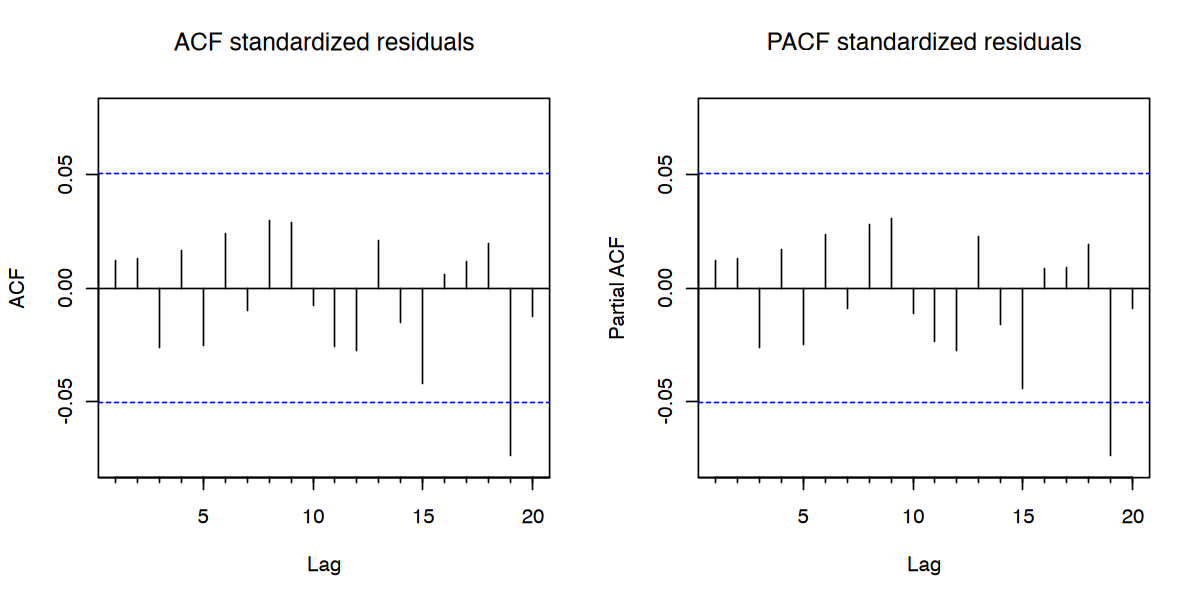

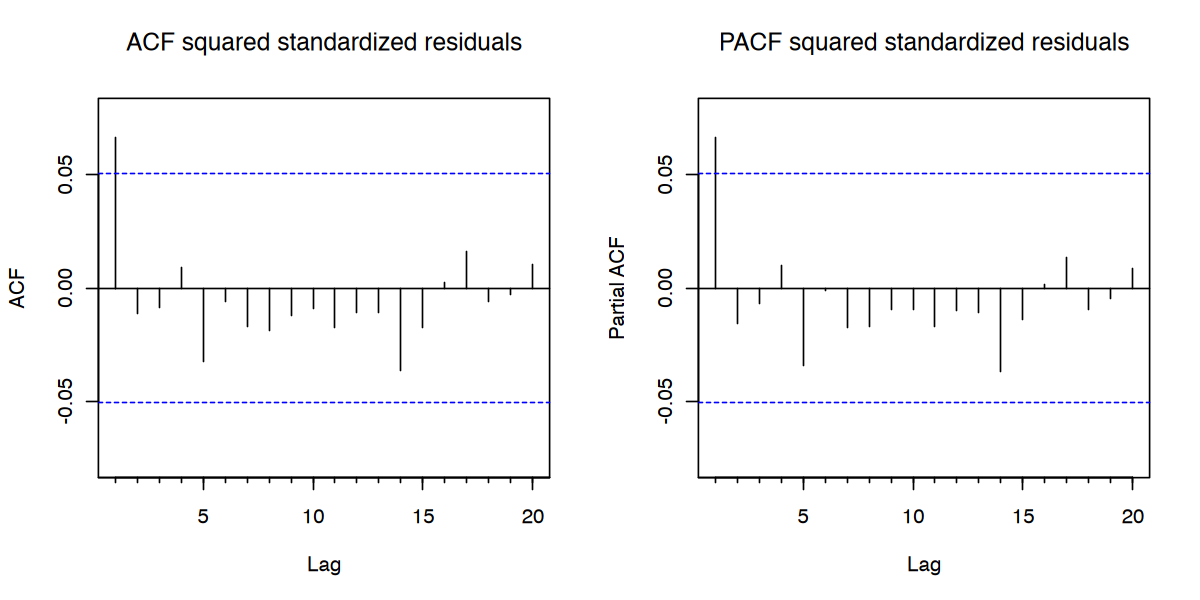

In [29]:
res = residuals(garch_fit, standardize = TRUE)
sqr_res = residuals(garch_fit, standardize = TRUE)^2

par(mfrow = c(1,2))
Acf(res, lag.max = 20, main="ACF standardized residuals")
Pacf(res, lag.max = 20, main="PACF standardized residuals")

par(mfrow = c(1,2))
Acf(sqr_res, lag.max = 20, main="ACF squared standardized residuals")
Pacf(sqr_res, lag.max = 20, main="PACF squared standardized residuals")

The ACF and PACF of the standardized residuals show no statistically significant autocorrelation except at lag 19. However, the ACF and PACF of the squared standardized residuals still show statistically significant autocorrelation at lag 1. Therefore, we decided to change the model specification and re-estimate the model.

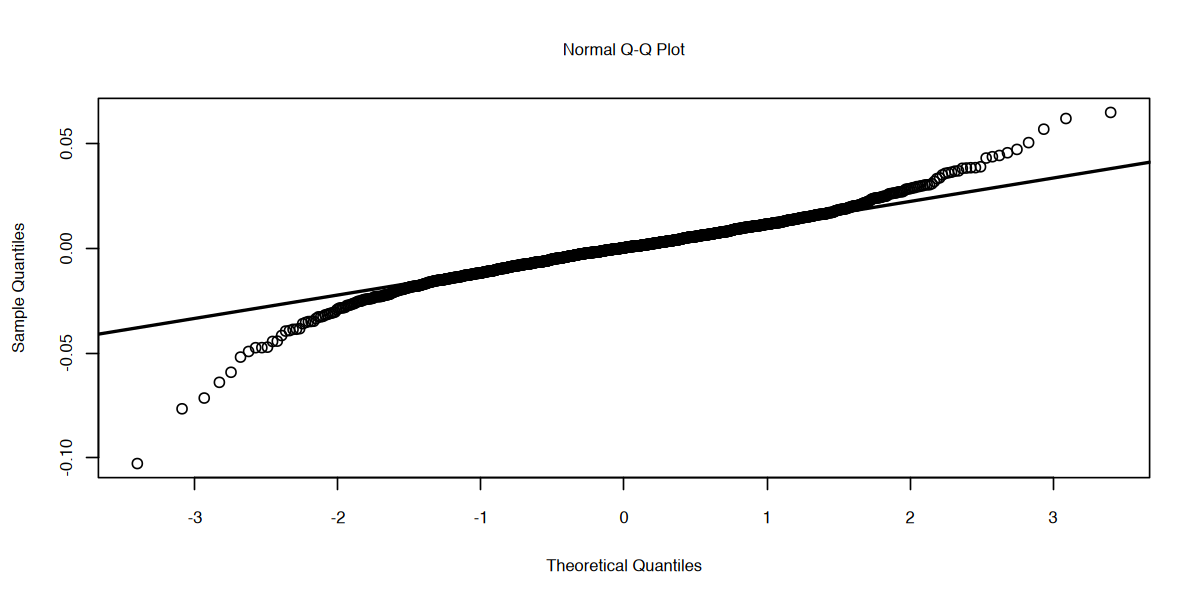

In [30]:
qqnorm(residuals(garch_fit), cex.main = 0.8, cex.lab = 0.8, cex.axis = 0.8) 
qqline(residuals(garch_fit), lwd = 2)

The plot above shows the sample quantiles plotted against the theoretical quantiles. Initially, we assumed that the residuals of our estimated model were normally distributed. However, upon observing the Normal-Q-Q-plot we can see a clear deviation from this assumption, particularly in the tails of our sample distribution. Consequently, we dropped the normality assumption and instead assume that the residuals are t-distributed.

In [31]:
model_specification = ugarchspec(mean.model = list(armaOrder = c(1, 1)), 
                     variance.model = list(garchOrder = c(1, 1)), distribution.model = "std")

# fit the model
garch_t_fit = ugarchfit(spec = model_specification, data = amt$ret)

garch_t_fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,1)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000747    0.000214   3.4870 0.000488
ar1     0.665198    0.123016   5.4074 0.000000
ma1    -0.754385    0.108447  -6.9562 0.000000
omega   0.000003    0.000003   1.0348 0.300762
alpha1  0.047463    0.015475   3.0671 0.002162
beta1   0.936158    0.020790  45.0297 0.000000
shape   4.896405    0.605551   8.0859 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000747    0.000227  3.28832 0.001008
ar1     0.665198    0.145776  4.56316 0.000005
ma1    -0.754385    0.127814 -5.90219 0.000000
omega   0.000003    0.000013  0.25582 0.798091
alpha1  0.047463    0.046561  1.01938 0.308025
beta1   0

Here, we re-estimate the ARMA-GARCH model with ARMA(1,1) and GARCH(1,1) model specification with assumed Student's t-distributed residuals. Again, all our estimated coefficients, except one, are statistically significant at least at the 5% level. We continue with plotting the residuals to assess how our model fits the data.

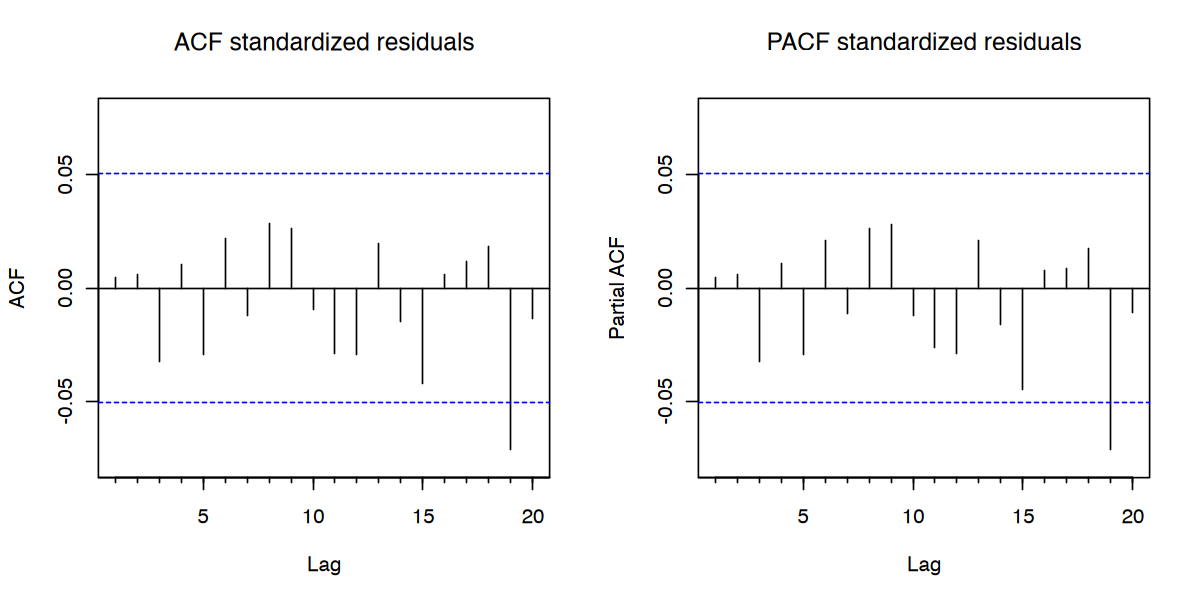

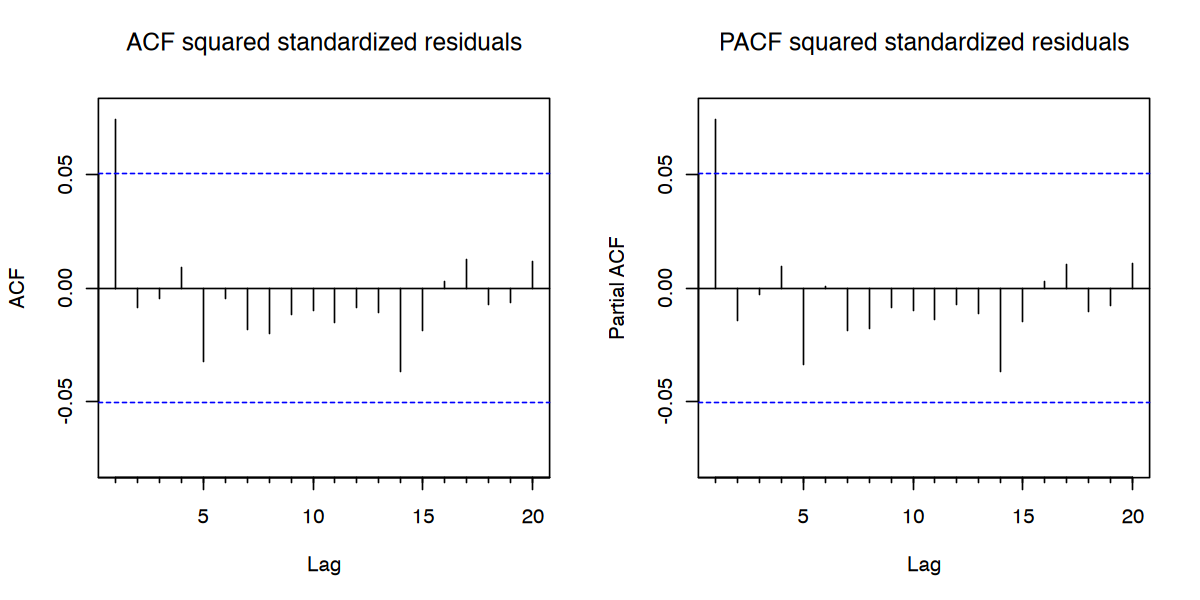

In [32]:
res = residuals(garch_t_fit, standardize = TRUE)
sqr_res = residuals(garch_t_fit, standardize = TRUE)^2

par(mfrow = c(1,2))
Acf(res, lag.max = 20, main="ACF standardized residuals")
Pacf(res, lag.max = 20, main="PACF standardized residuals")

par(mfrow = c(1,2))
Acf(sqr_res, lag.max = 20, main="ACF squared standardized residuals")
Pacf(sqr_res, lag.max = 20, main="PACF squared standardized residuals")

After plotting the ACF and PACF of our model's residuals we can still observe persistent autocorrelation of the squared standardized residuals at lag 1.

In [33]:
shape_value = coef(garch_t_fit)["shape"]
print(shape_value)
n_resid = length(residuals(garch_t_fit)) 

   shape 
4.896405 


The Student's t-distribution has approximately $v$ = 5 degrees of freedom.

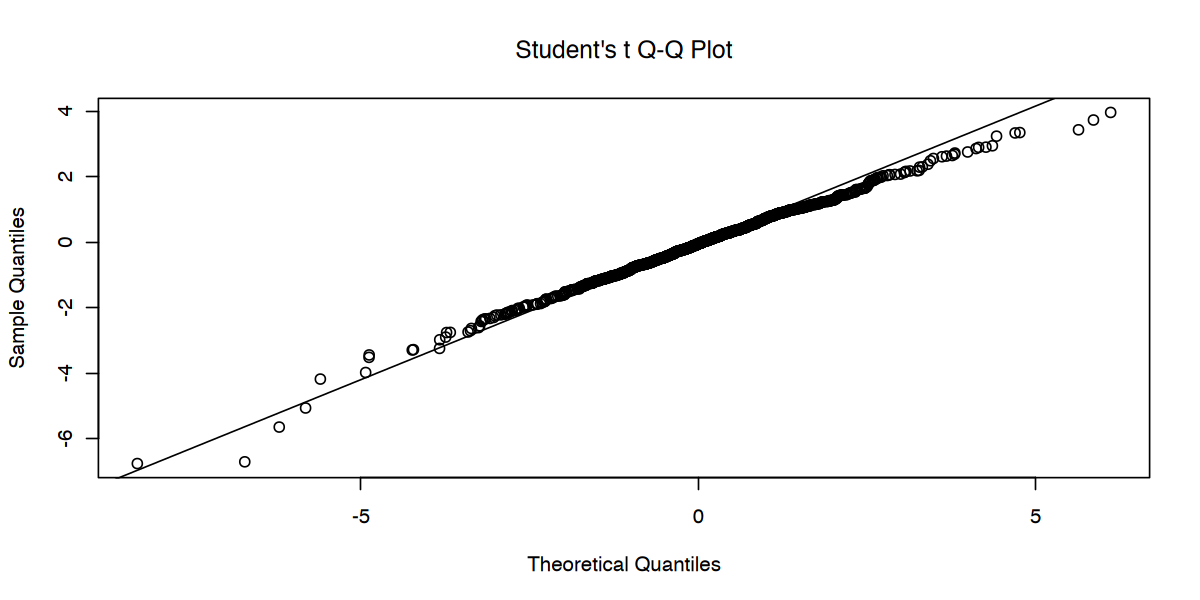

In [34]:

qqplot(rt(n_resid,df = shape_value), as.numeric(residuals(garch_t_fit) / sigma(garch_t_fit)), ylab = 'Sample Quantiles', 
       xlab = 'Theoretical Quantiles', main = 'Student\'s t Q-Q Plot')
qqline(as.numeric(residuals(garch_t_fit)/ sigma(garch_t_fit)))

Here, we plot our sample quantiles against the theoretical quantiles of the Student's t-distribution. We conclude that the assuming Student's t-distributed residuals is a more appropriate assumption than assuming normality. Therefore, we continue estimating our model with assuming Student's t-distributed residuals.

In [35]:
p_max = 3
q_max = 3
ic_min = Inf
best_p = 0
best_q = 0

for (i1 in 1:p_max) {
    for (i2 in 1:q_max) {
        print(i1, i2)
        model_specification = ugarchspec(mean.model = list(armaOrder = c(1, 1), include.mean = TRUE), 
                     variance.model = list(garchOrder = c(i1, i2)), distribution.model = "std")
        fit = ugarchfit(spec = model_specification, data = amt$ret)
        inf_crit = infocriteria(fit)[1] # 1 for aic, 2 for bic, 3 Shibata, 4 Hannan-Quinn
        ic_min = ifelse(inf_crit < ic_min, inf_crit, ic_min)
        
        best_p = ifelse(inf_crit == ic_min, i1, best_p)
        best_q = ifelse(inf_crit == ic_min, i2, best_q)
    }
}

c(best_p, best_q)

[1] 1
[1] 1
[1] 1
[1] 2
[1] 2
[1] 2
[1] 3
[1] 3
[1] 3


[1] 1 3

We iterate over 9 different ARMA(1,1)-GARCH(x,y) model specifications to identify which GARCH specification fits our data best. We assess goodness of fit by using the Akaike Information Criterion (AIC), which evaluates model fit by favoring more parsimonious models. We find that ARMA(0,0)-GARCH(1,3) fits best. Consequently, we proceeded to re-estimate our model using the ARMA(1,1)-GARCH(1,3) specification.

In [36]:
garch_t_1131_spec = ugarchspec(mean.model = list(armaOrder = c(1, 0)), 
                     variance.model = list(model = "sGARCH",garchOrder = c(1, 3)), distribution.model = "std")

# fit the model
garch_t_1131_fit = ugarchfit(spec = garch_t_1131_spec, data = amt$ret)

garch_t_1131_fit


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,3)
Mean Model	: ARFIMA(1,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000780    0.000267  2.92007 0.003500
ar1    -0.083399    0.026316 -3.16914 0.001529
omega   0.000008    0.000002  3.37621 0.000735
alpha1  0.108494    0.010141 10.69873 0.000000
beta1   0.291869    0.211365  1.38088 0.167317
beta2   0.112020    0.228040  0.49123 0.623265
beta3   0.450017    0.146929  3.06282 0.002193
shape   4.951598    0.593142  8.34808 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000780    0.000236  3.30704 0.000943
ar1    -0.083399    0.025421 -3.28066 0.001036
omega   0.000008    0.000004  2.17734 0.029455
alpha1  0.108494    0.017383  6.24141 0.000000
beta1   0

Here, we re-estimate the ARMA-GARCH model with ARMA(1,1) and GARCH(1,3) model specification with assumed Student's t-distributed residuals. Many of our estimated coefficients, except three, are statistically significant at least at the 5% level. We continue with plotting the residuals to assess how our model fits the data.

Out of betas, only beta3 is statistically significant, suggesting some persistance of the past conditional volatility. alpha1 is also statistically significant and positive indicating effect of new information.

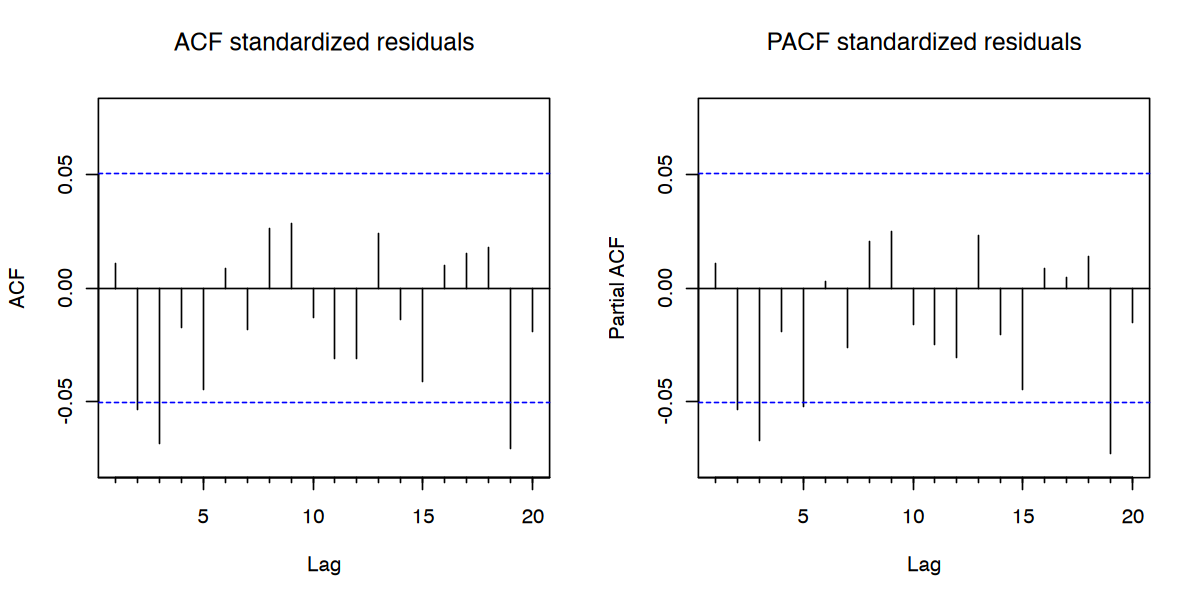

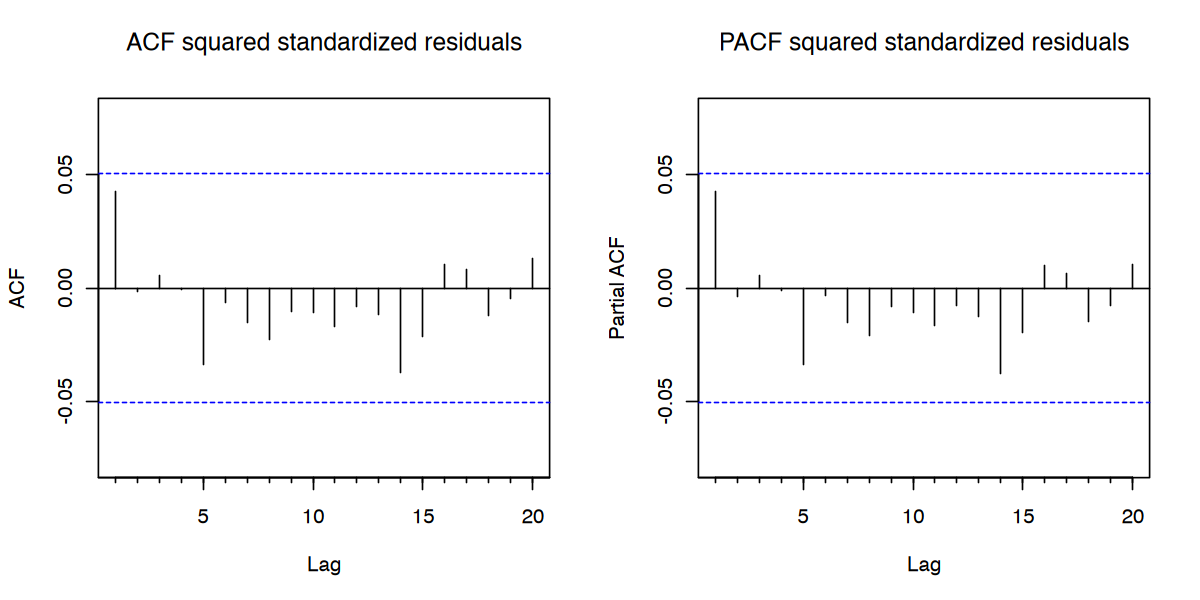

In [37]:
res = residuals(garch_t_1131_fit, standardize = TRUE)
sqr_res = residuals(garch_t_1131_fit, standardize = TRUE)^2

par(mfrow = c(1,2))
Acf(res, lag.max = 20, main="ACF standardized residuals")
Pacf(res, lag.max = 20, main="PACF standardized residuals")

par(mfrow = c(1,2))
Acf(sqr_res, lag.max = 20, main="ACF squared standardized residuals")
Pacf(sqr_res, lag.max = 20, main="PACF squared standardized residuals")

After plotting the ACF and PACF of our we find no statistically significant autocorrelation at any lag up to lag 20, except at lag 19. We conclude that the ARMA(1,1)-GARCH(1,3) model is reasonably well specified and that increasing the GARCH order helped with modelling the dependencies.

In [38]:
shape_value = coef(garch_t_1131_fit)["shape"]
print(shape_value)
n_resid = length(residuals(garch_t_1131_fit)) 

   shape 
4.951598 


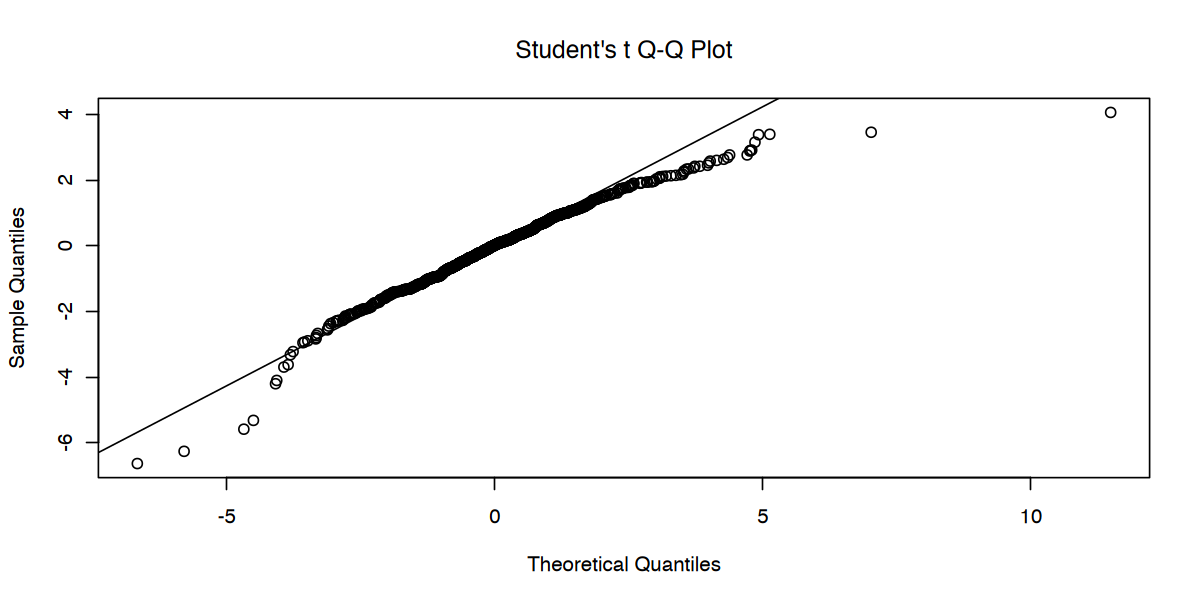

In [39]:
qqplot(rt(n_resid,df = shape_value), as.numeric(residuals(garch_t_1131_fit) / sigma(garch_t_1131_fit)), ylab = 'Sample Quantiles', 
       xlab = 'Theoretical Quantiles', main = 'Student\'s t Q-Q Plot')
qqline(as.numeric(residuals(garch_t_1131_fit)/ sigma(garch_t_1131_fit)))

When plotting the sample quantiles against the theoretical quantiles, we can see that the residuals almost perfectly follow the Student's t-distribution. This confirms our choice of using an ARMA(1,1)-GARCH(1,3)-t model.

In [40]:
Box.test(res, type = "Ljung-Box", lag = 25)
Box.test(sqr_res, type = "Ljung-Box", lag = 25)


	Box-Ljung test

data:  res
X-squared = 37.165, df = 25, p-value = 0.05569



	Box-Ljung test

data:  sqr_res
X-squared = 17.236, df = 25, p-value = 0.8731


We use the Ljung-Box test to test whether our ARMA(1,1)-GARCH(1,3)-t model exhibits any autocorrelation in the residuals. We cannot reject the Null hypothesis of no statistically significant estimate up to the lag 25 and, therefore, conclude that our model caputures the relationships in the data well.

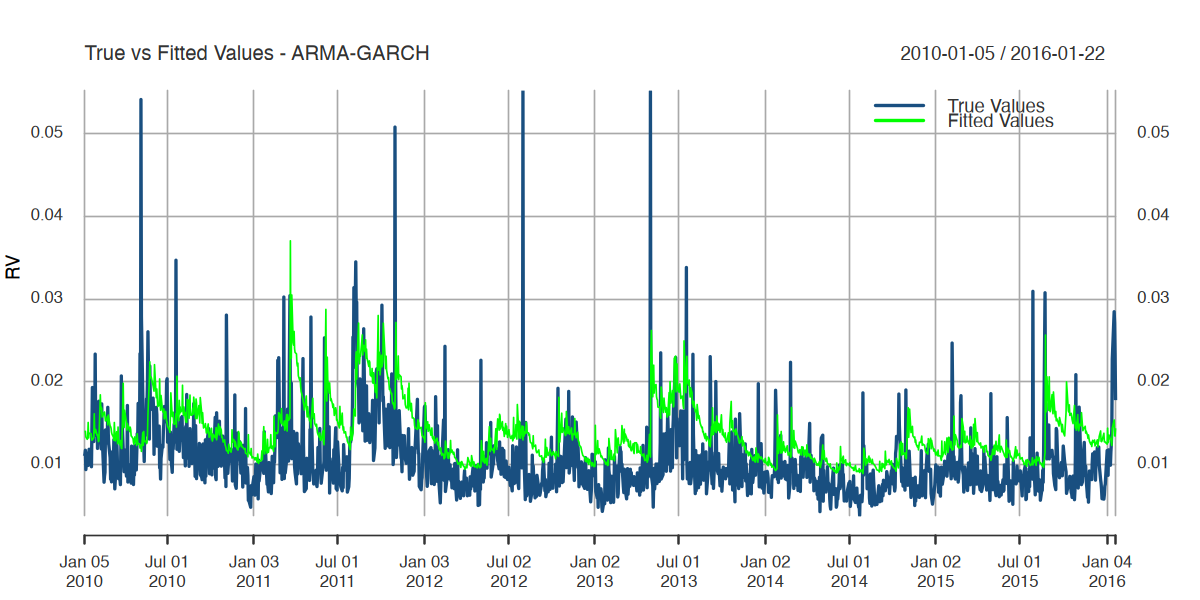

In [41]:
amt$arma_garch_fit_val = sigma(garch_t_1131_fit)

plot_arma_garch = plot(amt$RV, type = 'l', col = "#194f80", lwd = 2, xlab = "Time", ylab = "RV", main = "True vs Fitted Values - ARMA-GARCH")
plot_arma_garch = lines(amt$arma_garch_fit_val, col = "green", lwd = 1)
plot_arma_garch = addLegend("topright", legend.names = c("True Values", "Fitted Values"), col = c("#194f80", "green"), lty = 1, lwd = 2)
plot_arma_garch

RV is also seriously overestimated by the ARMA-GARCH, based on the visual inspection it seems that perhaps even the most out of the models we estimated.

## (g) Comparison of fits

In [42]:
mse_in_samp <- function(true_values, predicted_values) {
  mean((true_values - predicted_values)^2, na.rm = TRUE)
}

mae_in_samp <- function(true_values, predicted_values) {
  mean(abs(true_values - predicted_values), na.rm = TRUE)
}

In [43]:
fit_cols <- grep("_fit_val", colnames(amt), value = TRUE)

# Calculate MSE and MAE for each model
results <- sapply(fit_cols, function(col) {
  fitted_values <- amt[, col]
  c(
    MSE = mse_in_samp(amt$RV, fitted_values),
    MAE = mae_in_samp(amt$RV, fitted_values)
  )
})
results_df <- data.frame(t(data.frame(results)))

results_df <- results_df[order(results_df$MSE, results_df$MAE), ] # Sort results by MSE, then by MAE

results_df

MSE          MAE        
HAR_rs_rk_fit_val  1.573535e-05 0.002322391
HAR_semi_fit_val   1.577569e-05 0.002335110
HAR_fit_val        1.606109e-05 0.002359915
rv_ar1_fit_val     1.756837e-05 0.002536676
real_garch_fit_val 2.598096e-05 0.003586030
arma_garch_fit_val 3.176016e-05 0.004387043

The in-sample MSE and MAE also support the prevous analysis: the GARCH-type models have the highest MAE and MSE.

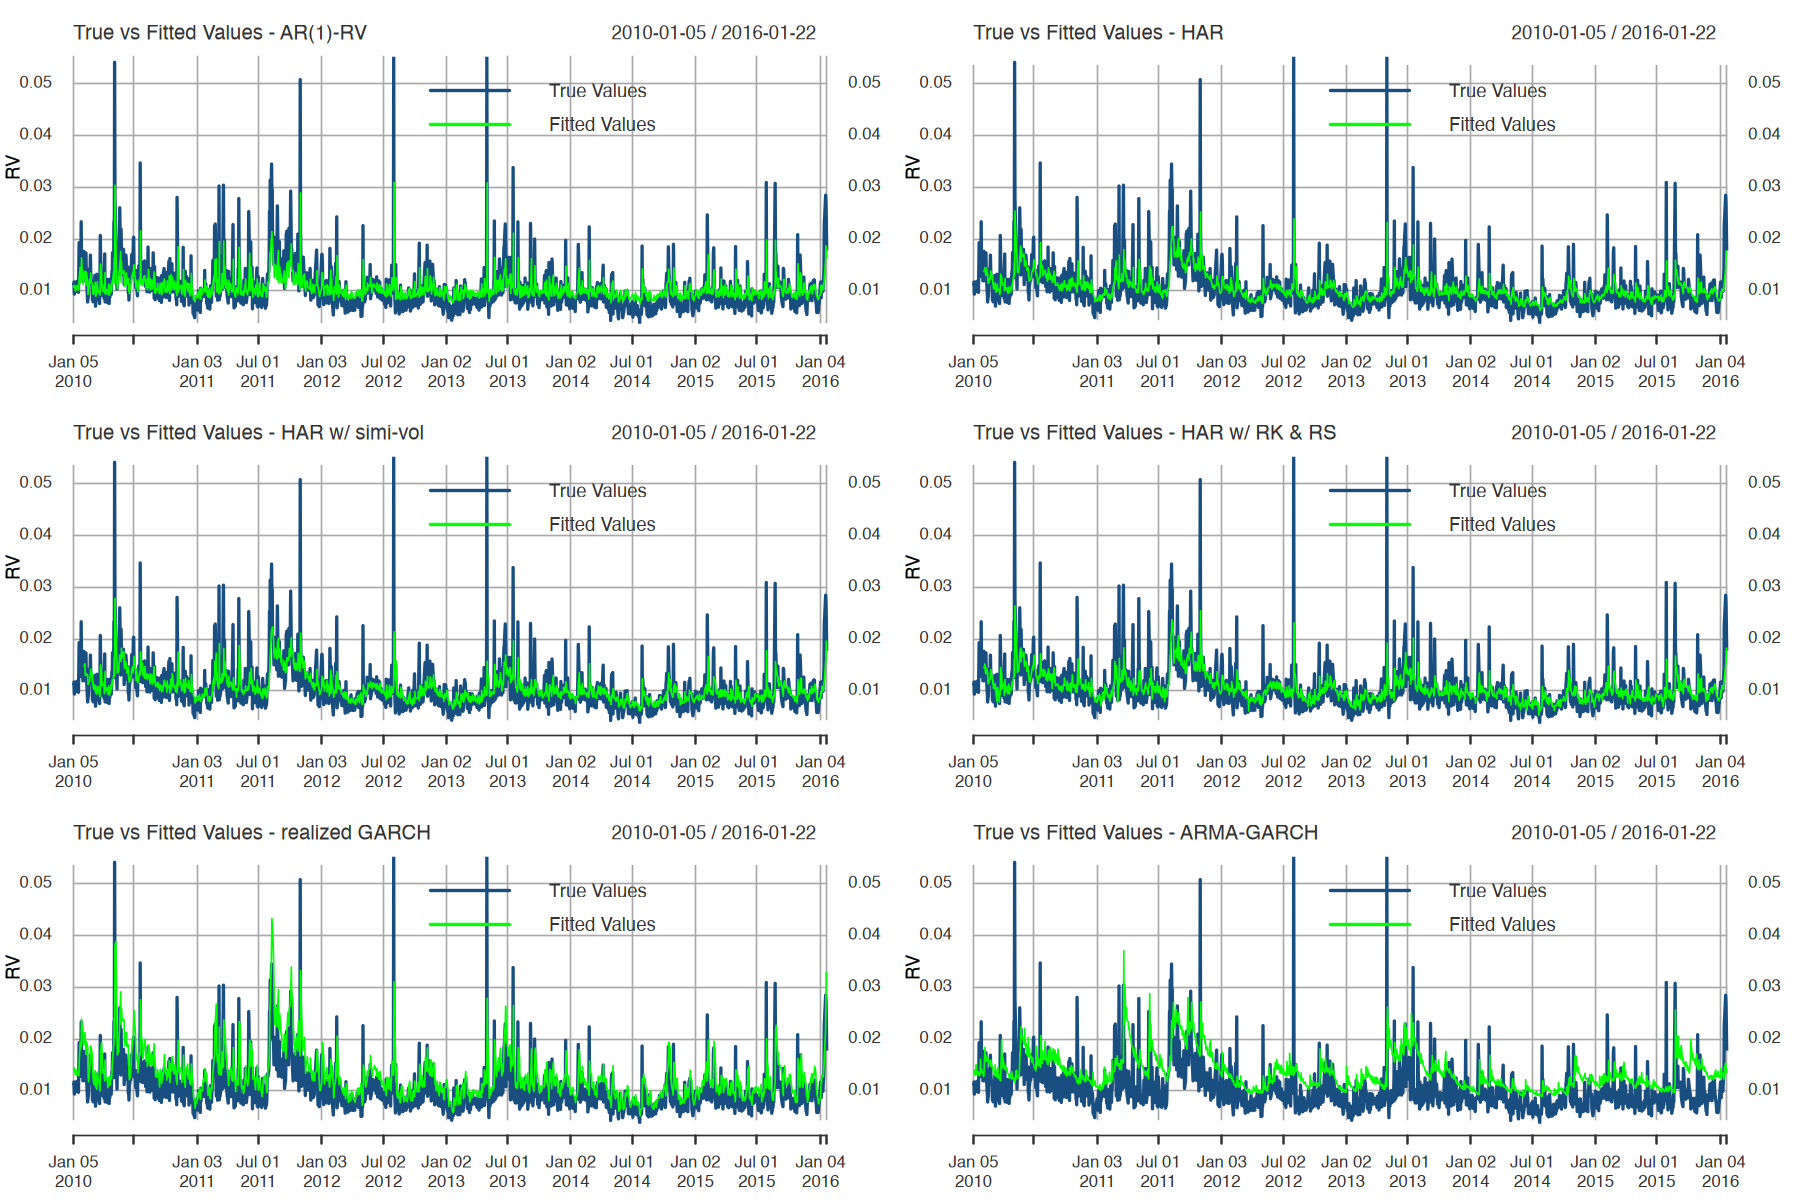

In [44]:
options(repr.plot.width = 15, repr.plot.height = 10)
par(mfrow = c(3,2))
plot_rv_ar
plot_HAR
plot_HAR_semi
plot_HAR_rk_rs
plot_real_garch
plot_arma_garch

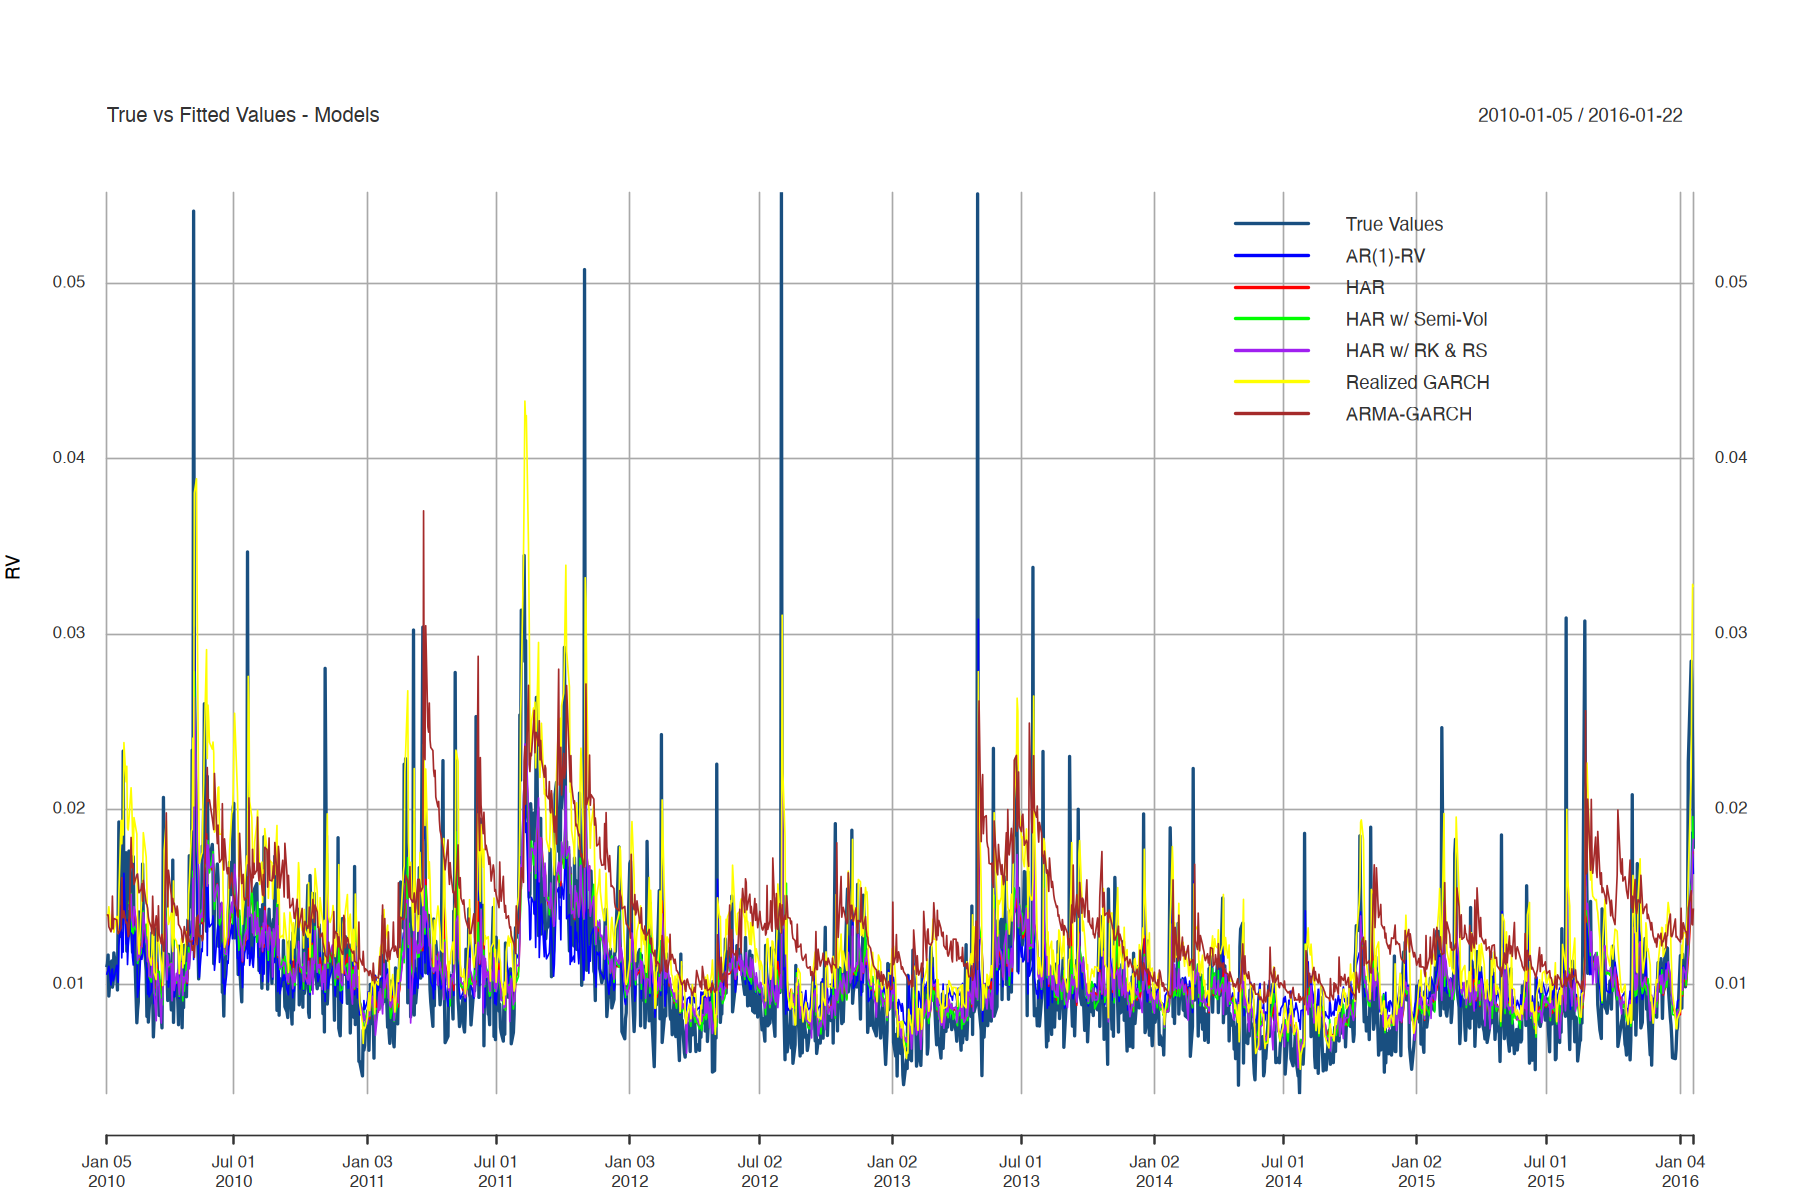

In [45]:
# plot all in one graph
p = plot(amt$RV, type = 'l', col = "#194f80", lwd = 2, xlab = "Time", ylab = "RV", main = "True vs Fitted Values - Models")

p = lines(amt$rv_ar1_fit_val, col = "blue", lwd = 1)  # AR(1)-RV
p = lines(amt$HAR_fit_val, col = "red", lwd = 1)  # HAR
p = lines(amt$HAR_semi_fit_val, col = "green", lwd = 1)  # HAR w/ semi-vol
p = lines(amt$HAR_rs_rk_fit_val, col = "purple", lwd = 1)  # HAR w/ RK & RS
p = lines(amt$real_garch_fit_val, col = "yellow", lwd = 1)  # Realized GARCH
p = lines(amt$arma_garch_fit_val, col = "brown", lwd = 1)  # ARMA-GARCH

p = addLegend("topright", legend.names = c("True Values", "AR(1)-RV", "HAR", "HAR w/ Semi-Vol", "HAR w/ RK & RS", "Realized GARCH", "ARMA-GARCH"),
          col = c("#194f80", "blue", "red", "green", "purple", "yellow", "brown"), lty = 1, lwd = 2)
p

Here, we plot all fitted values of all estimated models (AR(1)-RV, HAR, HAR with Semi-Volatility, HAR with Realized Kurtosis and Skewness, Realized GARCH, and ARMA-GARCH) against the true values. We find that the Realized GARCH and ARMA-GARCH over-estimate volatility. The other models seem to fit the data well in comparison. Next, we will continue with the forcasting part of our project.

# 4) Forecasts

## (a) Running the forecasts

In [46]:
# function to perform both expanding and rolling window forecasts for HAR models
forecast_har = function(formula, data, window_length) {
    vars = all.vars(formula)
    vars = vars[vars != "RV"] # defines the independent varianbles
    
    # here we check where to start - e.g. RV_22 has missing values at the begining of the interval so we have to start later to have 750 obs.
    max_non_na_start = max(sapply(data[, vars], function(x) min(which(!is.na(x)))))
    start_window = max(window_length, max_non_na_start + 749)
    out_of_sample = nrow(data) - start_window

    # prepare where to store the results                               
    expanding_forecasts = numeric(out_of_sample)
    rolling_forecasts = numeric(out_of_sample)
    forecast_dates = index(data)[(start_window + 1):(start_window + out_of_sample)] # for these dates we forecast
    
    for (i in 1:out_of_sample) {
    # Expanding window setup
    expand_end = start_window + i - 1 # gradually expanding the window from the 750th non-missing obs.
    model_expanding = lm(formula, data = data[1:expand_end, ])
    new_data_expand = data[expand_end + 1, names(coef(model_expanding))[-1], drop = FALSE]
    expanding_forecasts[i] = predict(model_expanding, newdata = new_data_expand)
    
    # Rolling window setup
    roll_start = expand_end - window_length + 1 # for roll start is 'window_length' away from the end of the interval 
    model_rolling = lm(formula, data = data[roll_start:expand_end, ])
    new_data_roll = data[expand_end + 1, names(coef(model_rolling))[-1], drop = FALSE]
    rolling_forecasts[i] = predict(model_rolling, newdata = new_data_roll)
    }
    
    # xts objects for each type of forecast
    expanding_xts = xts(expanding_forecasts, order.by = forecast_dates)
    rolling_xts = xts(rolling_forecasts, order.by = forecast_dates)
    
    return(list(expanding = expanding_xts, rolling = rolling_xts))
}


In [47]:
# Model specifications
models = list(
  RV ~ RV_1,
  RV ~ RV_1 + RV_5 + RV_22,
  RV ~ RV_p_l + RV_n_l + RV_5 + RV_22,
  RV ~ RV_1 + RV_5 + RV_22 + RS_l + RK_l
)

forecast_results = lapply(models, function(model_formula) {
  forecast_har(model_formula, amt, 750)
})

forecast_matrix = do.call(cbind, lapply(forecast_results, function(result) { #combine results into a data frame
  cbind(result$expanding, result$rolling)}))

# Set column names
colnames(forecast_matrix) = c("AR1_exp", "AR1_roll", "HAR_exp", "HAR_roll", "HAR_semi_exp", "HAR_semi_roll", "HAR_skew_kurt_exp", "HAR_skew_kurt_roll")

In [48]:
head(forecast_matrix) # HAR models start later due to the weekly/montly RV and required 750 obs.

               AR1_exp    AR1_roll HAR_exp HAR_roll HAR_semi_exp HAR_semi_roll
2013-01-14 0.009430176 0.009430176      NA       NA           NA            NA
2013-01-15 0.009155873 0.009156121      NA       NA           NA            NA
2013-01-16 0.009578290 0.009578171      NA       NA           NA            NA
2013-01-17 0.009332795 0.009335712      NA       NA           NA            NA
2013-01-18 0.008570872 0.008572408      NA       NA           NA            NA
2013-01-22 0.008311133 0.008312711      NA       NA           NA            NA
           HAR_skew_kurt_exp HAR_skew_kurt_roll
2013-01-14                NA                 NA
2013-01-15                NA                 NA
2013-01-16                NA                 NA
2013-01-17                NA                 NA
2013-01-18                NA                 NA
2013-01-22                NA                 NA

In [49]:
# function to perform the GARCH forecasting
forecast_garch = function(spec, data, realized_vol, window_length = 750) {
    n = nrow(data)
    expanding_forecasts = numeric(n - window_length) # objects to store results
    rolling_forecasts = numeric(n - window_length)
    forecast_dates = index(data)[(window_length + 1):n]
    
    # Expanding window forecasts
    for (i in window_length:(n - 1)) {
    fit_expanding = ugarchfit(spec = spec, data = data[1:i],
                               realizedVol = realized_vol[1:i], solver = "hybrid")
    forecast_expanding = ugarchforecast(fit_expanding, n.ahead = 1, n.roll = 0)
    expanding_forecasts[i - window_length + 1] = forecast_expanding@forecast$sigmaFor[1]}
    
    # Rolling window forecasts
    for (i in 1:(n - window_length)) { # starting point from 1 to n - window_length
    fit_rolling = ugarchfit(spec = spec, data = data[i:(i + window_length - 1)], # use data from i and the following 750 obs.
                             realizedVol = realized_vol[i:(i + window_length - 1)], solver = "hybrid")
    forecast_rolling = ugarchforecast(fit_rolling, n.ahead = 1, n.roll = 0)
    rolling_forecasts[i] = forecast_rolling@forecast$sigmaFor[1]}
    
    expanding_xts = xts(expanding_forecasts, order.by = forecast_dates) # store results
    rolling_xts = xts(rolling_forecasts, order.by = forecast_dates)
    
    return(list(expanding = expanding_xts, rolling = rolling_xts))
}

In [50]:
# perform forecasts - specifications defined before
garch_results = list(
  realGARCH = forecast_garch(real_garchspec, amt$ret, amt$RV),
  sGARCH = forecast_garch(garch_t_1131_spec, amt$ret, amt$RV)
)

# Combine GARCH results analogous to HAR results
garch_forecast_matrix = do.call(cbind, lapply(garch_results, function(result) {
  cbind(result$expanding, result$rolling)
}))

# Set column names for GARCH forecasts
colnames(garch_forecast_matrix) = c("realGARCH_exp", "realGARCH_roll", "sGARCH_exp", "sGARCH_roll")


In [51]:
# Combine HAR and GARCH forecasts into one object
combined_forecast_matrix = cbind(forecast_matrix, garch_forecast_matrix)

In [52]:
head(garch_forecast_matrix)
tail(garch_forecast_matrix)

           realGARCH_exp realGARCH_roll sGARCH_exp sGARCH_roll
2013-01-11   0.003427967    0.003425051 0.01227074  0.01227074
2013-01-14   0.003467723    0.003448619 0.01204058  0.01201544
2013-01-15   0.003273789    0.003238734 0.01133688  0.01134613
2013-01-16   0.003395814    0.003353558 0.01124976  0.01122078
2013-01-17   0.003381358    0.003365259 0.01152957  0.01148815
2013-01-18   0.002978538    0.002927804 0.01117909  0.01115483

           realGARCH_exp realGARCH_roll sGARCH_exp sGARCH_roll
2016-01-14   0.005985543    0.005177259 0.01224169  0.01206505
2016-01-15   0.006718223    0.005706206 0.01441585  0.01388665
2016-01-19   0.009062396    0.007720753 0.01544474  0.01403585
2016-01-20   0.012140318    0.010240255 0.01368778  0.01256856
2016-01-21   0.013886017    0.011727784 0.01362882  0.01338605
2016-01-22   0.013875245    0.011692825 0.01477945  0.01361159

In [53]:
summary(combined_forecast_matrix)

     Index               AR1_exp            AR1_roll           HAR_exp        
 Min.   :2013-01-11   Min.   :0.007839   Min.   :0.007369   Min.   :0.006301  
 1st Qu.:2013-10-10   1st Qu.:0.009331   1st Qu.:0.008939   1st Qu.:0.008528  
 Median :2014-07-14   Median :0.009948   Median :0.009509   Median :0.009418  
 Mean   :2014-07-14   Mean   :0.010270   Mean   :0.009833   Mean   :0.009629  
 3rd Qu.:2015-04-14   3rd Qu.:0.010742   3rd Qu.:0.010264   3rd Qu.:0.010260  
 Max.   :2016-01-22   Max.   :0.031653   Max.   :0.031704   Max.   :0.022883  
                      NA's   :1          NA's   :1          NA's   :22        
    HAR_roll         HAR_semi_exp      HAR_semi_roll      HAR_skew_kurt_exp 
 Min.   :0.006129   Min.   :0.006245   Min.   :0.005892   Min.   :0.005322  
 1st Qu.:0.008492   1st Qu.:0.008502   1st Qu.:0.008452   1st Qu.:0.008513  
 Median :0.009292   Median :0.009361   Median :0.009222   Median :0.009459  
 Mean   :0.009496   Mean   :0.009638   Mean   :0.009513   Me

We can see that the forecasts range from about 0.002 to 0.03 for all models and forecasting schemes. The only exception is the realGARCH model forecasted with the rolling window. There appear to be some outliers reaching almost 0.6.

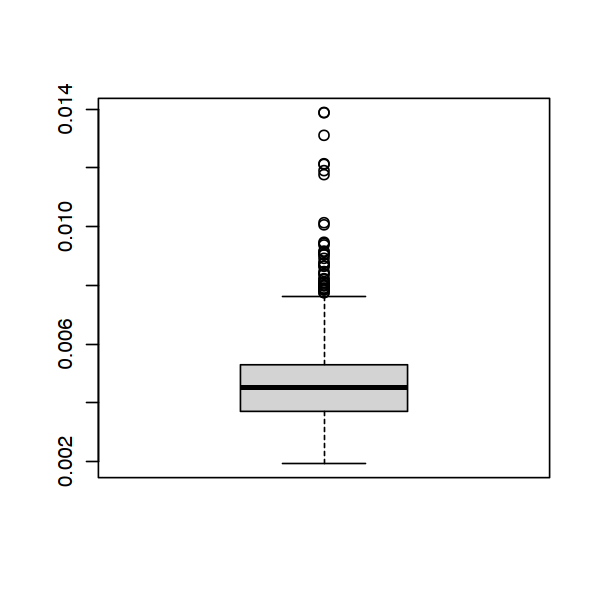

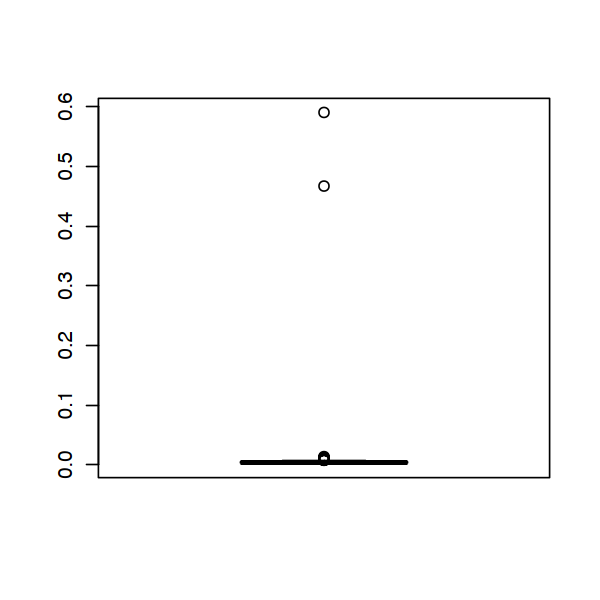

In [54]:
options(repr.plot.width = 5, repr.plot.height = 5)
boxplot(combined_forecast_matrix$realGARCH_exp)
boxplot(combined_forecast_matrix$realGARCH_roll)

Indeed, the boxplot supports that that the presence of outliers. 

## (b) Forecasts evaluation - graphs

In [55]:
# combine data for plotting
data_all = cbind(combined_forecast_matrix, amt$RV)
data_all_nona = na.omit(data_all)

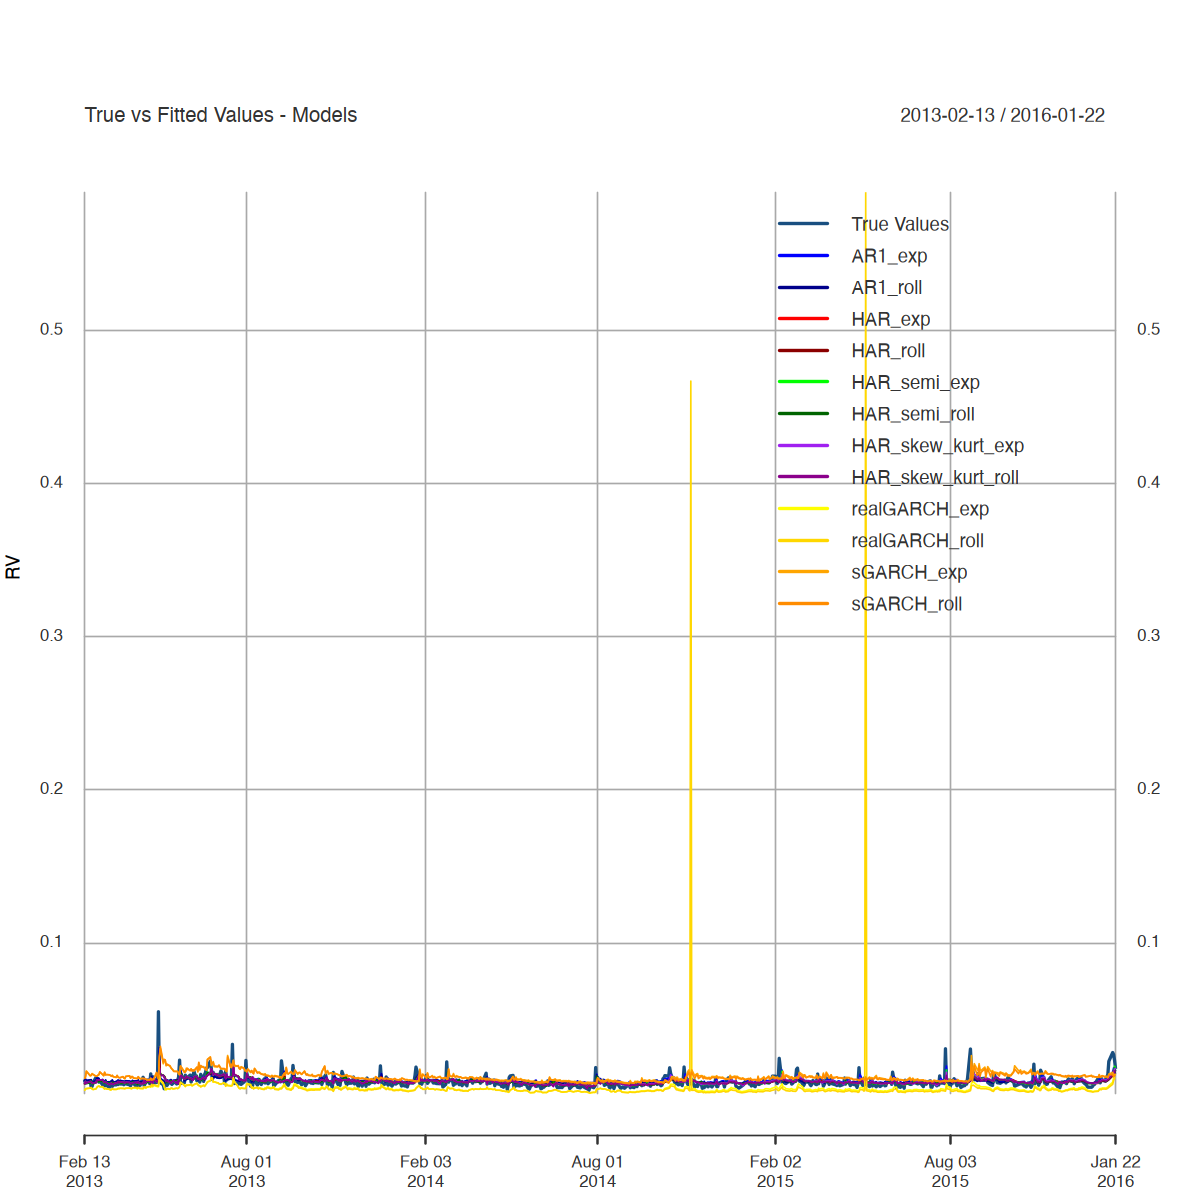

In [56]:
options(repr.plot.width = 10, repr.plot.height = 10)
p = plot(data_all_nona$RV, type = 'l', col = "#194f80", lwd = 2, xlab = "Time", ylab = "RV", main = "True vs Fitted Values - Models")

series_list = list(
  AR1_exp = "blue",AR1_roll = "darkblue",HAR_exp = "red",
  HAR_roll = "darkred",HAR_semi_exp = "green",HAR_semi_roll = "darkgreen",
  HAR_skew_kurt_exp = "purple",HAR_skew_kurt_roll = "darkmagenta",
  realGARCH_exp = "yellow",realGARCH_roll = "gold",sGARCH_exp = "orange",sGARCH_roll = "darkorange")

# for loop through the list
for (series_name in names(series_list)) {
  p = lines(data_all_nona[,series_name], col = series_list[[series_name]], lwd = 1)
}

p = addLegend("topright", legend.names = c("True Values", names(series_list)),col = c("#194f80", unlist(series_list)),lty = 1,lwd = 2)
p

Clearly, the realGARCH forecast produces a few extreme values using the rolling window. Let's also plot the series without it for readability.

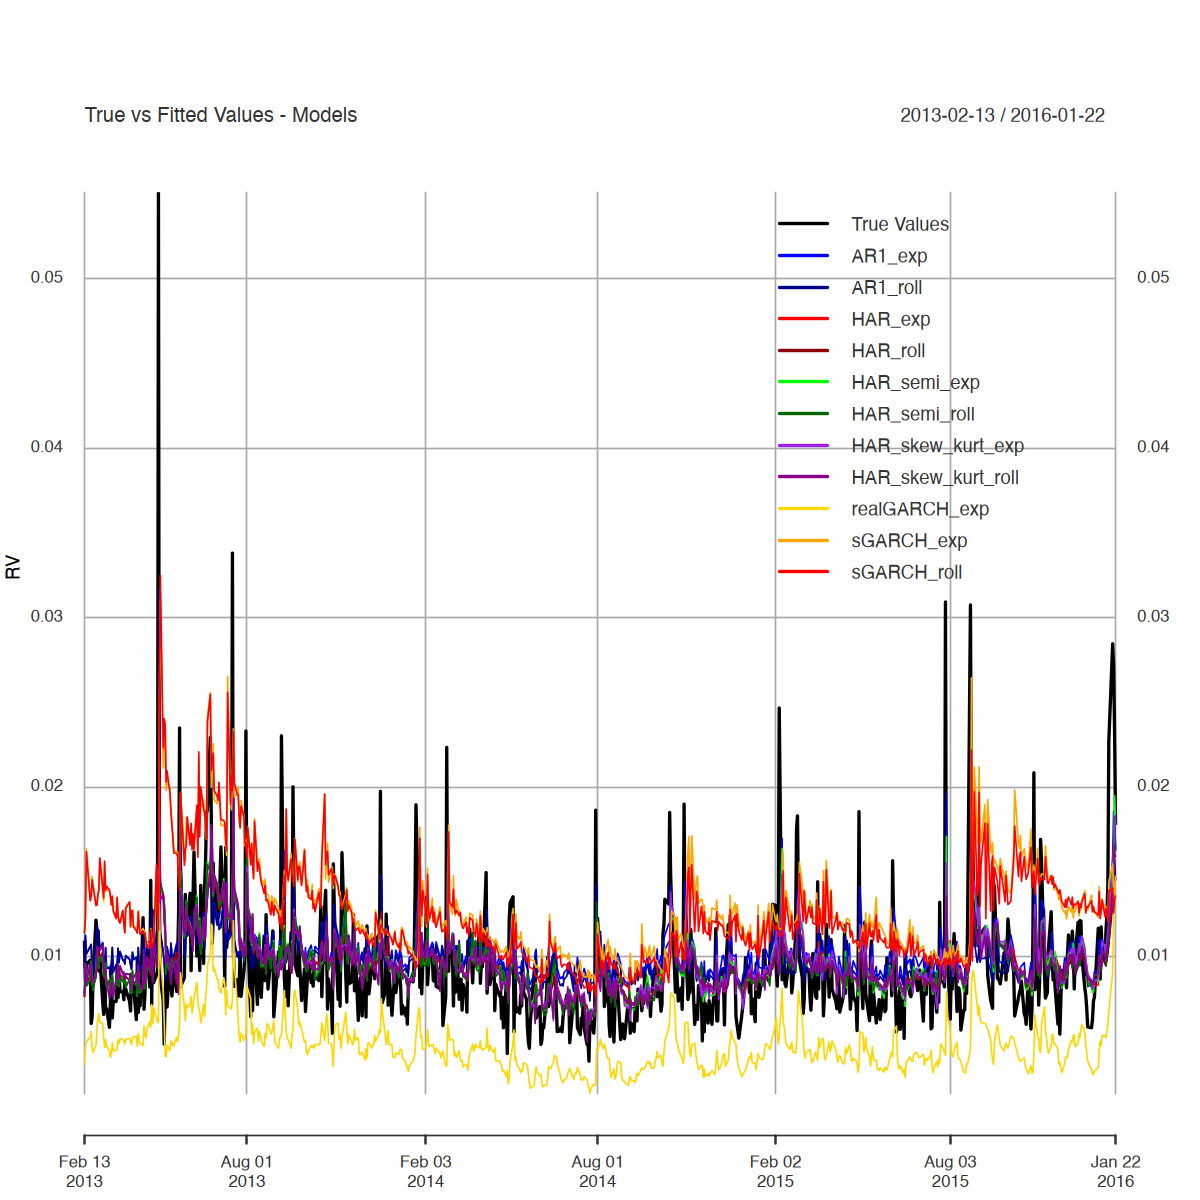

In [57]:
options(repr.plot.width = 10, repr.plot.height = 10)
# same code just commenting out realGARCH_roll
p = plot(data_all_nona$RV, type = 'l', col = "black", lwd = 2, xlab = "Time", ylab = "RV", main = "True vs Fitted Values - Models")

series_list = list(
  AR1_exp = "blue",
  AR1_roll = "darkblue",
  HAR_exp = "red",
  HAR_roll = "darkred",
  HAR_semi_exp = "green",
  HAR_semi_roll = "darkgreen",
  HAR_skew_kurt_exp = "purple",
  HAR_skew_kurt_roll = "darkmagenta",
  realGARCH_exp = "gold",
  #realGARCH_roll = "yellow",
  sGARCH_exp = "orange",
  sGARCH_roll = "red"
)

for (series_name in names(series_list)) {
  p = lines(data_all_nona[,series_name], col = series_list[[series_name]], lwd = 1)
}

p = addLegend("topright",legend.names = c("True Values", names(series_list)),col = c("black", unlist(series_list)), lty = 1, lwd = 2)
p

While the realGARCH using the expanding window systematically underforecasts the volatility, the standard ARMA-GARCH overforecasts it, regardless of the forecasting schemes. 

In [58]:
# calculate errors
error_list = list()
forecast_names = colnames(combined_forecast_matrix)

for (name in forecast_names) {
  error_list[[name]] = amt$RV - combined_forecast_matrix[,name]
}

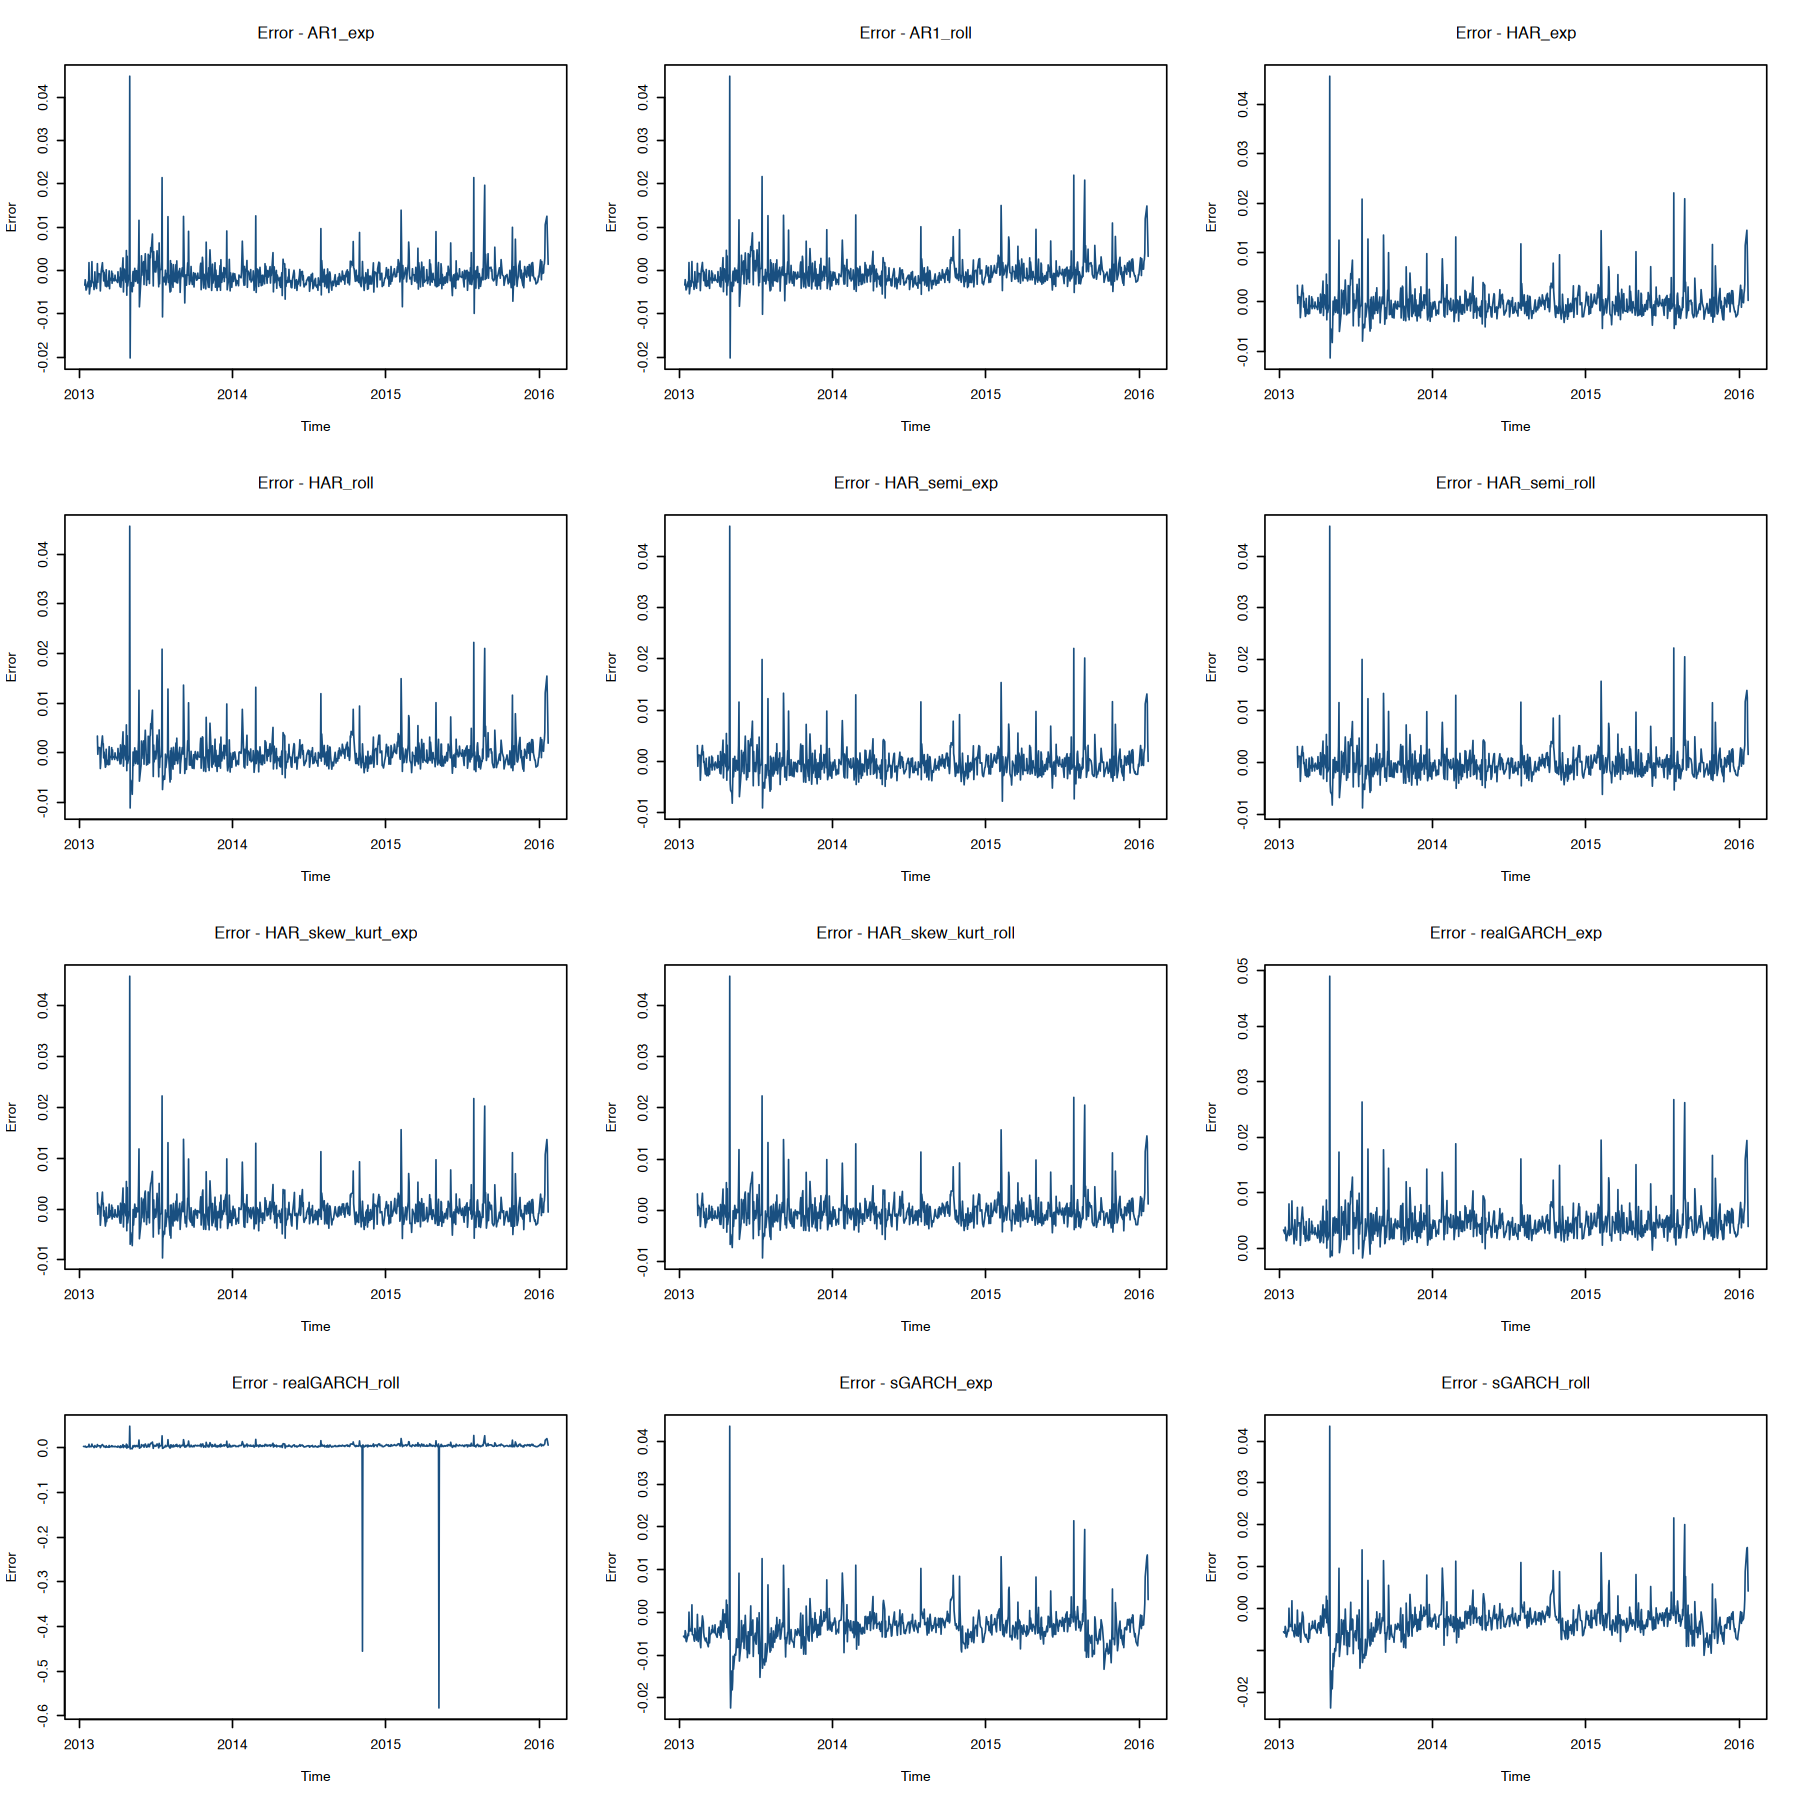

In [59]:
# Plot the errors
options(repr.plot.width = 15, repr.plot.height = 15)
par(mfrow=c(4, 3))

for (i in 1:length(forecast_names)) {
  plot(index(combined_forecast_matrix), error_list[[forecast_names[i]]], type='l', col="#194f80", lwd=1, 
       xlab="Time", ylab="Error", main=paste("Error -", forecast_names[i]))
}

In [60]:
unique(sub("_(exp|roll)$", "", forecast_names)) # how to get the model names

[1] "AR1"           "HAR"           "HAR_semi"      "HAR_skew_kurt"
[5] "realGARCH"     "sGARCH"

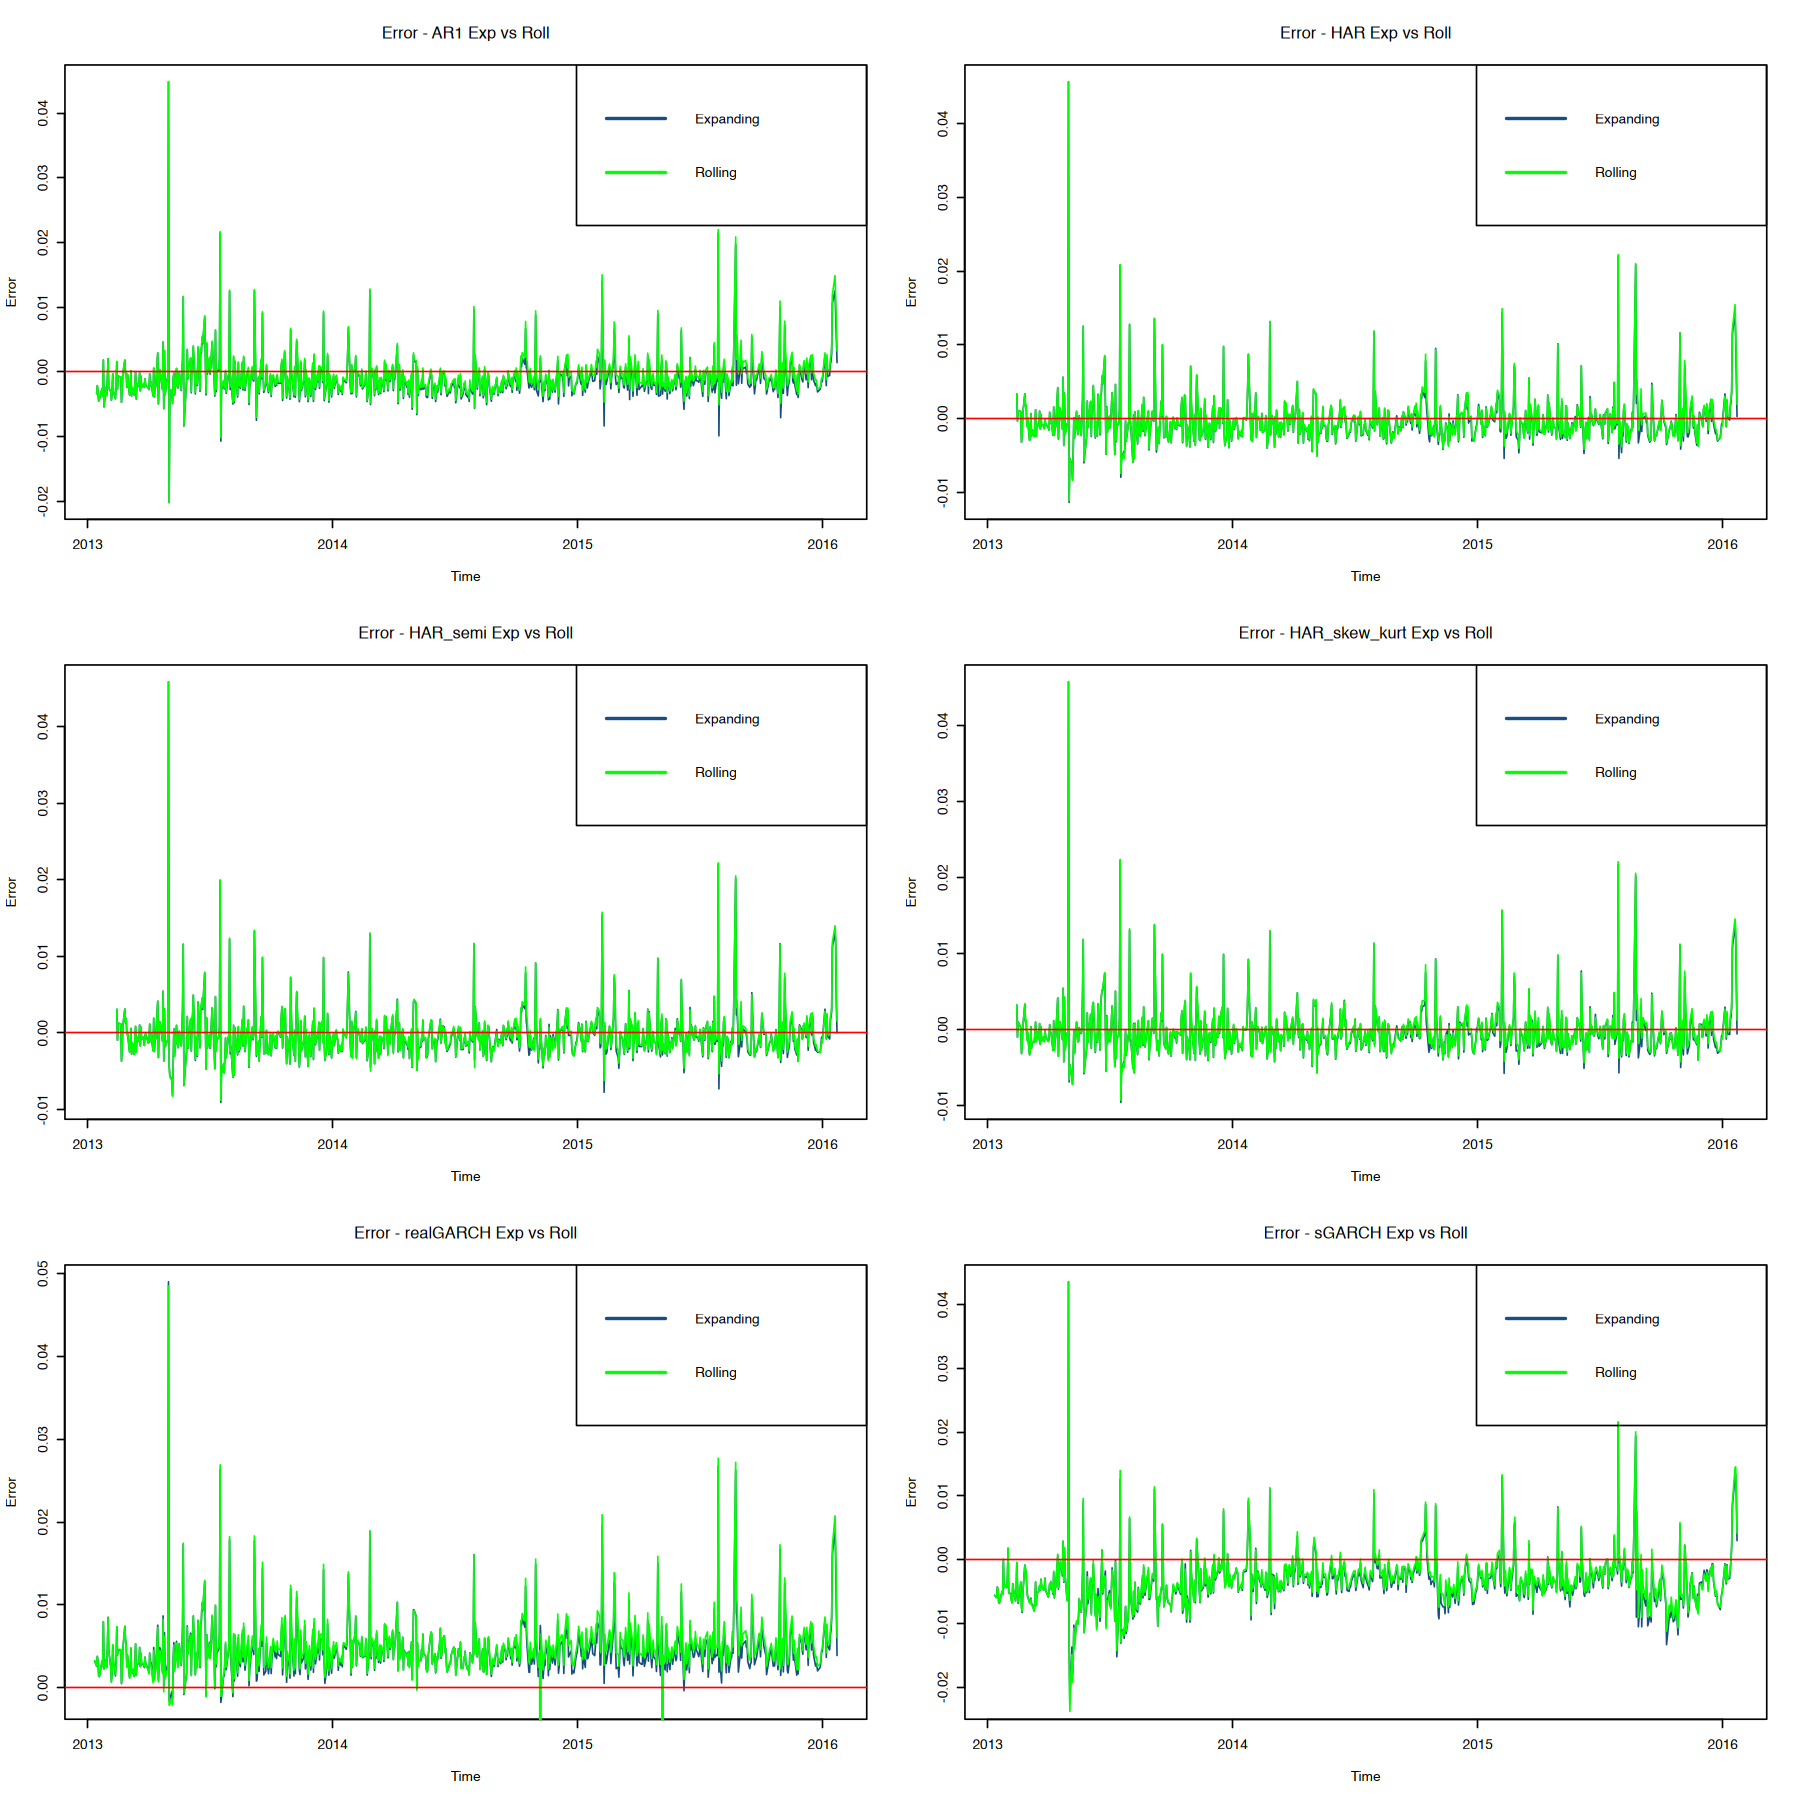

In [61]:
# plot roll vs expanding window for each model
par(mfrow=c(3, 2)) 

for (model in unique(sub("_(exp|roll)$", "", forecast_names))) {
    exp_name = paste0(model, "_exp")
    roll_name = paste0(model, "_roll")
      
    
    plot(index(combined_forecast_matrix), error_list[[exp_name]], type='l', col="#194f80", lwd=1, 
         xlab="Time", ylab="Error", main=paste("Error -", model, "Exp vs Roll"))
    lines(index(combined_forecast_matrix), error_list[[roll_name]], col="green", lwd=1)
    abline(h = 0, col = "red", lwd = 1) 
    legend("topright", legend=c("Expanding", "Rolling"), col=c("#194f80", "green"), lty=1, lwd=2)

}

The errors are quite similar across models and when comparing the two forecasting schemes. The most obvious difference is the realGARCH model using the rolling window, which leads to a few outliers in the forecast. Since forecasts with large errors can lead to serious consequences in the real world, we continue the analysis with those forecasts as they are, as well as winsorized values, to see the performance of the model without being considerably affected by the outliers.

In [62]:
# Winsorizing realGARCH_exp at the 99.5th percentile
combined_forecast_matrix$realGARCH_wins_exp = Winsorize(combined_forecast_matrix$realGARCH_exp, probs = c(0.005, 0.995))

# Winsorizing realGARCH_roll at the 99th percentile
combined_forecast_matrix$realGARCH_wins_roll = Winsorize(combined_forecast_matrix$realGARCH_roll, probs = c(0.005, 0.995))

In [63]:
summary(combined_forecast_matrix)

     Index               AR1_exp            AR1_roll           HAR_exp        
 Min.   :2013-01-11   Min.   :0.007839   Min.   :0.007369   Min.   :0.006301  
 1st Qu.:2013-10-10   1st Qu.:0.009331   1st Qu.:0.008939   1st Qu.:0.008528  
 Median :2014-07-14   Median :0.009948   Median :0.009509   Median :0.009418  
 Mean   :2014-07-14   Mean   :0.010270   Mean   :0.009833   Mean   :0.009629  
 3rd Qu.:2015-04-14   3rd Qu.:0.010742   3rd Qu.:0.010264   3rd Qu.:0.010260  
 Max.   :2016-01-22   Max.   :0.031653   Max.   :0.031704   Max.   :0.022883  
                      NA's   :1          NA's   :1          NA's   :22        
    HAR_roll         HAR_semi_exp      HAR_semi_roll      HAR_skew_kurt_exp 
 Min.   :0.006129   Min.   :0.006245   Min.   :0.005892   Min.   :0.005322  
 1st Qu.:0.008492   1st Qu.:0.008502   1st Qu.:0.008452   1st Qu.:0.008513  
 Median :0.009292   Median :0.009361   Median :0.009222   Median :0.009459  
 Mean   :0.009496   Mean   :0.009638   Mean   :0.009513   Me

In [64]:
# calculate errors
error_list = list()
forecast_names = colnames(combined_forecast_matrix)

for (name in forecast_names) {
  error_list[[name]] = amt$RV - combined_forecast_matrix[,name]
  colnames(error_list[[name]]) = name
}

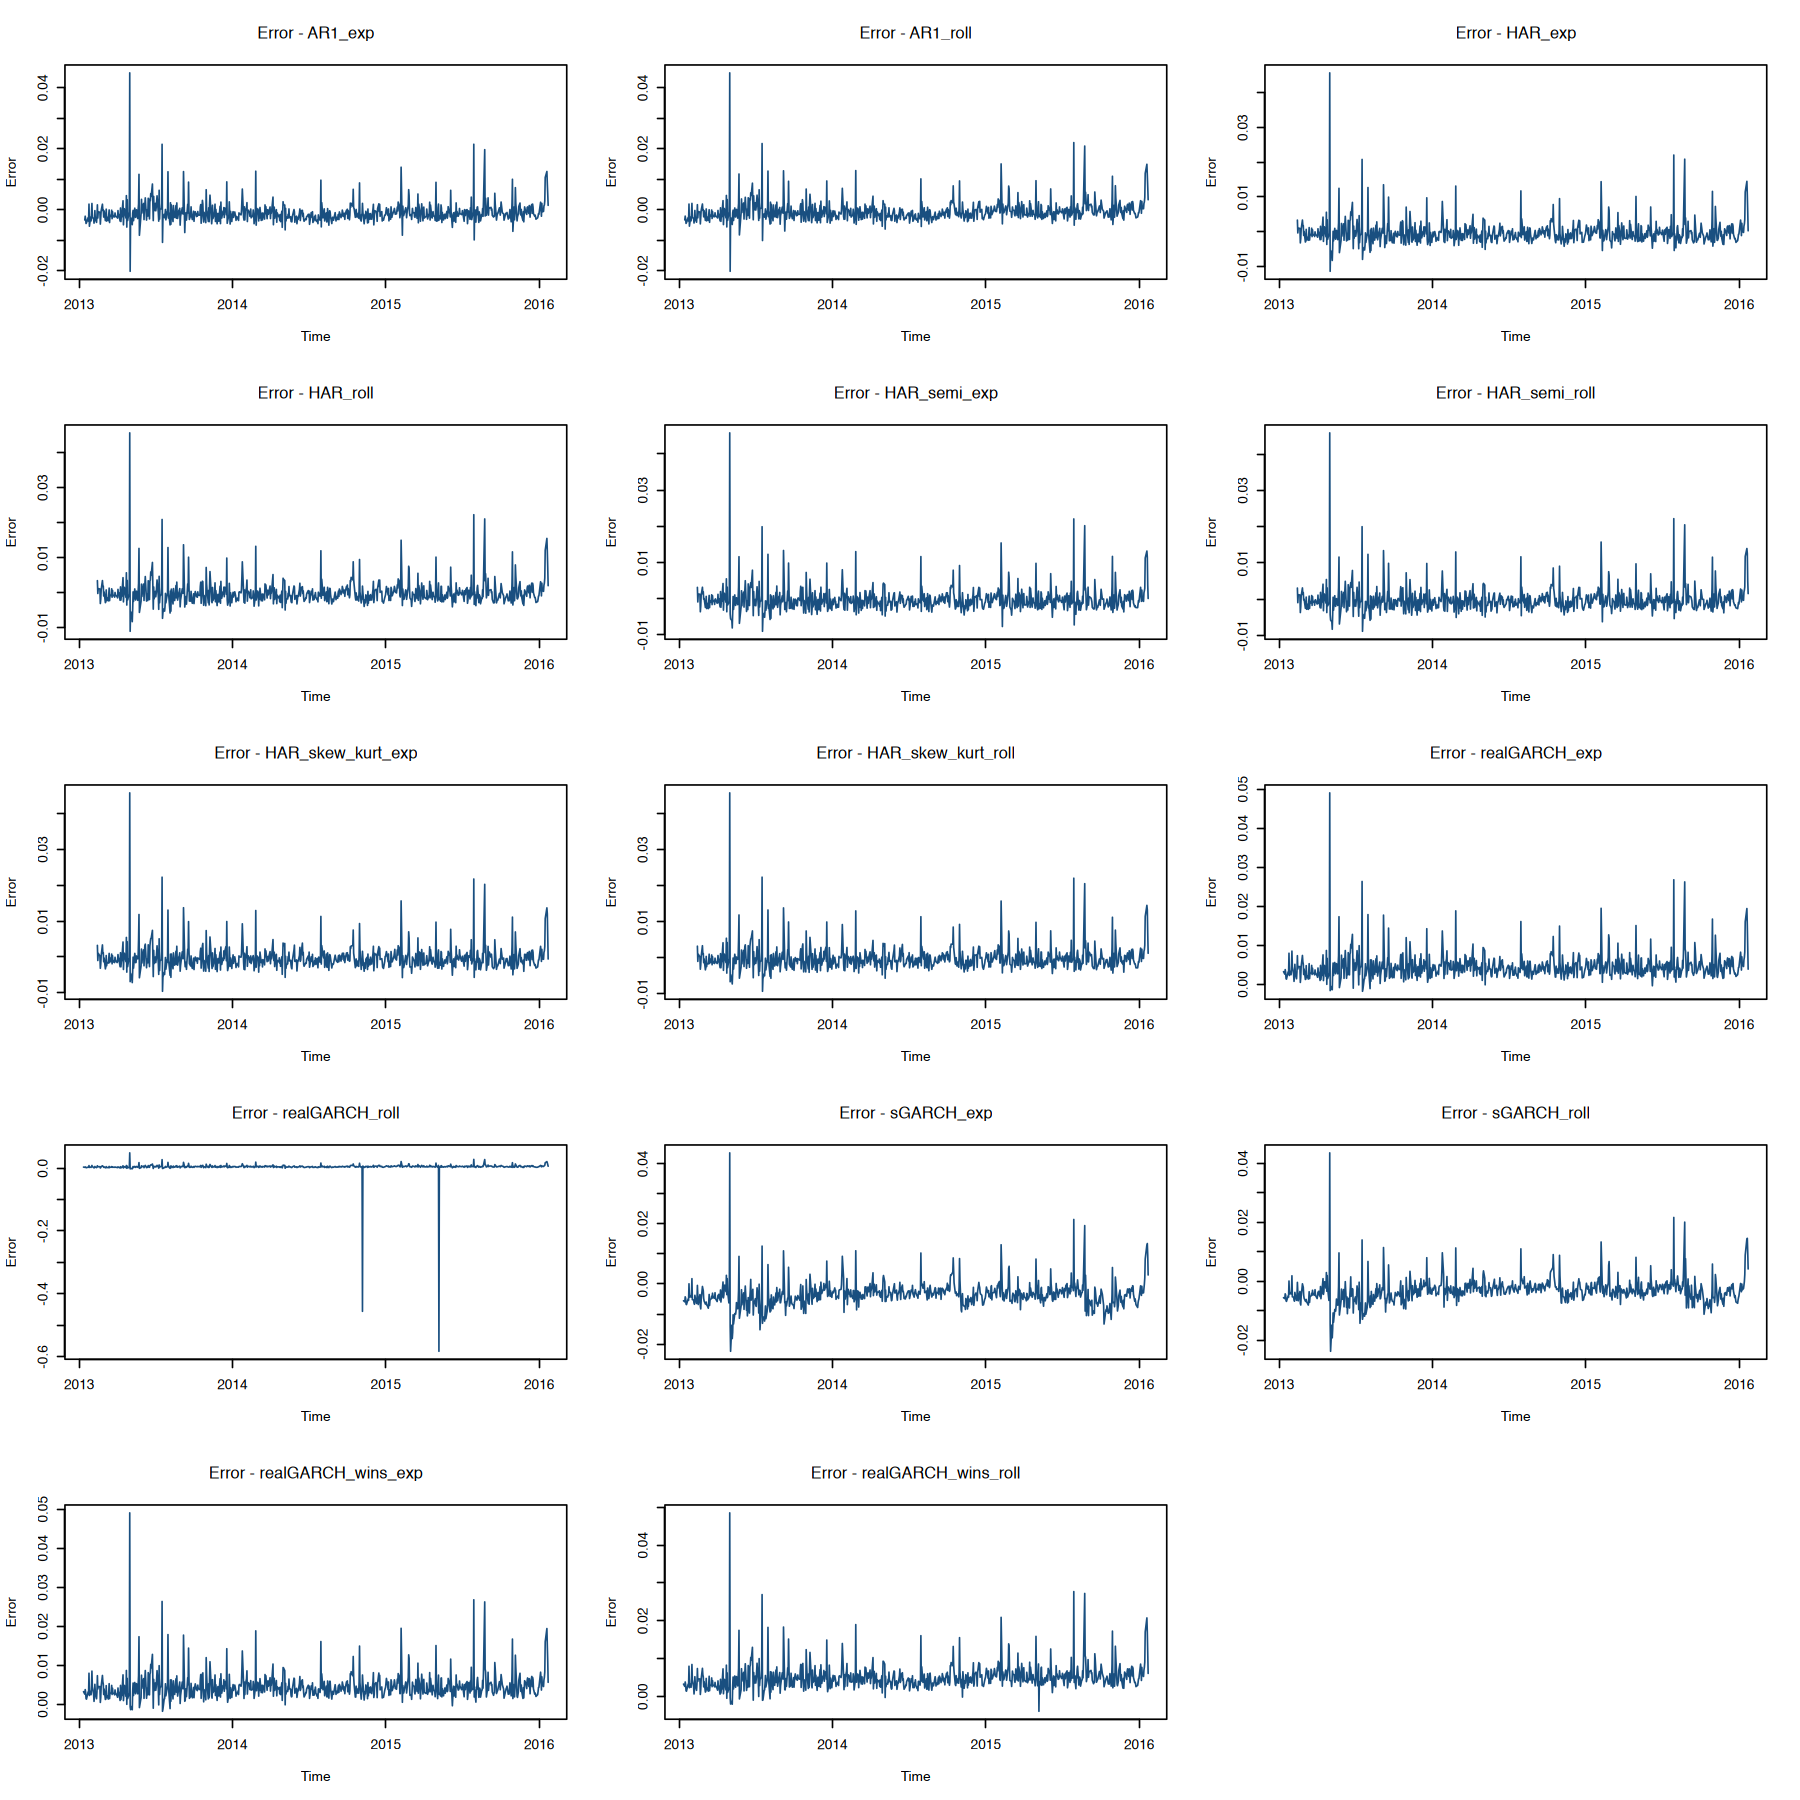

In [65]:
# Plot the errors
options(repr.plot.width = 15, repr.plot.height = 15)
par(mfrow=c(5, 3))

for (i in 1:length(forecast_names)) {
  plot(index(combined_forecast_matrix), error_list[[forecast_names[i]]], type='l', col="#194f80", lwd=1, 
       xlab="Time", ylab="Error", main=paste("Error -", forecast_names[i]))
}

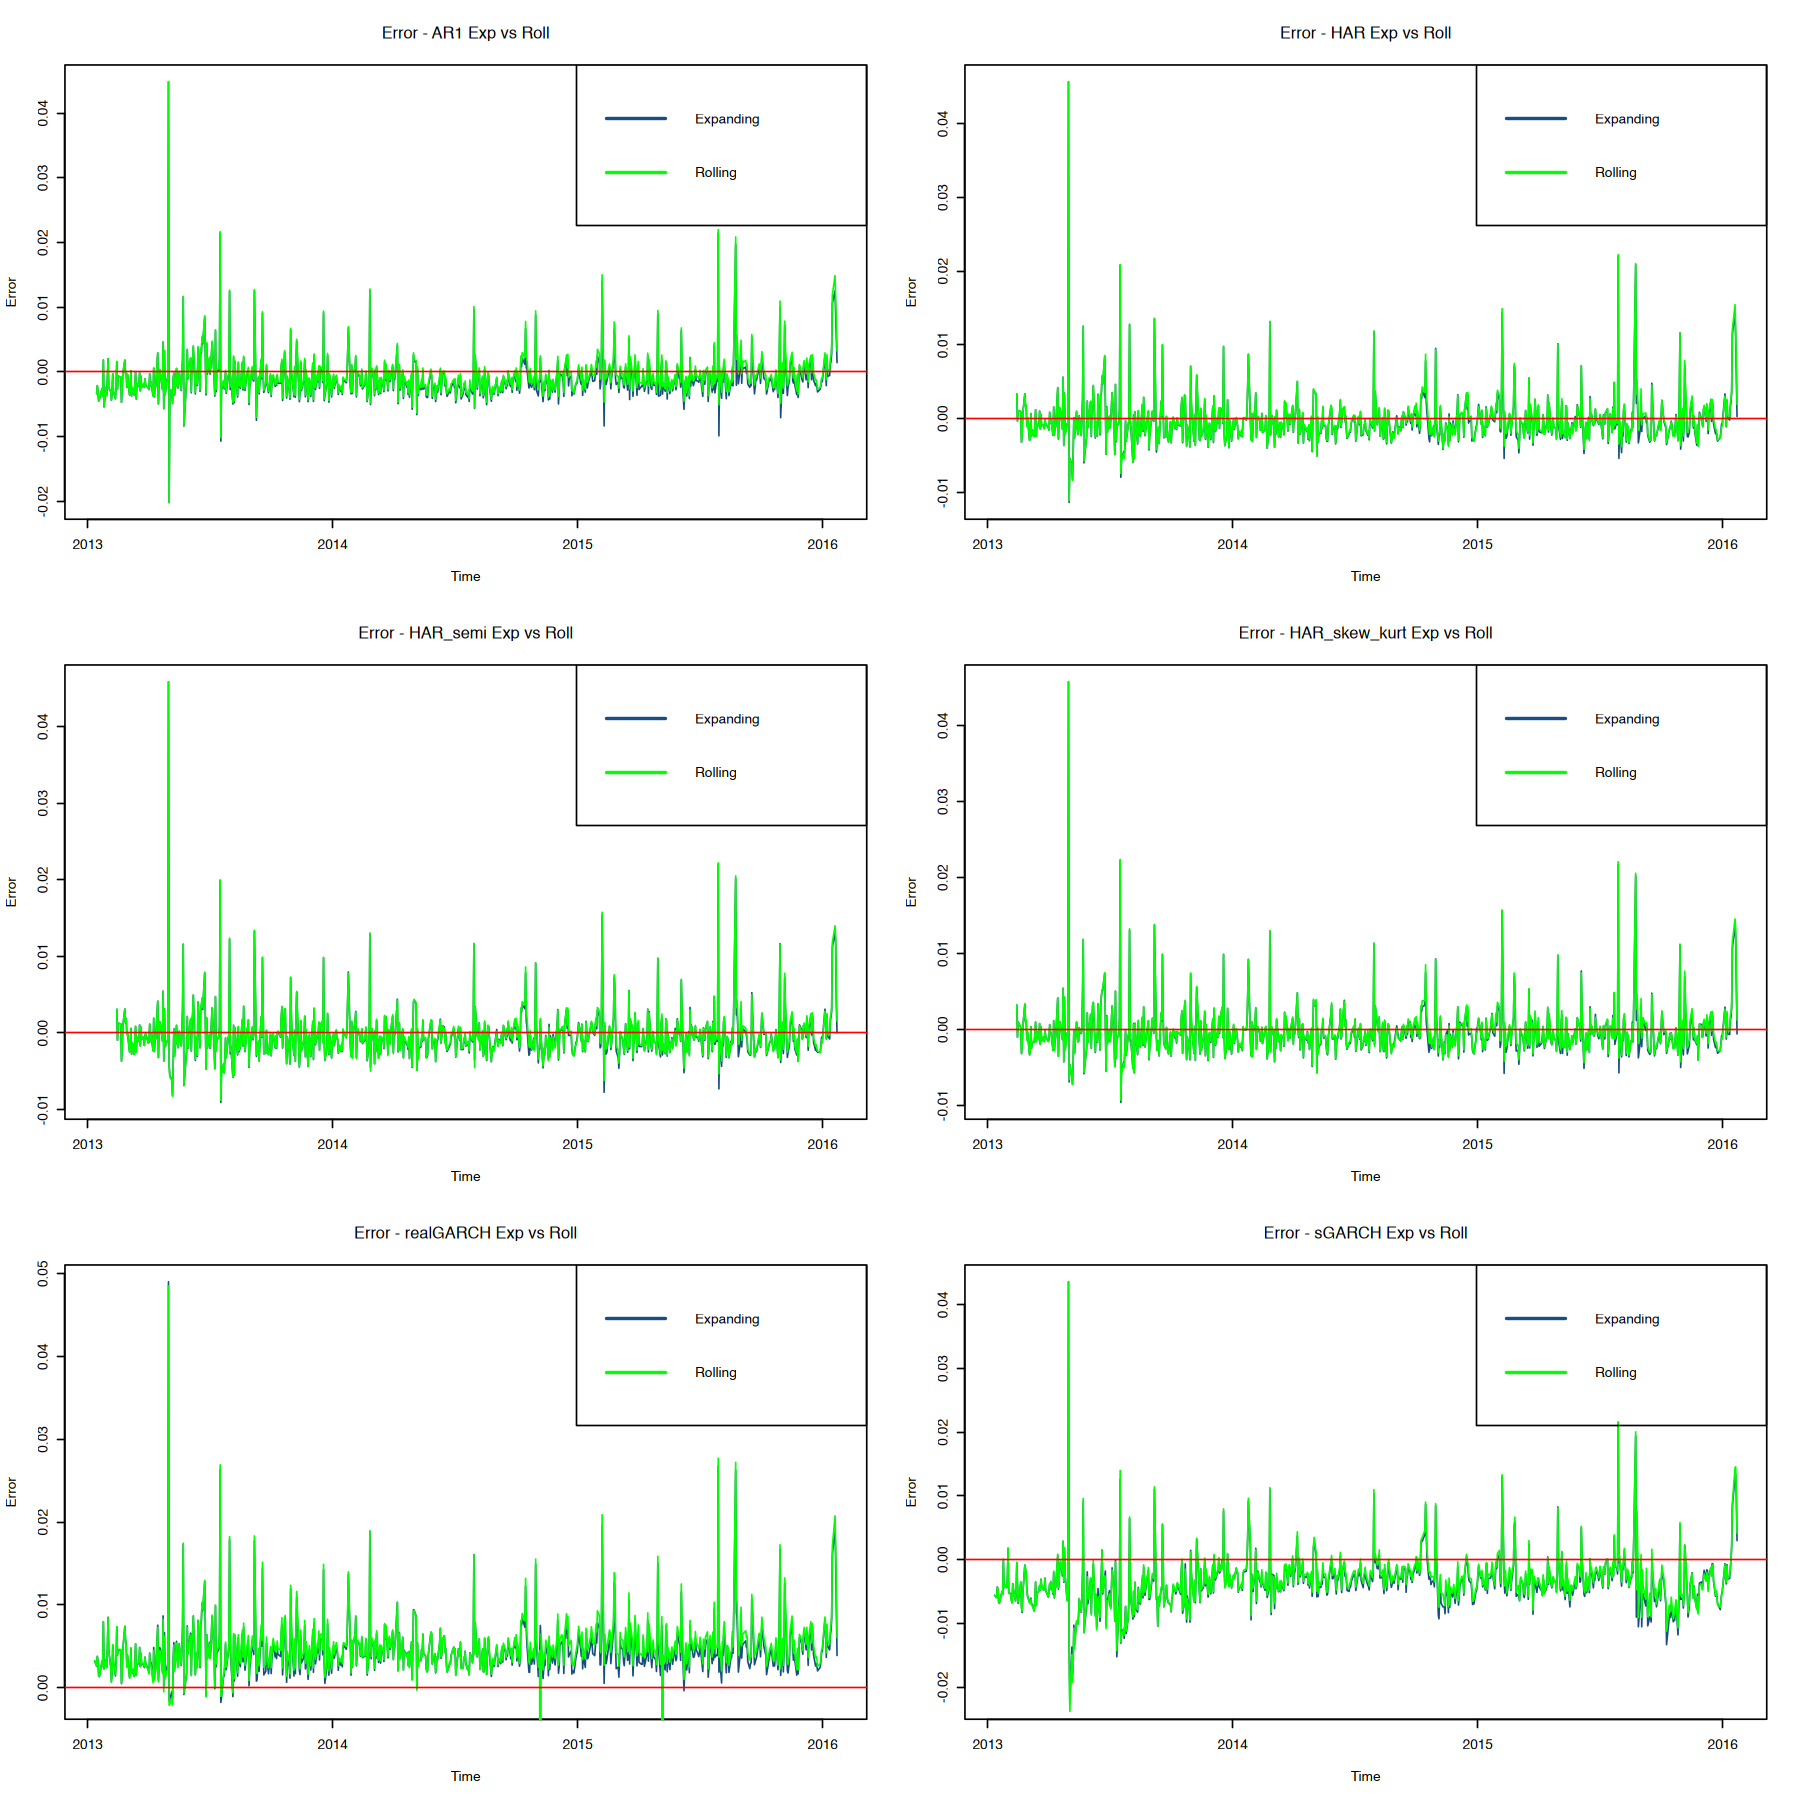

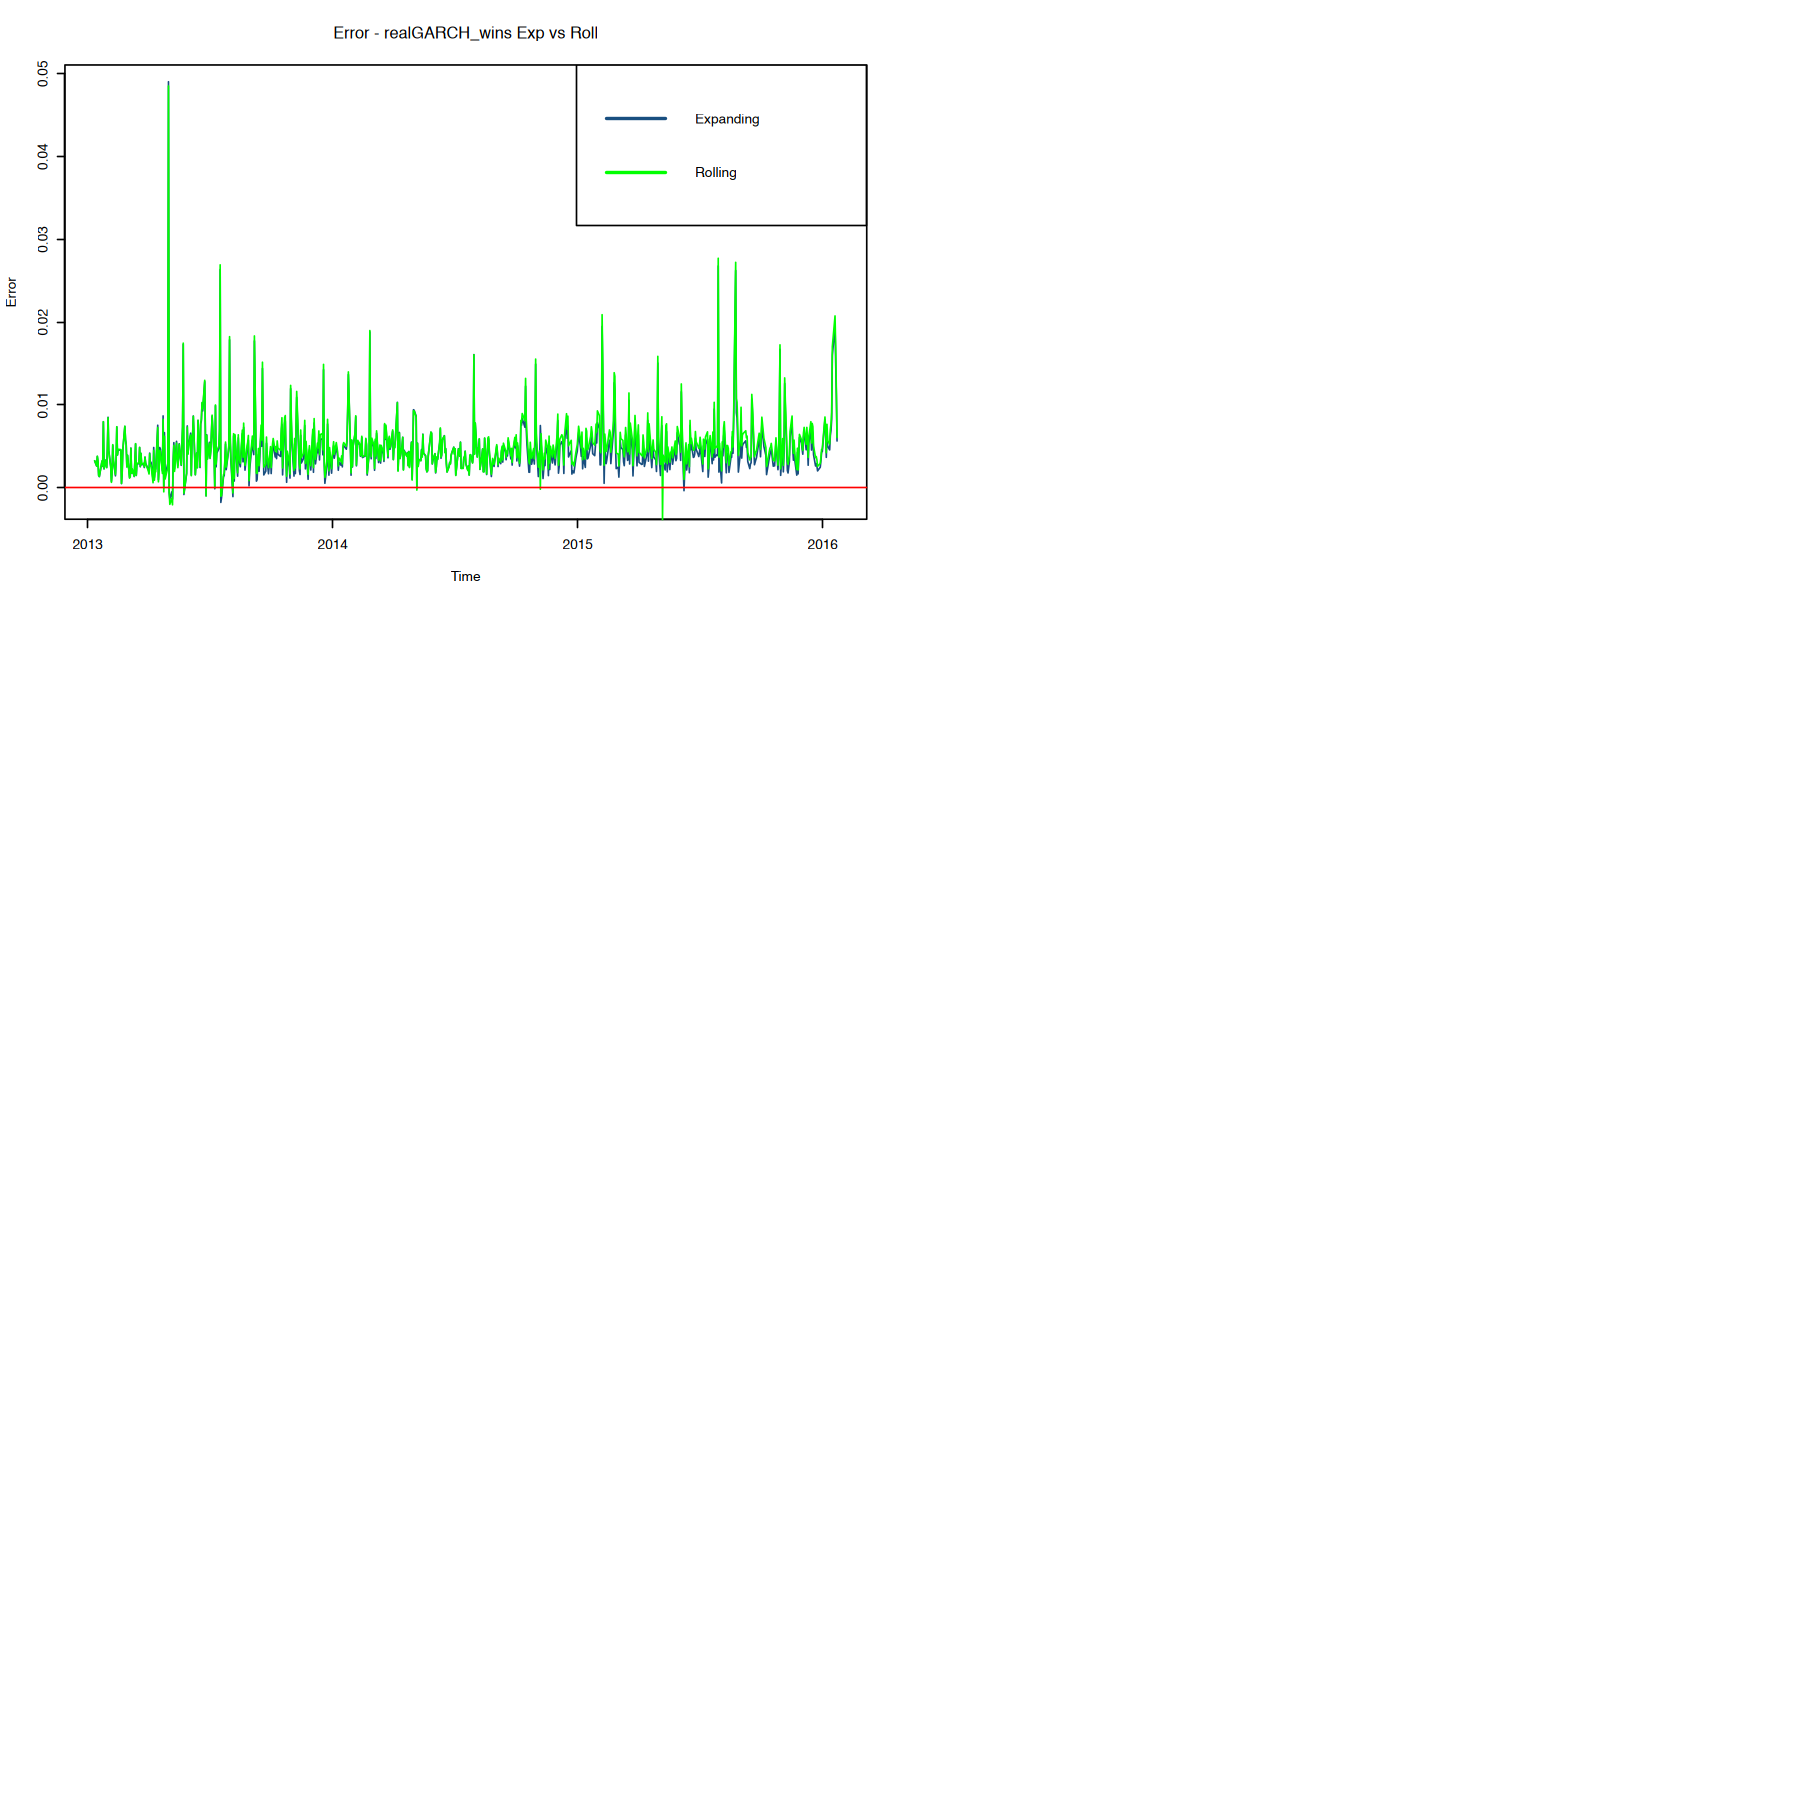

In [66]:
model_types = unique(sub("_(exp|roll)$", "", forecast_names))
options(repr.plot.width = 15, repr.plot.height = 15)
par(mfrow=c(3, 2)) 

for (model in model_types) {
  exp_name = paste0(model, "_exp")
  roll_name = paste0(model, "_roll")
  
  if (exp_name %in% forecast_names && roll_name %in% forecast_names) {
    plot(index(combined_forecast_matrix), error_list[[exp_name]], type='l', col="#194f80", lwd=1, 
         xlab="Time", ylab="Error", main=paste("Error -", model, "Exp vs Roll"))
    lines(index(combined_forecast_matrix), error_list[[roll_name]], col="green", lwd=1)
    abline(h = 0, col = "red", lwd = 1) 
    legend("topright", legend=c("Expanding", "Rolling"), col=c("#194f80", "green"), lty=1, lwd=2)
  }
}

## (c) Forecasts evaluation - MAE and MSE

In [67]:
# Function to calculate MSE
mse = function(errors) {
  round(mean(na.omit(errors)^2), 7)
}

# Function to calculate MAE
mae = function(errors) {
  round(mean(abs(na.omit(errors))), 7)
}

mse_results = sapply(error_list, mse)
mae_results = sapply(error_list, mae)

In [68]:
print(sort(mae_results, decreasing = FALSE))

 HAR_skew_kurt_roll       HAR_semi_roll   HAR_skew_kurt_exp            HAR_roll 
          0.0021174           0.0021212           0.0021336           0.0021347 
       HAR_semi_exp             HAR_exp            AR1_roll             AR1_exp 
          0.0021382           0.0021482           0.0023006           0.0024359 
        sGARCH_roll          sGARCH_exp       realGARCH_exp  realGARCH_wins_exp 
          0.0041189           0.0043761           0.0046623           0.0046650 
realGARCH_wins_roll      realGARCH_roll 
          0.0051633           0.0065451 


In [69]:
print(sort(mse_results, decreasing = FALSE))

       HAR_semi_exp       HAR_semi_roll   HAR_skew_kurt_exp             HAR_exp 
          0.0000125           0.0000126           0.0000127           0.0000128 
 HAR_skew_kurt_roll            HAR_roll            AR1_roll             AR1_exp 
          0.0000128           0.0000129           0.0000135           0.0000138 
        sGARCH_roll          sGARCH_exp       realGARCH_exp  realGARCH_wins_exp 
          0.0000281           0.0000300           0.0000336           0.0000337 
realGARCH_wins_roll      realGARCH_roll 
          0.0000390           0.0007684 


The GARCH-type models are outperformed by the heterogeneous autoregressive models in terms of the mean absolute error and the mean squared error. The MAE and MSE is similar for all HAR model, followed by the simple AR(1)-RV model, and then followed by the ARMA-GARCH, which has the MAE and MSE approximately twice as large as as the AR1 model, regardless of the forecasting schemes. Overall, the difference between the rolling and expanding scheme MAE and MSE is relatively minor for all models with the exception of the realGARCH, which is mostly affected by the extreme values discussed before.

## (d) Diebold-Mariano test

Since we have 12 different models (+ realGARCH with winsorized forecasts), the most systematic way to compare them using the Diebold-Mariano test would be the number of times the certain models outperforms another. 

In [70]:
mse_daily = function(errors) {
  errors^2  # Squaring each error
}

daily_mse_results = lapply(error_list, mse_daily)
daily_mse_matrix = do.call(cbind, daily_mse_results)
head(daily_mse_matrix)

                AR1_exp     AR1_roll HAR_exp HAR_roll HAR_semi_exp
2013-01-11           NA           NA      NA       NA           NA
2013-01-14 1.119151e-05 1.119151e-05      NA       NA           NA
2013-01-15 4.484798e-06 4.485850e-06      NA       NA           NA
2013-01-16 9.420028e-06 9.419292e-06      NA       NA           NA
2013-01-17 2.012151e-05 2.014768e-05      NA       NA           NA
2013-01-18 1.817745e-05 1.819055e-05      NA       NA           NA
           HAR_semi_roll HAR_skew_kurt_exp HAR_skew_kurt_roll realGARCH_exp
2013-01-11            NA                NA                 NA  1.055429e-05
2013-01-14            NA                NA                 NA  6.849116e-06
2013-01-15            NA                NA                 NA  1.417033e-05
2013-01-16            NA                NA                 NA  9.692452e-06
2013-01-17            NA                NA                 NA  2.148385e-06
2013-01-18            NA                NA                 NA  1.765794e-06

In [71]:
mae_daily = function(errors) {
  abs(errors)
}

daily_mae_results = lapply(error_list, mae_daily)
daily_mae_matrix = do.call(cbind, daily_mse_results)

In [72]:

perform_dm_tests = function(data_matrix, cols_to_remove = NULL) {
  data_matrix = na.omit(data_matrix[, -cols_to_remove])

  n_models = ncol(data_matrix)
  results = matrix(NA, nrow = n_models, ncol = n_models, dimnames = list(colnames(data_matrix), colnames(data_matrix)))
  outperformance_counts = integer(n_models)
  outperformance_list = vector("list", n_models)
  names(outperformance_list) = colnames(data_matrix)

  for (i in 1:n_models) {
    for (j in 1:n_models) {
      if (i != j) {
        dm_result = dm.test(data_matrix[, i], data_matrix[, j], alternative = "less")
        results[j, i] = dm_result$p.value
        
        if (dm_result$p.value < 0.05) {
          outperformance_counts[i] = outperformance_counts[i] + 1
          outperformance_list[[i]] = c(outperformance_list[[i]], colnames(data_matrix)[j])}}}}
  
  names(outperformance_counts) = colnames(data_matrix)
  sorted_counts = sort(outperformance_counts, decreasing = TRUE)
  
  print("Sorted counts of model outperformance:")
  print(sorted_counts)

  # Print models each model outperforms
  print("Models each model outperforms:")
  for (i in names(outperformance_list)) {
    if (length(outperformance_list[[i]]) > 0) {
      cat(i, "outperforms:", paste(outperformance_list[[i]], collapse=", "), "\n")
    }
  }
}

In [73]:
perform_dm_tests(daily_mse_matrix, c((ncol(daily_mse_matrix)-1):ncol(daily_mse_matrix)))

[1] "Sorted counts of model outperformance:"
           AR1_exp            HAR_exp       HAR_semi_exp  HAR_skew_kurt_exp 
                 2                  2                  2                  2 
          AR1_roll           HAR_roll      HAR_semi_roll HAR_skew_kurt_roll 
                 1                  1                  1                  1 
     realGARCH_exp     realGARCH_roll         sGARCH_exp        sGARCH_roll 
                 0                  0                  0                  0 
[1] "Models each model outperforms:"
AR1_exp outperforms: AR1_roll, realGARCH_exp 
AR1_roll outperforms: realGARCH_exp 
HAR_exp outperforms: HAR_roll, realGARCH_exp 
HAR_roll outperforms: realGARCH_exp 
HAR_semi_exp outperforms: HAR_semi_roll, realGARCH_exp 
HAR_semi_roll outperforms: realGARCH_exp 
HAR_skew_kurt_exp outperforms: HAR_skew_kurt_roll, realGARCH_exp 
HAR_skew_kurt_roll outperforms: realGARCH_exp 


In [74]:
perform_dm_tests(daily_mse_matrix, c(9, 10))

[1] "Sorted counts of model outperformance:"
            AR1_exp             HAR_exp        HAR_semi_exp   HAR_skew_kurt_exp 
                  3                   3                   3                   3 
           AR1_roll            HAR_roll       HAR_semi_roll  HAR_skew_kurt_roll 
                  2                   2                   2                   2 
         sGARCH_exp         sGARCH_roll  realGARCH_wins_exp realGARCH_wins_roll 
                  1                   1                   1                   0 
[1] "Models each model outperforms:"
AR1_exp outperforms: AR1_roll, realGARCH_wins_exp, realGARCH_wins_roll 
AR1_roll outperforms: realGARCH_wins_exp, realGARCH_wins_roll 
HAR_exp outperforms: HAR_roll, realGARCH_wins_exp, realGARCH_wins_roll 
HAR_roll outperforms: realGARCH_wins_exp, realGARCH_wins_roll 
HAR_semi_exp outperforms: HAR_semi_roll, realGARCH_wins_exp, realGARCH_wins_roll 
HAR_semi_roll outperforms: realGARCH_wins_exp, realGARCH_wins_roll 
HAR_skew_kur

In [75]:
perform_dm_tests(daily_mae_matrix, c((ncol(daily_mae_matrix)-1):ncol(daily_mae_matrix)))

[1] "Sorted counts of model outperformance:"
           AR1_exp            HAR_exp       HAR_semi_exp  HAR_skew_kurt_exp 
                 2                  2                  2                  2 
          AR1_roll           HAR_roll      HAR_semi_roll HAR_skew_kurt_roll 
                 1                  1                  1                  1 
     realGARCH_exp     realGARCH_roll         sGARCH_exp        sGARCH_roll 
                 0                  0                  0                  0 
[1] "Models each model outperforms:"
AR1_exp outperforms: AR1_roll, realGARCH_exp 
AR1_roll outperforms: realGARCH_exp 
HAR_exp outperforms: HAR_roll, realGARCH_exp 
HAR_roll outperforms: realGARCH_exp 
HAR_semi_exp outperforms: HAR_semi_roll, realGARCH_exp 
HAR_semi_roll outperforms: realGARCH_exp 
HAR_skew_kurt_exp outperforms: HAR_skew_kurt_roll, realGARCH_exp 
HAR_skew_kurt_roll outperforms: realGARCH_exp 


In [76]:
perform_dm_tests(daily_mae_matrix, c(9, 10))

[1] "Sorted counts of model outperformance:"
            AR1_exp             HAR_exp        HAR_semi_exp   HAR_skew_kurt_exp 
                  3                   3                   3                   3 
           AR1_roll            HAR_roll       HAR_semi_roll  HAR_skew_kurt_roll 
                  2                   2                   2                   2 
         sGARCH_exp         sGARCH_roll  realGARCH_wins_exp realGARCH_wins_roll 
                  1                   1                   1                   0 
[1] "Models each model outperforms:"
AR1_exp outperforms: AR1_roll, realGARCH_wins_exp, realGARCH_wins_roll 
AR1_roll outperforms: realGARCH_wins_exp, realGARCH_wins_roll 
HAR_exp outperforms: HAR_roll, realGARCH_wins_exp, realGARCH_wins_roll 
HAR_roll outperforms: realGARCH_wins_exp, realGARCH_wins_roll 
HAR_semi_exp outperforms: HAR_semi_roll, realGARCH_wins_exp, realGARCH_wins_roll 
HAR_semi_roll outperforms: realGARCH_wins_exp, realGARCH_wins_roll 
HAR_skew_kur

There does not seem to be clear-cut winner in our data in terms of forecasting performance. The general conclusion is that the (H)AR models outperform the GARCH-type models. According to the dm.test it also seems that the expanding window forecast perform better to their rolling window counterparts.

## (e) Minzer-Zarnowitz regression

$$ y_t = \beta_0 + \beta_1 \hat{y}_t + \epsilon_t $$

Where:
- $ y_t $ : Actual value at time $ t $
- $ \hat{y}_t $ : Forecasted value at time $ t $
- $ \beta_0 $ : Intercept term of the regression
- $ \beta_1 $ : Slope coefficient, which measures the bias in the forecast
- $ \epsilon_t $ : Error term, capturing the unpredicted part of $ y_t $

In the Minzer-Zarnowitz regression we regress the actual values ($y_t$) on the forecasted values ($\hat{y}_t$). We conduct the following hypothesis tests:

**Intercept Term** ($\beta_0$): We test whether the intercept is statistically different from zero. A non-zero intercept would indicate a systematic bias in the forecast, suggesting that the forecasts are either consistently overestimating or underestimating the actual values.

**Slope Coefficient** ($\beta_1$): We test whether the slope is statistically different from one. The slope being significantly different from one indicates that the forecasts are not perfectly proportional to the actual values

**Joint Hypothesis Test via Wald Test**: We use the Wald test to jointly assess the null hypotheses that $\beta_0 = 0$ and $\beta_1 = 1$. This test provides a robust measure of overall model fit and the adequacy of forecasts. If the null hypothesis is rejected, it suggests that the forecasts do not adequately follow the actual values

In [77]:

# empty list to store results
results = list()

# Loop through each predictor column
for (column in names(data_all[, -ncol(data_all)])) {
    # estimate model
    model = lm(paste("RV ~", column), data = data_all)
    
    # Extract coefficients
    coef_info = summary(model)$coefficients
    vcov_matrix = vcovHAC(model) # Get the variance-covariance matrix of the coefficients
    
    # Calculate Wald test statistic
    wald_statistic = (coef_info[, "Estimate"] - c(0, 1)) %*% solve(vcov_matrix) %*% (coef_info[, "Estimate"] - c(0, 1))
    wald_p_value = pchisq(wald_statistic, df = 2, lower.tail = FALSE) # Chi-squared test with 2 degrees of freedom
    
    # Calculate p-values for each coefficient individually
    intercept_p_value = 2 * (1 - pnorm(abs(coef_info["(Intercept)", "Estimate"] / coef_info["(Intercept)", "Std. Error"])))
    slope_p_value = 2 * (1 - pnorm(abs((coef_info[column, "Estimate"] - 1) / coef_info[column, "Std. Error"])))
    
    # Store results in the list
    results[[column]] = c(
    round(coef_info[column, "Estimate"], 2), 
    round(coef_info[column, "Std. Error"], 2), 
    round((coef_info[column, "Estimate"] - 1) / coef_info[column, "Std. Error"], 2),
    round(slope_p_value, 2), 
    round(intercept_p_value, 2),
    round(wald_p_value, 2), 
    ifelse(slope_p_value < 0.05, "Reject", "Do not reject"), # Reject/Not Reject for slope = 1
    ifelse(intercept_p_value < 0.05, "Reject", "Do not reject"), # Reject/Not Reject for intercept = 0
    ifelse(wald_p_value < 0.05, "Reject", "Do not reject") # Reject/Not Reject for Wald test
    )}

In [78]:
# Convert results to a data frame
results_df = do.call(rbind, results)
colnames(results_df) = c(
    "Slope Coeff.", 
    "SE", 
    "Predictor Test Stat.", 
    "Slope p-value", 
    "Intercept p-value", 
    "Wald p-value",
    "beta==1", 
    "(Intercept)==0",
    "beta==1∧(Intercept)==0"
)

results_df

Slope Coeff. SE   Predictor Test Stat. Slope p-value
AR1_exp            0.83         0.08 -2.26                0.02         
AR1_roll           0.82         0.08 -2.08                0.04         
HAR_exp            0.9          0.08 -1.28                0.2          
HAR_roll           0.92         0.08 -0.95                0.34         
HAR_semi_exp       0.91         0.07 -1.25                0.21         
HAR_semi_roll      0.93         0.08 -0.92                0.36         
HAR_skew_kurt_exp  0.89         0.07 -1.52                0.13         
HAR_skew_kurt_roll 0.91         0.08 -1.09                0.28         
realGARCH_exp      1.06         0.08 0.7                  0.48         
realGARCH_roll     0            0.01 -192.64              0            
sGARCH_exp         0.32         0.05 -14.76               0            
sGARCH_roll        0.3          0.05 -15.4                0            
                   Intercept p-value Wald p-value beta==1       (Intercept)==0
AR1_exp            0.28              0            Reject        Do not reject 
AR1_roll           0.13              0            Reject        Do not reject 
HAR_exp            0.31              0.35         Do not reject Do not reject 
HAR_roll           0.39              0.85         Do not reject Do not reject 
HAR_semi_exp       0.34              0.32         Do not reject Do not reject 
HAR_semi_roll      0.42              0.8          Do not reject Do not reject 
HAR_skew_kurt_exp  0.23              0.23         Do not reject Do not reject 
HAR_skew_kurt_roll 0.33              0.76         Do not reject Do not reject 
realGARCH_exp      0                 0            Do not reject Reject        
realGARCH_roll     0                 0            Reject        Reject        
sGARCH_exp         0                 0            Reject        Reject        
sGARCH_roll        0                 0            Reject        Reject        
                   beta==1∧(Intercept)==0
AR1_exp            Reject                
AR1_roll           Reject                
HAR_exp            Do not reject         
HAR_roll           Do not reject         
HAR_semi_exp       Do not reject         
HAR_semi_roll      Do not reject         
HAR_skew_kurt_exp  Do not reject         
HAR_skew_kurt_roll Do not reject         
realGARCH_exp      Reject                
realGARCH_roll     Reject                
sGARCH_exp         Reject                
sGARCH_roll        Reject

We do not reject the joint null hypothesis for all heterogenous autoregressive type models, while it is rejected for the AR and GARCH-type models.

# 5) Summary

This project analyzes and forecasts the volatility of the stock price of American Tower Corporation (AMT) using various models and forecasting schemes. We estimate the AR(1)-RV, HAR, HAR-RS, HAR-Rskew-RKurt, Realized GARCH, ARMA-GARCH (specifically ARMA(1,1)-GARCH(1,3)-t) models Then we perform an out-of-sample forecast using rolling and expanding window forecasting schemes.

Observing the in-sample fit, the HAR models perform the best in terms of the MAE and MSE metrics, while the ARMA-GARCH model performs the worst. This can also be seen from the in-sample plots of the fitted values against the true values as the ARMA-GARCH appears to be significantly overestimating the volatility. The HAR models all appear to be performing very similarly; however, the HAR-Rskew-Rkurt does appear to have the smallest in-sample MAE and MSE by a small margin. 

The forecasts using the real-GARCH model produce some extreme values for both forecasting schemes. Visual inspection indicates that the ARMA-GARCH model overestimates the volatility, while the realGARCH forecast underforecasts it. The rolling and expanding schemes generally produce similar results with only minor differences. Computing the MAE and MSE of the forecasts, we see that all the HAR models exhibit very similar results and the smallest error metrics, while the real-GARCH has the higher MAE and MSE. 

From the Diebold-Mariano test, we can see that forecasts made using the expanding window usually outperform forecasts using the rolling window for the same models, perhaps due to the inclusion of additional observations, and hence the ability to exploit some long-term information which the rolling window could miss. The test also support that the HAR-type models and the AR(1) model perform better than the GARCH-type models.

We use the Minzer-Zarnowitz regression to evaluate our forecast and test formally whether they systematically overestimate or underestimate the volatility and also to uncover potential bias. We do not reject the null hypothesis of $\alpha = 0$ and $\beta = 1$ for all the HAR models.

In conclusion, the HAR models are preferred as they perform better than the GARCH models in every metric. Namely, we would prefer either the HAR-RS or HAR-Rskew-RKurt due to their ability to account for the additional varialbes.